In [1]:
# Python packages and utilities
import os
import sys
from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import display, HTML

import mlxtend

#RDKit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs


# scikit-learn

import sklearn
    
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.feature_selection import RFECV, RFE
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#imbalanced learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
except ModuleNotFoundError:
    !pip install -U imbalanced-learn
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN

# seaborn
try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt

#PIL
from PIL import Image

# scikitplot library
try:
    import scikitplot as skplt
except ModuleNotFoundError:
    !pip install scikit-plot
    import scikitplot as skplt

!pip install pip install -U imbalanced-learn

# own module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pythia import classification_metrics as cmetrics
from pythia import fingerprints_generation as fp
from pythia import molecules_and_structures as ms
from pythia import plots as pltsk
from pythia import workflow_functions as wf

# utility
%load_ext autoreload
%autoreload 2
%aimport
import importlib


import logging 
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)


random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


Random seed fixed as 10459


Modules to reload:
all-except-skipped

Modules to skip:



# Load target data

First we read the dataset from a csv file. A csv file is a comma separated file, where each row is a data point.

`pd.read_csv()` is used to read the input csv file that contain the dataset. The dataset is stored in a dataframe, which is a data structure provided by the pandas library. A dataframe is a two-dimensional data structure, i.e. data is aligned in a tabular fashion in rows and columns. The dataframe can be indexed by column names.

Here, we also reformat the column names to replace spaces with underscores and make the column names all lower case. This is done to make it easier to work with the data.

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 10)

In [3]:
data = pd.read_csv("First_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [4]:
log.info("Columns: {}".format(data.columns))

Columns: Index(['reaction', 'substrate', 'catalyst', 'solvent', 'solvent_code',
       'temperature', 'ee', 'ddg', 'paper'],
      dtype='object')


# Set Target Properties

Here we define the input column and the target column. 

In chemistry, we usually use SMILES to represent molecules. SMILES is a string representation of a molecule. These SMILES strings should be obtained during data collection. Here we define the column name that contains the SMILES strings. 

The target values are the values that we want to predict. In this case, the target column is the column that contains the ddg values. 

In [5]:
substratesmiles = data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles.head()))

catalystsmiles = data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles.head()))

reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

temp = data["temperature"]
log.info("Temperature: {}".format(temp.head()))

ddg = data["ddg"]
log.info("DGG: {}".format(ddg.head()))

Substrate SMILES: 0         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
1    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
2         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
3    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
4         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
1    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
Name: catalyst, dtype: object
Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64
Temperature: 0   -30.0
1   -30.0
2   -30.0
3   -30.0
4   -30.0
Name: temperature, dtype: float64
DGG: 0    0.569810
1    1.761325
2    1.251493
3    5.229434
4    2.678563
Name: ddg, dtype: float64


In [6]:
targets = ddg

Here I make for you a folder to save the results of the notebook

In [7]:
os.makedirs("results_class_fingerprints", exist_ok=True)
os.chdir("results_class_fingerprints")

# Make Fingerprints

Fingerprints is a way to represent the molecules in a computer compatible way, with 0 and 1.

There are different types of fingerprints and choosing the most appropriate one depends on the problem and the data.

Here you can read about some of the fingerprints you can use with Pythia
https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf

In this section we are using MACCSkeys only as an example, in other fingerprint notebooks we explain how to use Morgan Fingerprints. Please have a look if you are interested.

Here we make different fingerprints for the substrates and the catalysts and then we concataint them. If you only have one molecule, you don't have to make two fingerprints!

In [8]:
# First make Fingerprints for the substrates

In [9]:
features1,features_df1 = fp.maccskeys_fingerprints(substratesmiles)
feature_types1 = "categorical" # other options 'some_categorical', 'no_categorical'

In [10]:
feats1 = features_df1.loc[:, (features_df1 != 0).any(axis=0)]

In [11]:
# Then make  Fingerprints for the catalysts

In [12]:
features2,features_df2 = fp.maccskeys_fingerprints(catalystsmiles)
feature_types2 = "categorical" # other options 'some_categorical', 'no_categorical'

In [13]:
feats2 = features_df2.loc[:, (features_df2 != 0).any(axis=0)]

Make one dataframe for both substrates and catalysts features. as features for both have the same headings, we add the suffix feature1 or feature2 depending is they belong to the substrates or catalysts respectively.

In [14]:
features_df = feats1.join(feats2, lsuffix="features1", rsuffix="features2")
feature_types = "categorical"

Dont forget to add the information for the temperature (or solvent if you have)

In [15]:
features_df = features_df.join(temp)

# Classify Molecules
We use these next cells to classify the ddg values into 'good' and 'bad' in terms of ddg (kJ/mol). Because the ddg values are continuous, we need to define a threshold value to separate the 'good' and 'bad' molecules. Here we define the threshold value as 4. If the target value is lower than the threshold value, we assign the class label 'class 0', which means the molecule is 'bad'. If the target value is higher than the threshold value or absent, we assign the class label 'class 1', which means the molecule is 'good'.

Note that how to define the class labels depends on the problem. For example, if we want to predict whether a molecule is toxic or not, we can define a threshold value and assign the class labels accordingly.  If To visualize all of these structure set show to True.

In [16]:
classes=[]
for index, value in ddg.items():
    if value < 4:
        classes.append(0)
    else:
        classes.append(1)

In [17]:
classes
class_targets_df = pd.DataFrame(np.array([classes]).T, columns=["classes"])
features_and_classes_df = features_df.copy()
features_and_classes_df["classes"] = classes

In [18]:
features_df.to_csv("features.csv")

In [26]:
# just converting all headers to str
features_df.columns = features_df.columns.astype(str)

# Feature Exploration

In the section we explore the MACCS keys bits and their relationships with ddg.

In [27]:
pd.set_option('display.max_columns', len(features_df.columns))
features_df.describe()

22          24          34          36          41  \
count  119.000000  119.000000  119.000000  119.000000  119.000000   
mean     0.008403    0.008403    0.243697    0.008403    0.008403   
std      0.091670    0.091670    0.431128    0.091670    0.091670   
min      0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000   

       42features1          46          49          50          56  \
count   119.000000  119.000000  119.000000  119.000000  119.000000   
mean      0.033613    0.092437    0.008403    0.025210    0.008403   
std       0.180994    0.290867    0.091670    0.157426    0.091670   
min       0.000000    0.000000    0.000000    0.000000    0.000000   
25%       0.000000    0.000000    0.000000    0.000000    0.000000   
50%       0.000000    0.000000    0.000000    0.000000    0.000000   
75%       0.000000    0.000000    0.000000    0.000000    0.000000   
max       1.000000    1.000000    1.000000    1.000000    1.000000   

               57          63  66features1          70          71  \
count  119.000000  119.000000   119.000000  119.000000  119.000000   
mean     0.016807    0.008403     0.344538    0.008403    0.008403   
std      0.129090    0.091670     0.477227    0.091670    0.091670   
min      0.000000    0.000000     0.000000    0.000000    0.000000   
25%      0.000000    0.000000     0.000000    0.000000    0.000000   
50%      0.000000    0.000000     0.000000    0.000000    0.000000   
75%      0.000000    0.000000     1.000000    0.000000    0.000000   
max      1.000000    1.000000     1.000000    1.000000    1.000000   

       74features1          76  78features1  81features1          83  \
count   119.000000  119.000000        119.0   119.000000  119.000000   
mean      0.327731    0.025210          1.0     0.008403    0.025210   
std       0.471371    0.157426          0.0     0.091670    0.157426   
min       0.000000    0.000000          1.0     0.000000    0.000000   
25%       0.000000    0.000000          1.0     0.000000    0.000000   
50%       0.000000    0.000000          1.0     0.000000    0.000000   
75%       1.000000    0.000000          1.0     0.000000    0.000000   
max       1.000000    1.000000          1.0     1.000000    1.000000   

              87  88features1  93features1          94  95features1  \
count  119.00000   119.000000   119.000000  119.000000   119.000000   
mean     0.10084     0.008403     0.075630    0.008403     0.008403   
std      0.30239     0.091670     0.265524    0.091670     0.091670   
min      0.00000     0.000000     0.000000    0.000000     0.000000   
25%      0.00000     0.000000     0.000000    0.000000     0.000000   
50%      0.00000     0.000000     0.000000    0.000000     0.000000   
75%      0.00000     0.000000     0.000000    0.000000     0.000000   
max      1.00000     1.000000     1.000000    1.000000     1.000000   

       96features1  97features1          98          99  100features1  \
count   119.000000   119.000000  119.000000  119.000000    119.000000   
mean      0.025210     0.025210    0.008403    0.285714      0.462185   
std       0.157426     0.157426    0.091670    0.453664      0.500676   
min       0.000000     0.000000    0.000000    0.000000      0.000000   
25%       0.000000     0.000000    0.000000    0.000000      0.000000   
50%       0.000000     0.000000    0.000000    0.000000      0.000000   
75%       0.000000     0.000000    0.000000    1.000000      1.000000   
max       1.000000     1.000000    1.000000    1.000000      1.000000   

       101features1         102         103  105features1  106features1  \
count    119.000000  119.000000  119.000000    119.000000    119.000000   
mean       0.042017    0.008403   

The next cell shows counts of for each bit how many with and how many without that bit are in each class

In [28]:
for ith, cat_feat in enumerate(features_df.columns):
    log.info("{} {}".format(cat_feat, ith))
    log.info("\n{}\n".format(pd.crosstab(features_df[cat_feat], class_targets_df["classes"])))

22 0

classes   0   1
22             
0        45  73
1         0   1

24 1

classes   0   1
24             
0        45  73
1         0   1

34 2

classes   0   1
34             
0        35  55
1        10  19

36 3

classes   0   1
36             
0        45  73
1         0   1

41 4

classes   0   1
41             
0        45  73
1         0   1

42features1 5

classes       0   1
42features1        
0            45  70
1             0   4

46 6

classes   0   1
46             
0        44  64
1         1  10

49 7

classes   0   1
49             
0        45  73
1         0   1

50 8

classes   0   1
50             
0        45  71
1         0   3

56 9

classes   0   1
56             
0        45  73
1         0   1

57 10

classes   0   1
57             
0        45  72
1         0   2

63 11

classes   0   1
63             
0        45  73
1         0   1

66features1 12

classes       0   1
66features1        
0            26  52
1            19  22

70 13

classes   0   1
7

82 93

classes   0   1
82             
0        32  38
1        13  36

84 94

classes   0   1
84             
0        41  74
1         4   0

85 95

classes   0   1
85             
0        23  36
1        22  38

86 96

classes   0   1
86             
0        32  73
1        13   1

88features2 97

classes       0   1
88features2        
0             4  18
1            41  56

90 98

classes   0   1
90             
0        28  36
1        17  38

91 99

classes   0   1
91             
0        31  35
1        14  39

92 100

classes   0   1
92             
0        12   0
1        33  74

93features2 101

classes       0   1
93features2        
0            21  32
1            24  42

95features2 102

classes       0   1
95features2        
0             8   0
1            37  74

96features2 103

classes       0   1
96features2        
0            41  74
1             4   0

97features2 104

classes       0   1
97features2        
0            36  38
1             9  36

100fea

The next cell show this data visually xaxis 0, 1 the bit present or absent. Colour bars are with in the group being present or not present do the molecules fall in to the 'bad' (0 class) or 'good' (1 class).

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


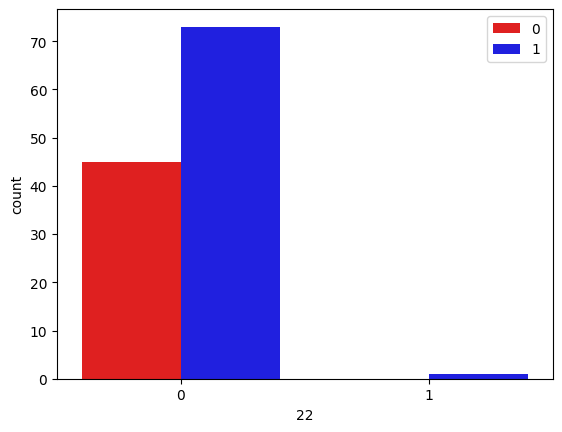

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


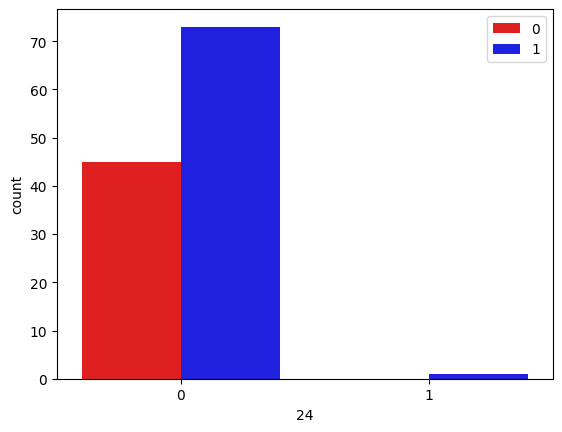

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


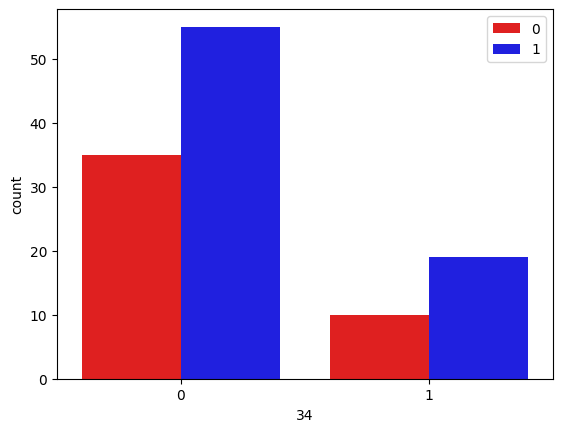

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


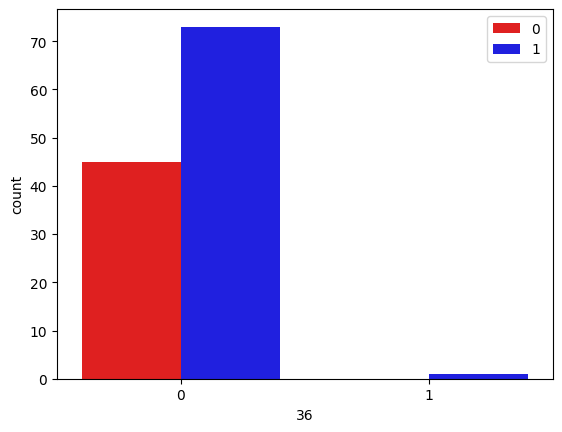

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


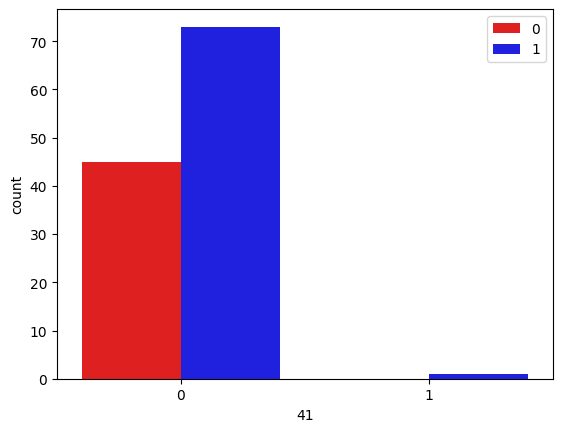

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


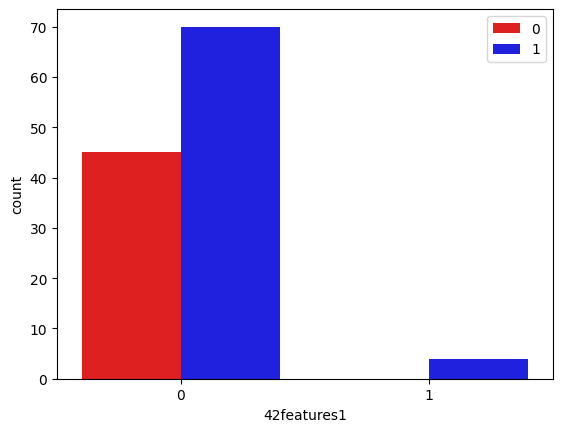

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


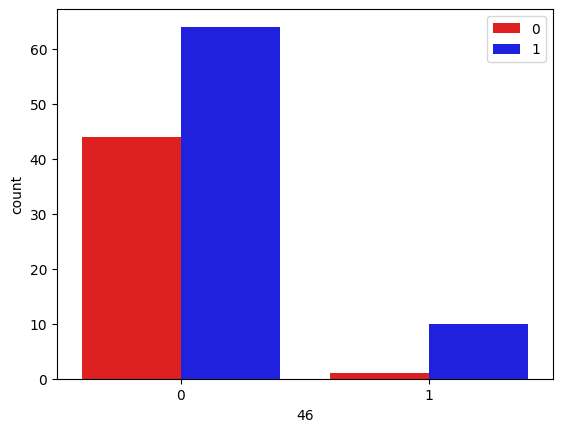

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


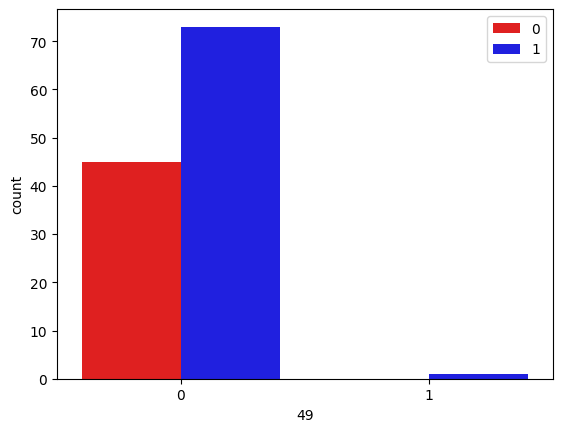

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


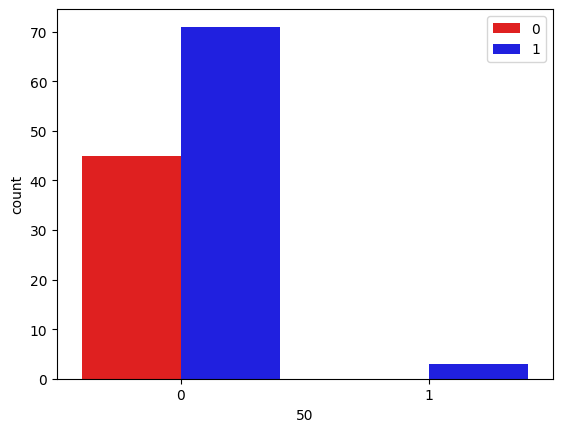

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


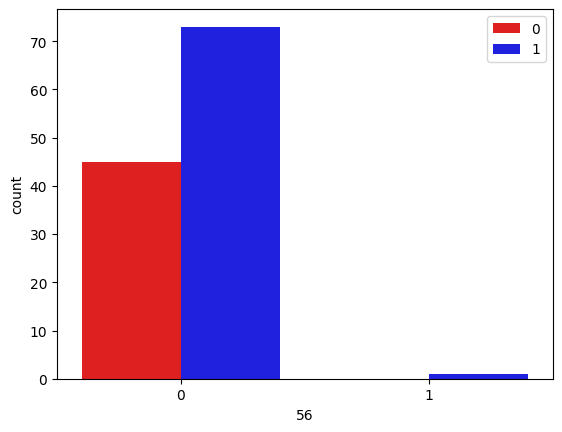

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


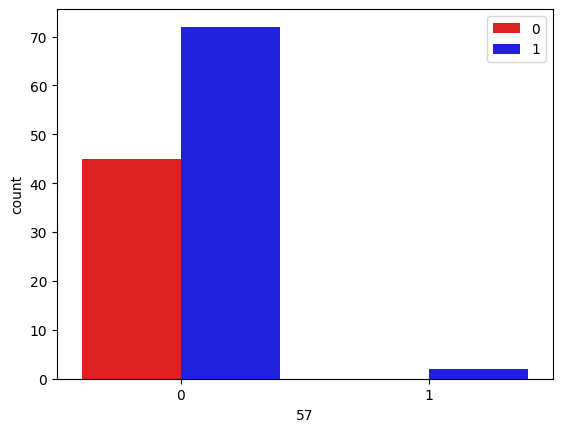

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


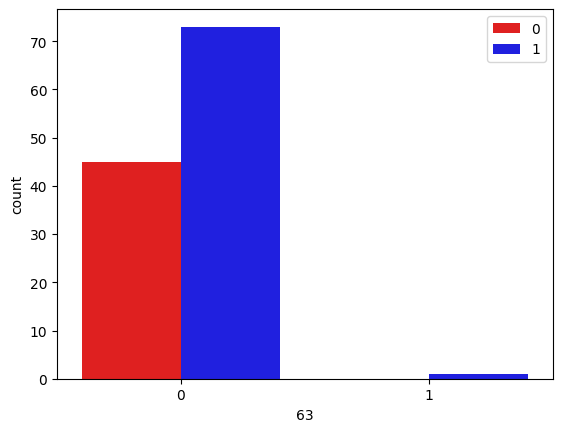

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


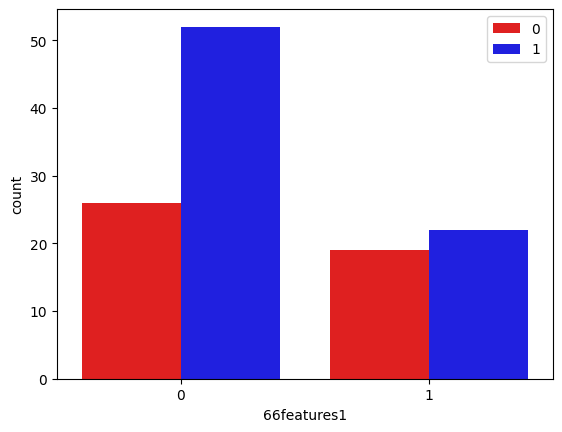

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


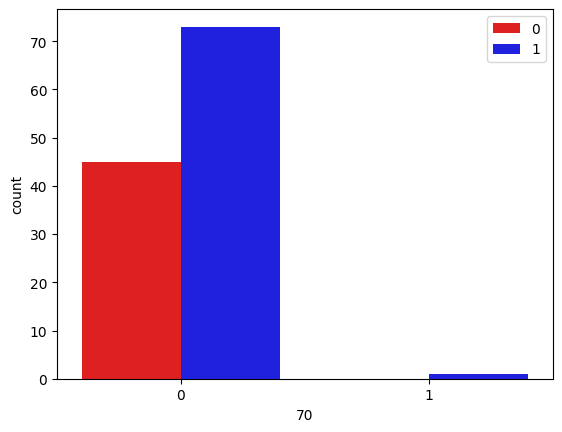

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


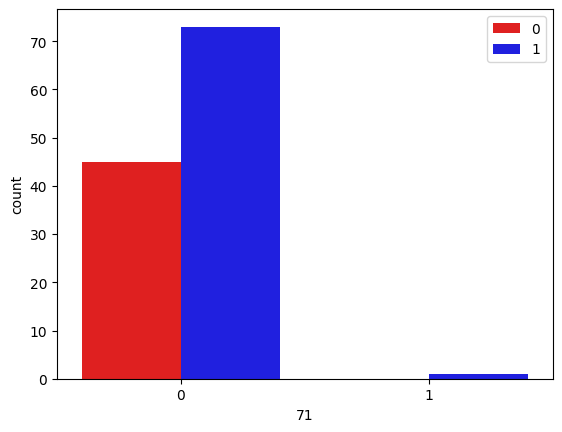

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


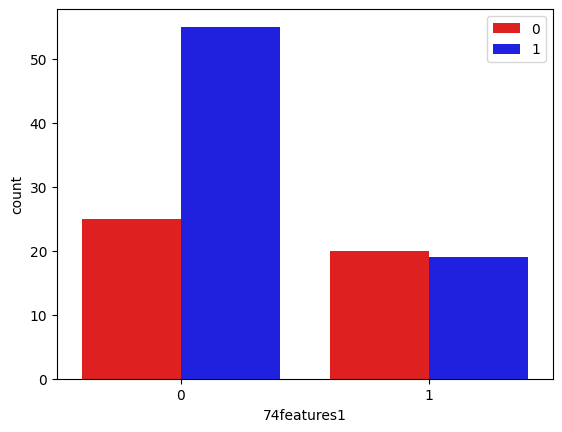

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


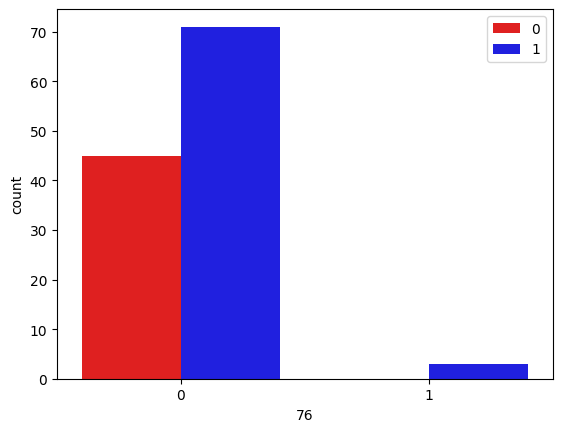

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


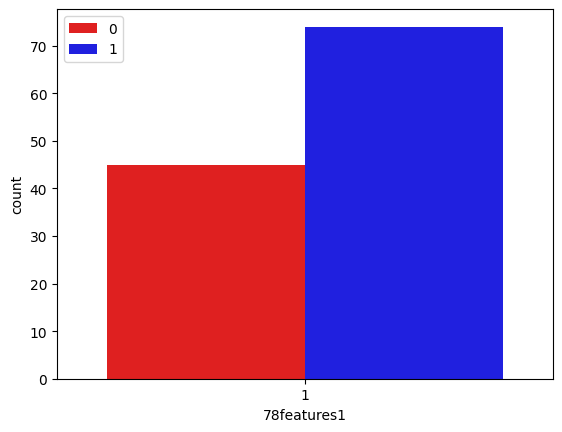

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


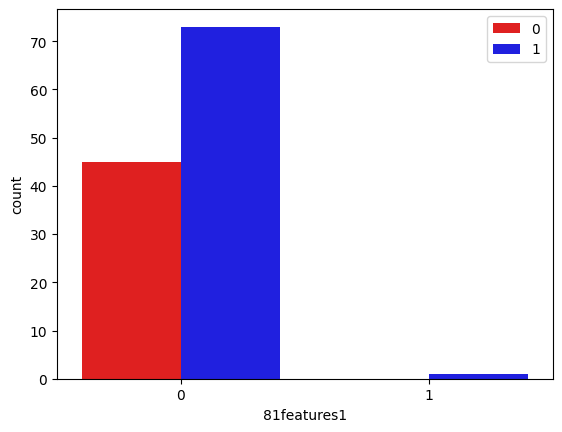

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


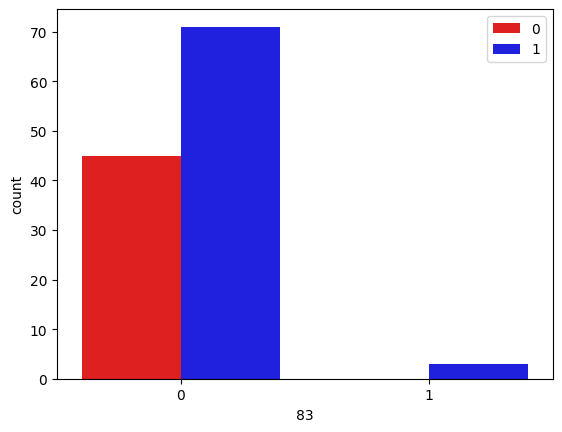

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


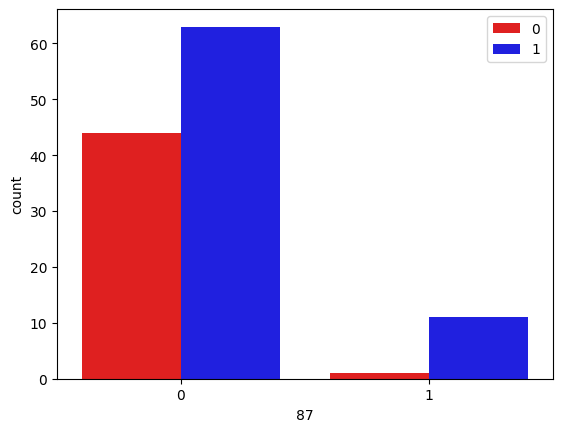

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


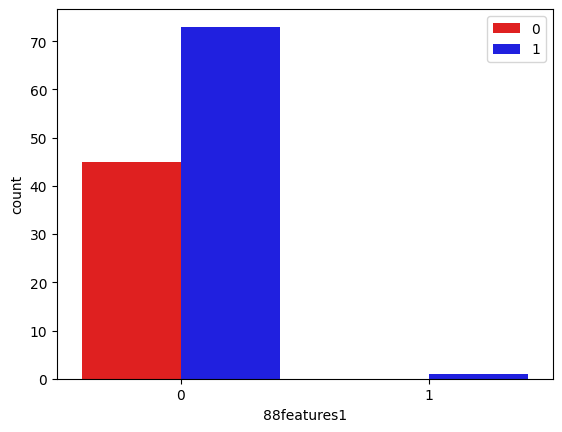

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


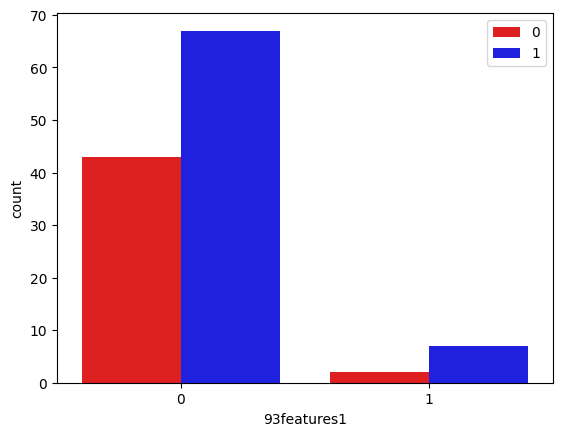

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


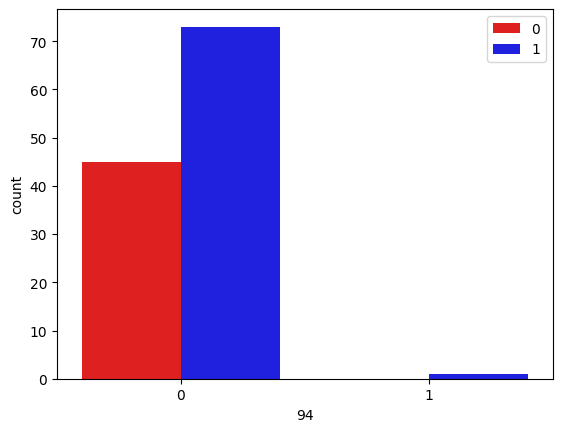

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


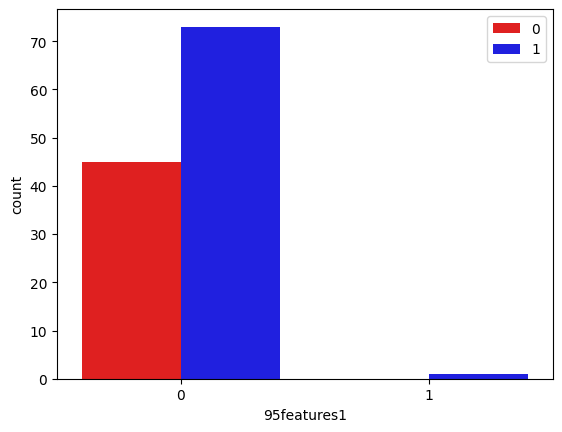

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


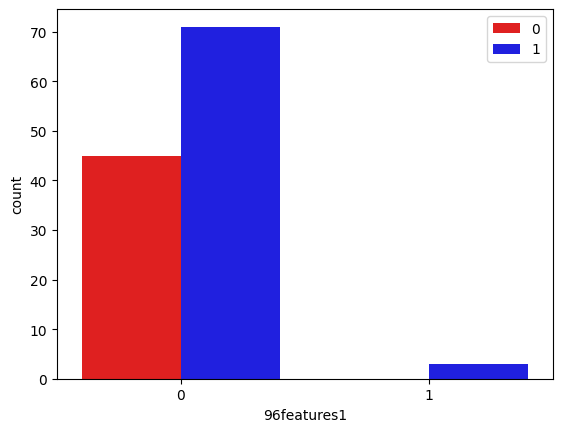

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


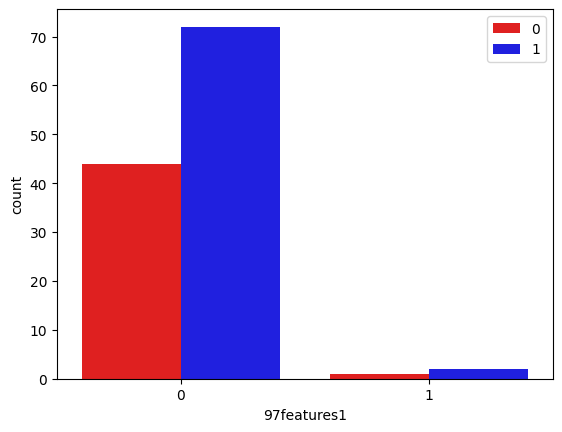

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


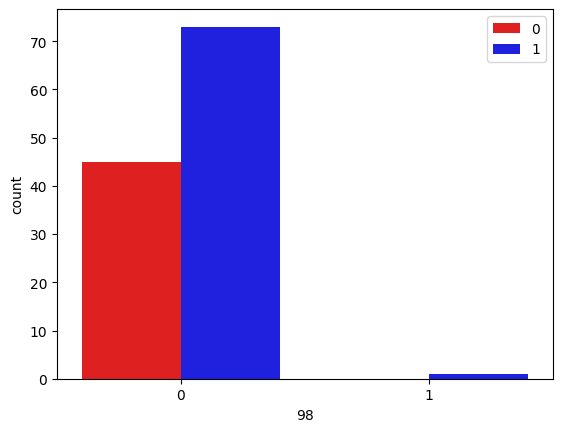

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


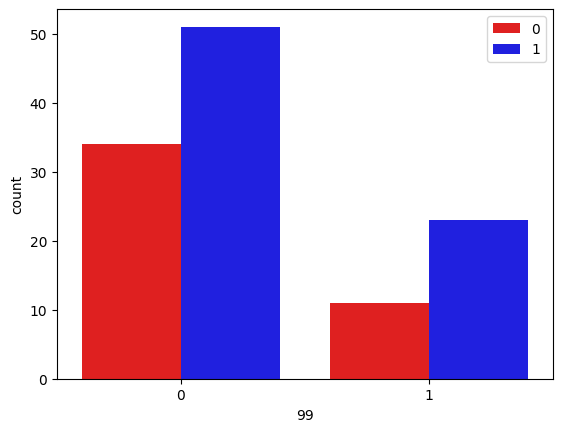

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


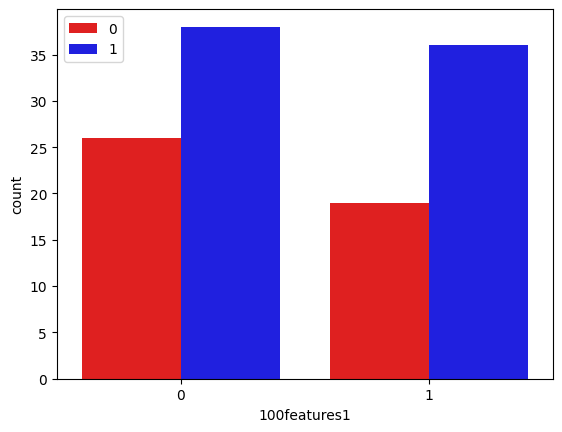

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


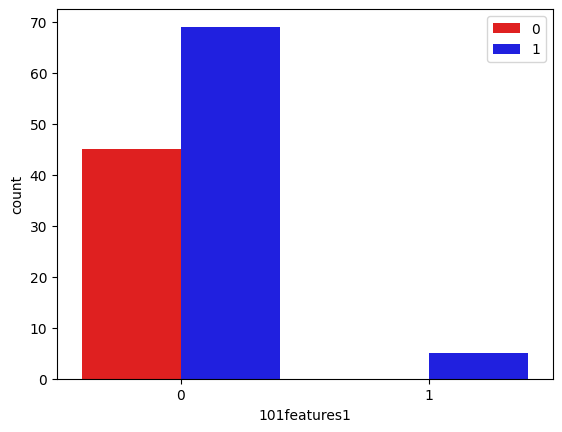

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


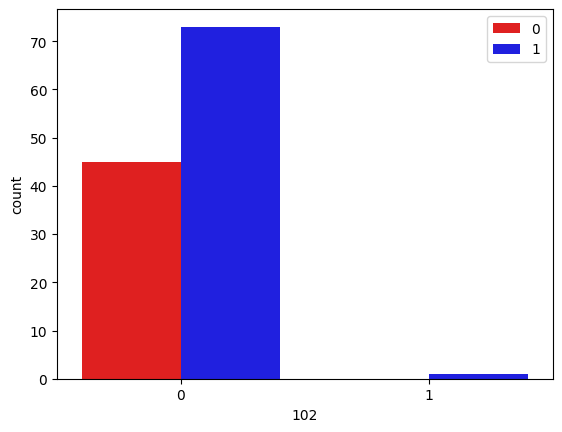

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


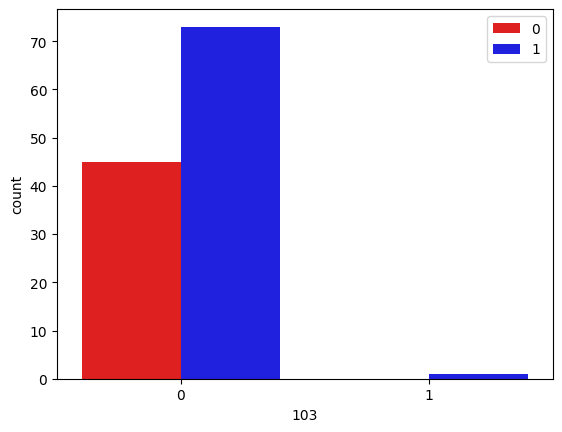

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


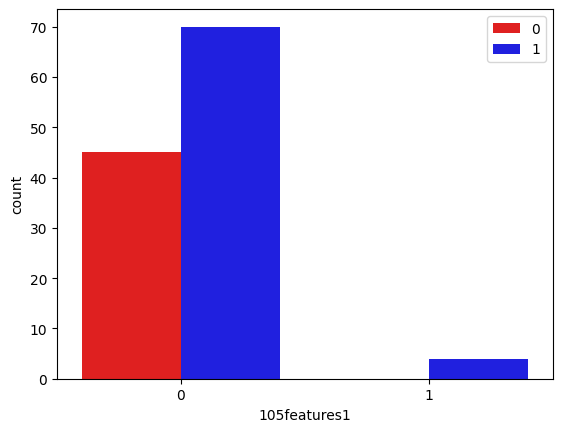

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


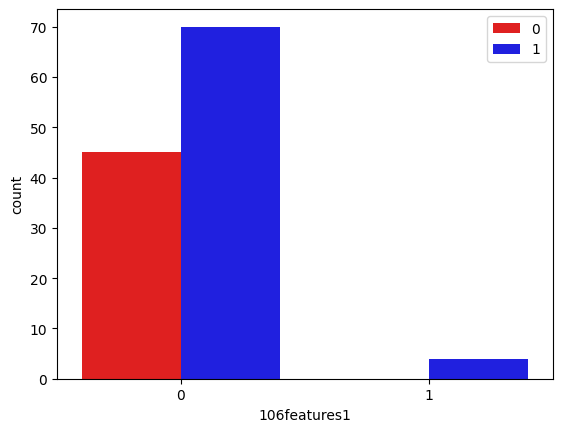

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


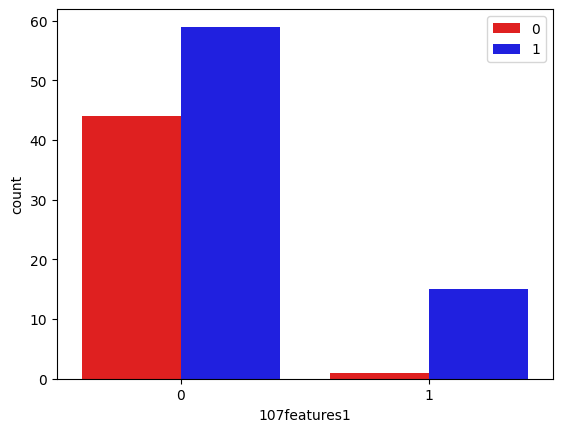

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


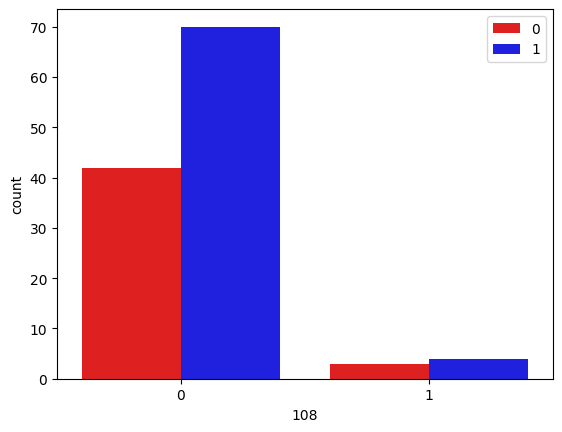

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


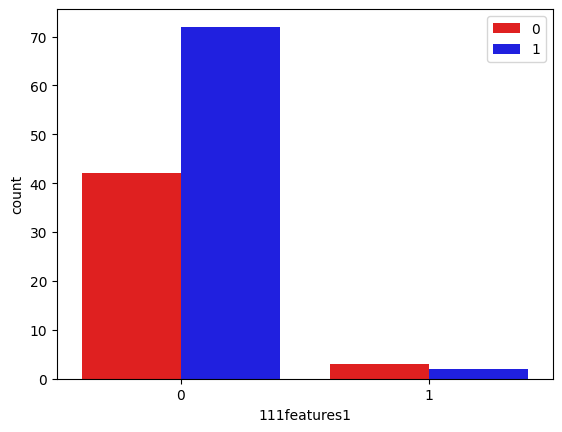

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


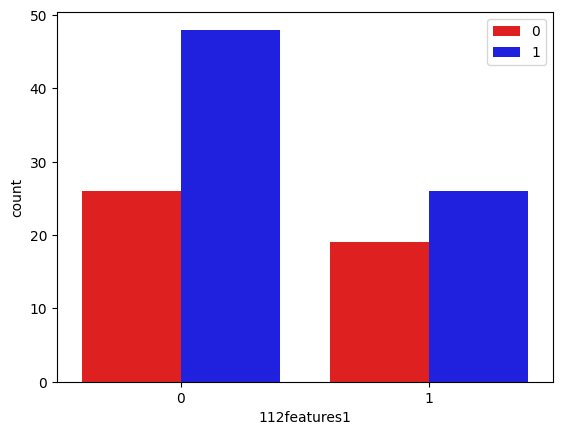

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


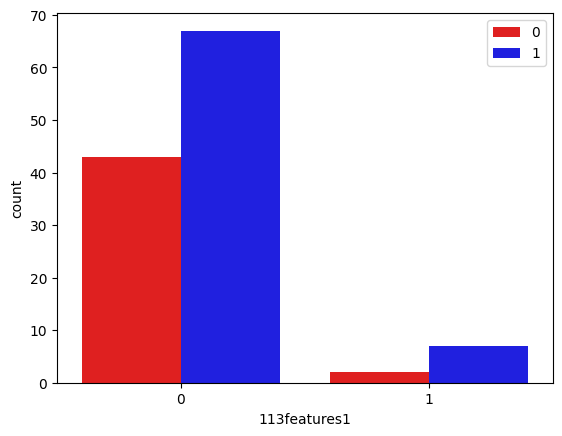

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


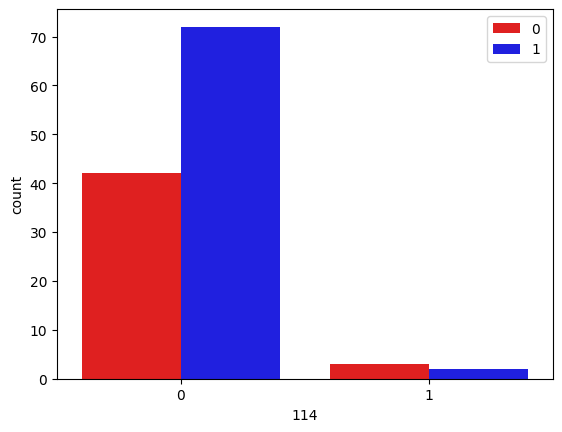

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


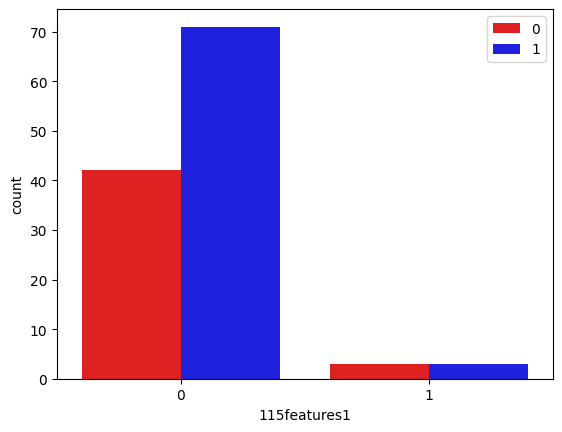

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


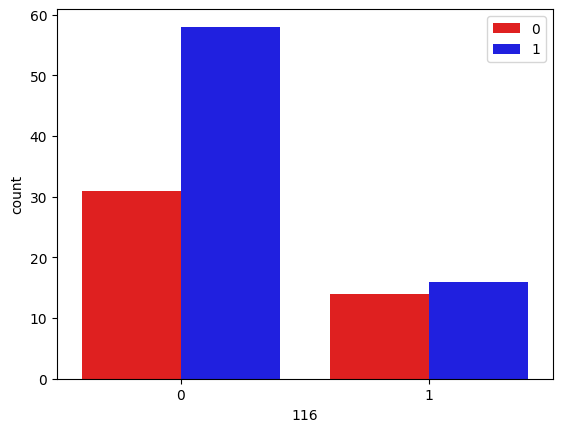

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


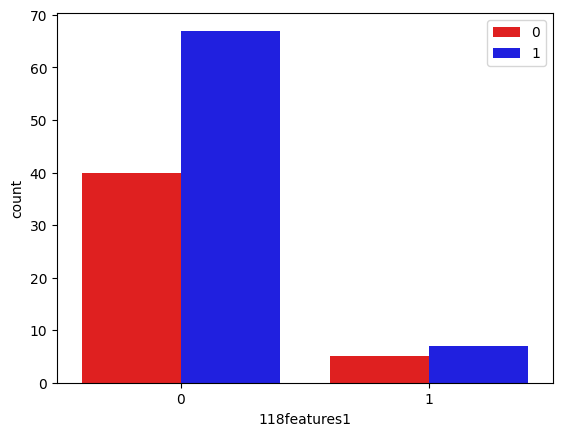

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


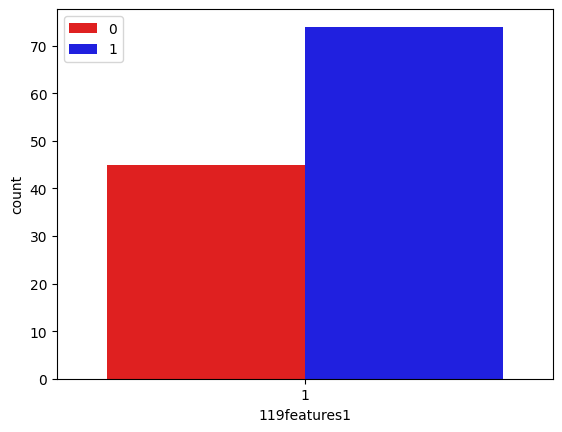

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


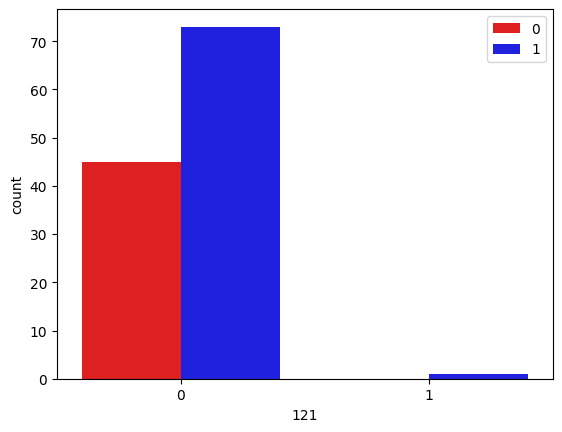

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


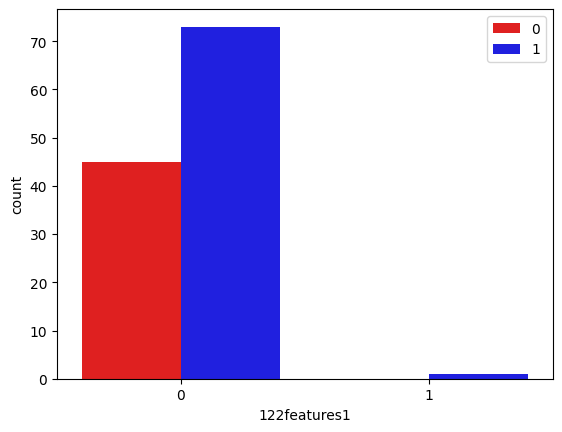

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


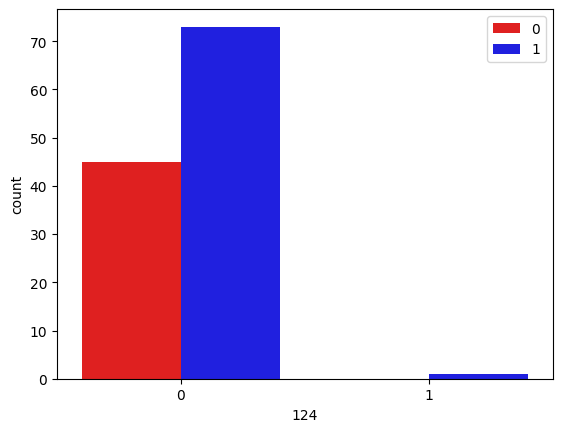

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


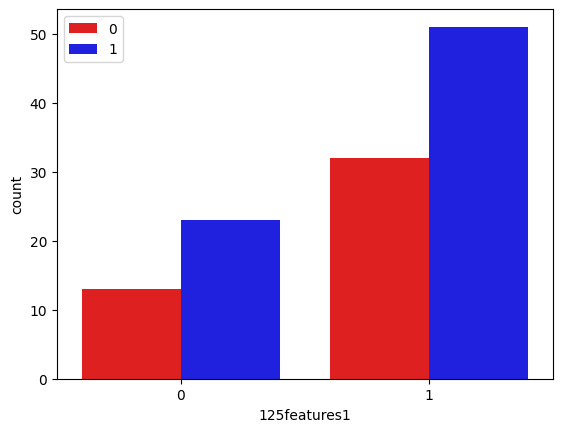

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


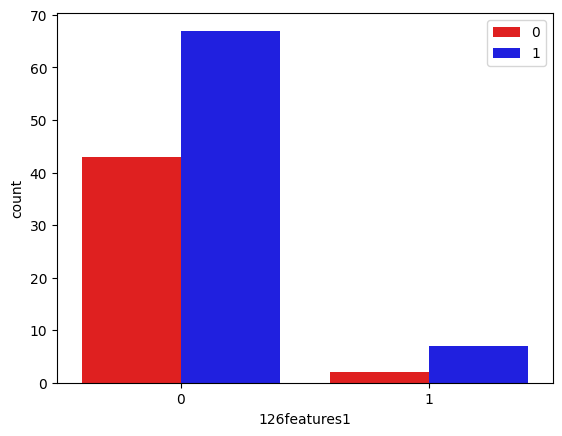

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


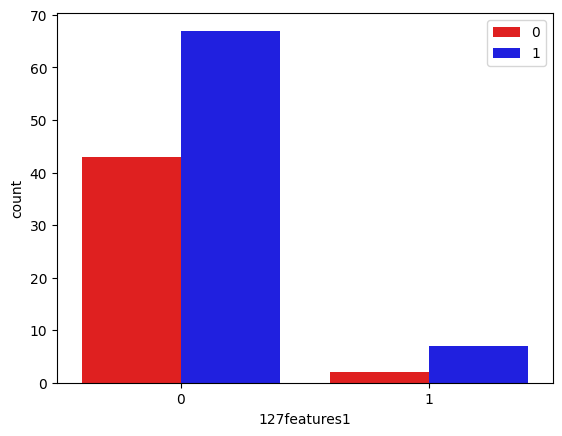

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


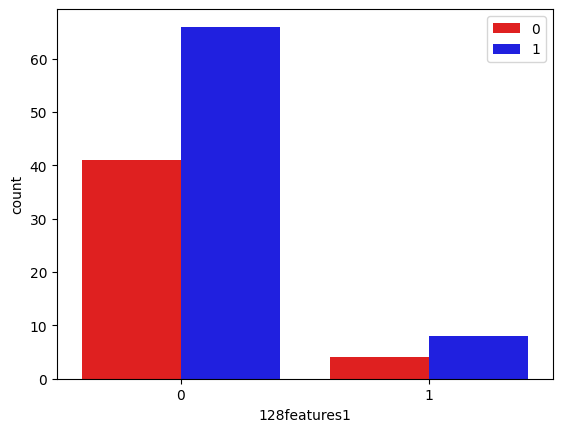

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


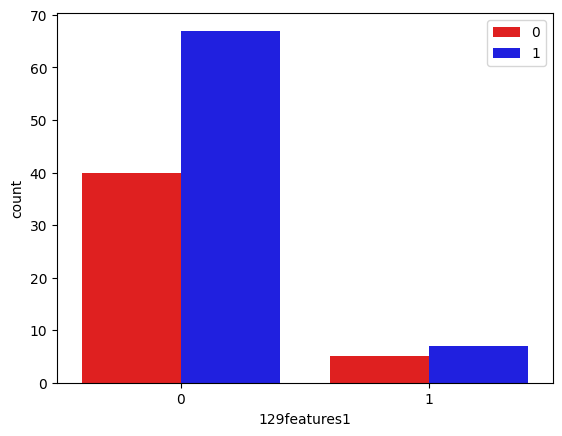

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


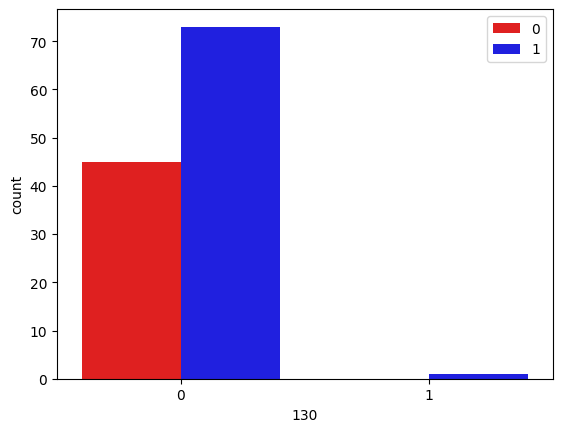

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


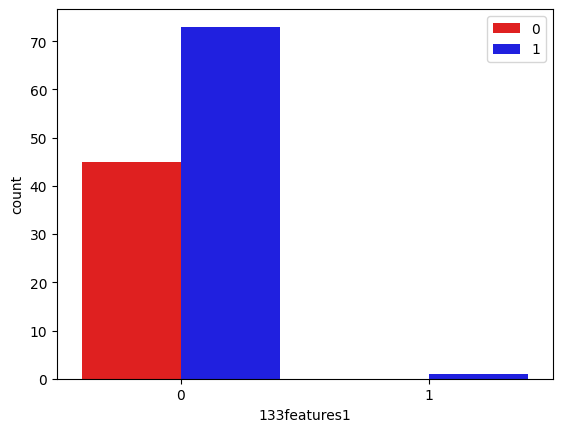

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


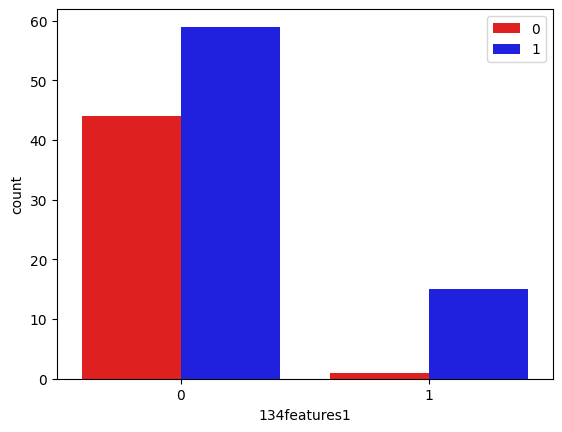

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


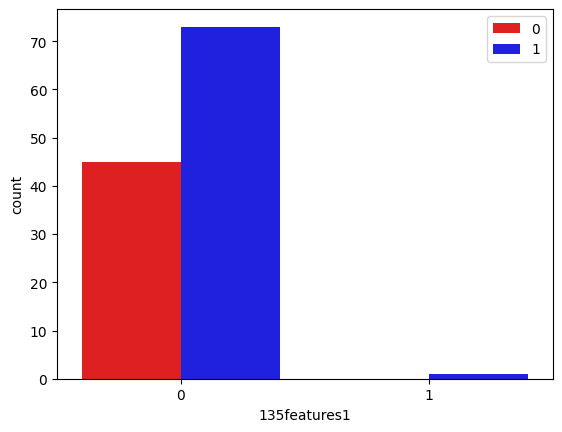

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


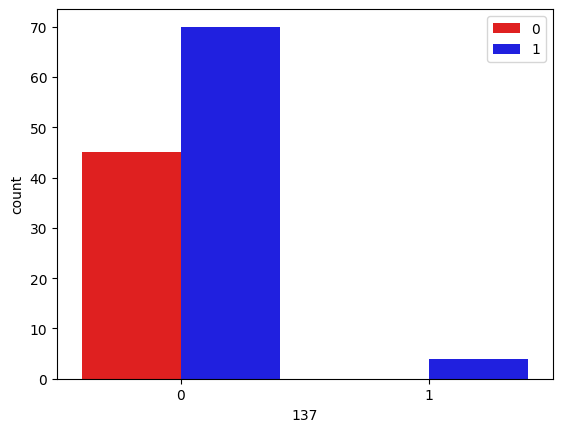

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


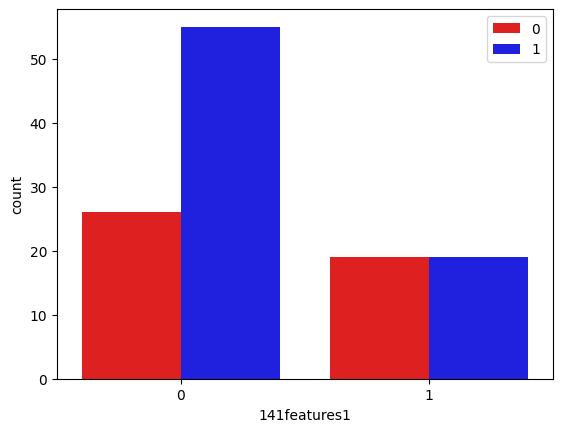

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


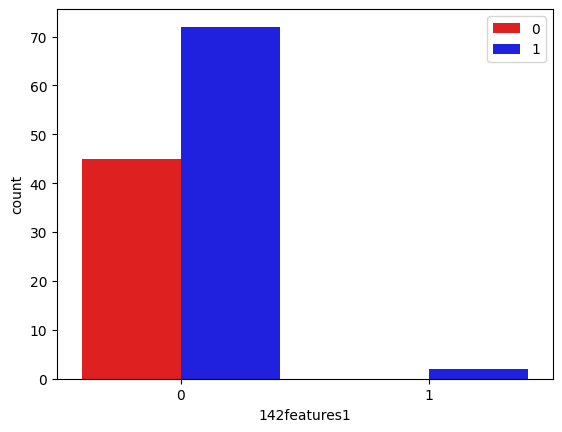

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


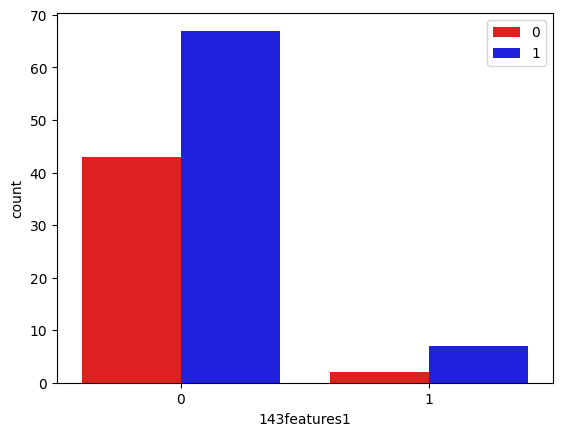

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


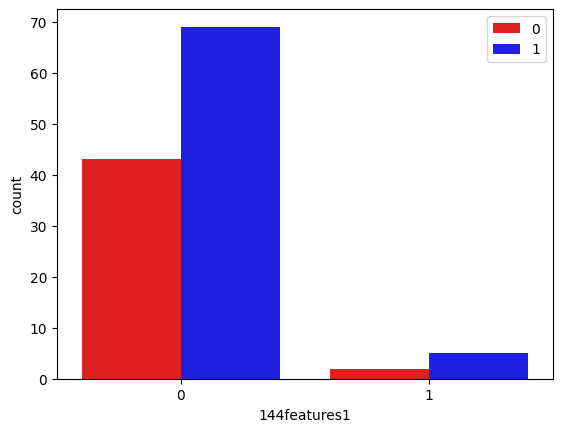

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


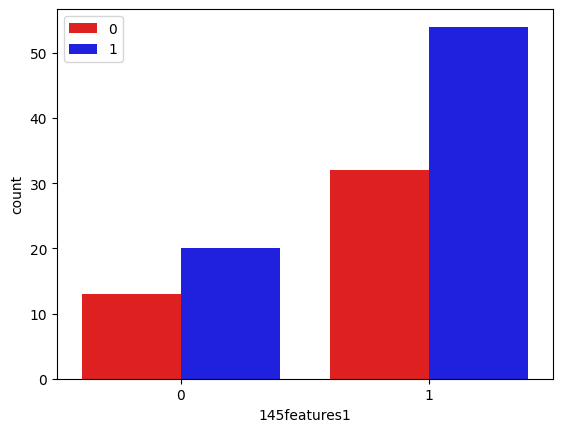

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


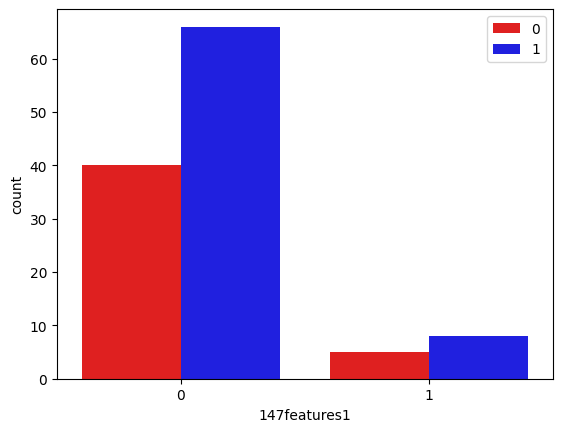

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


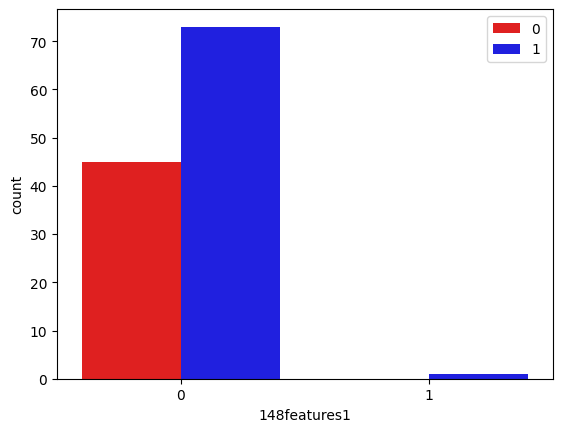

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


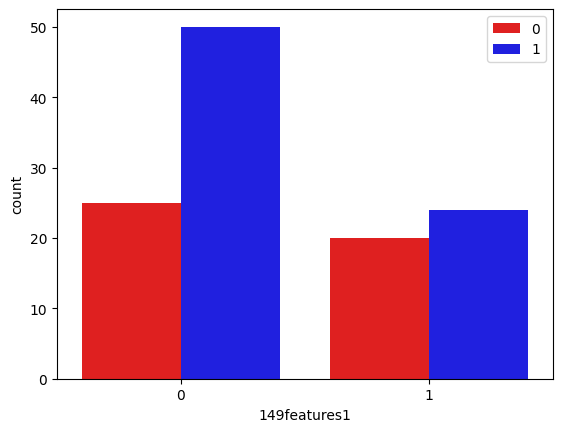

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


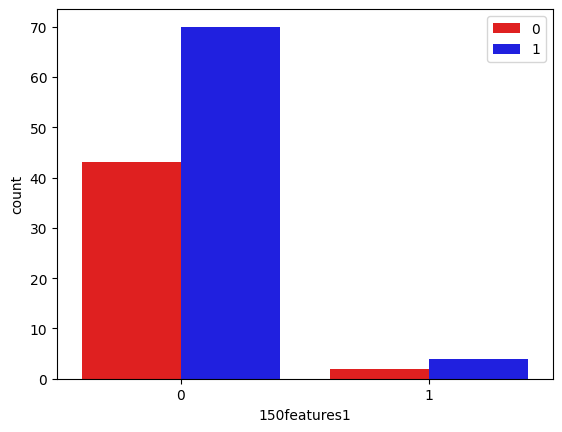

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


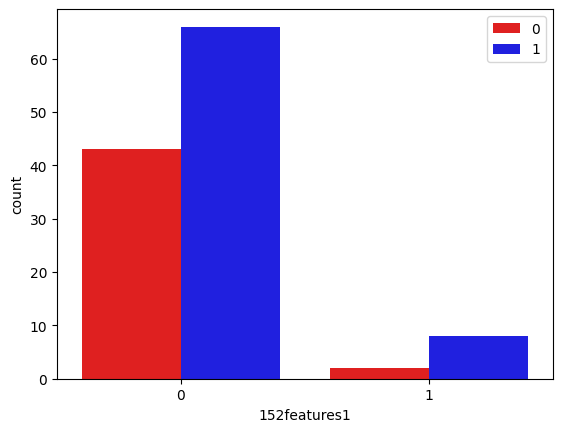

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


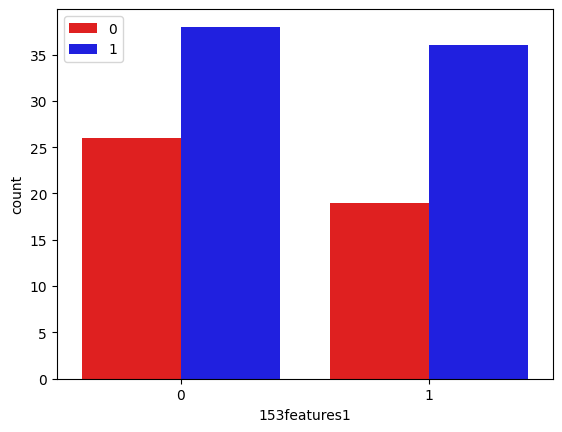

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


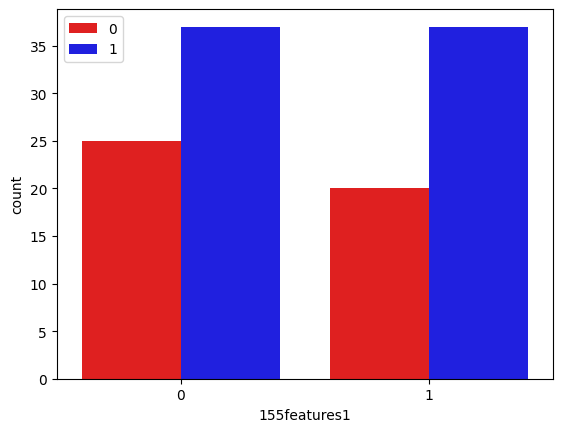

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


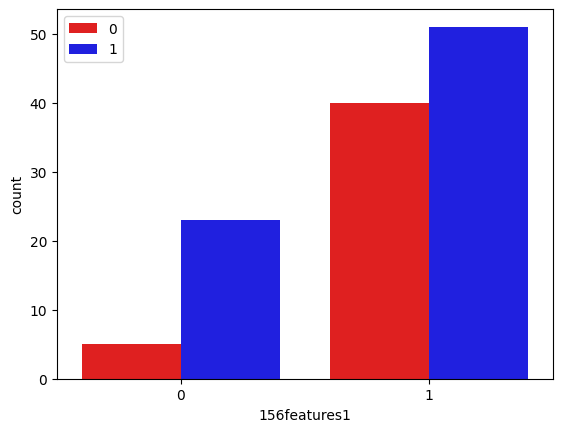

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


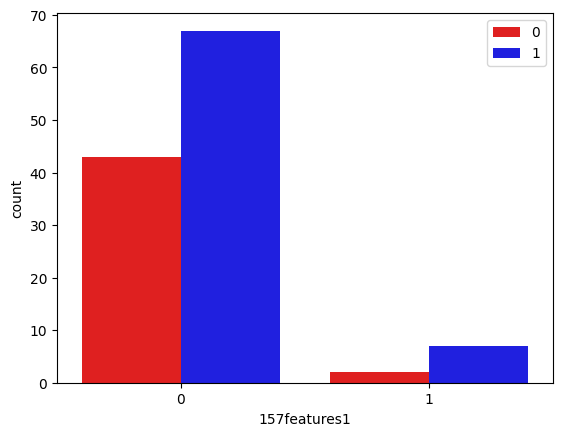

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


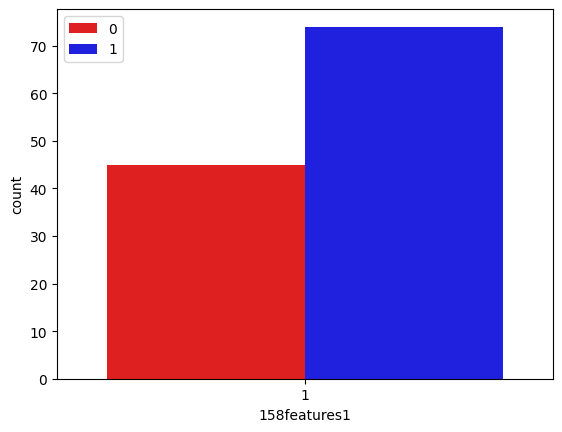

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


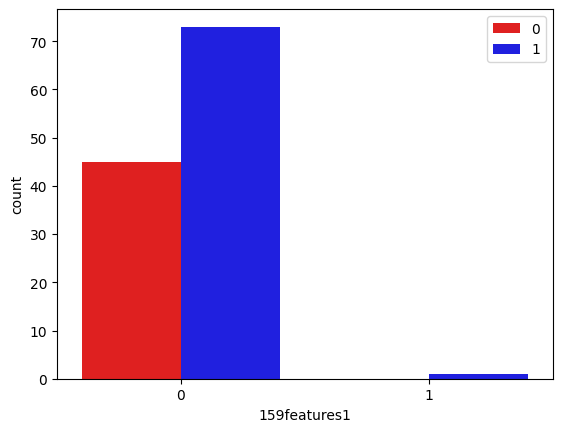

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


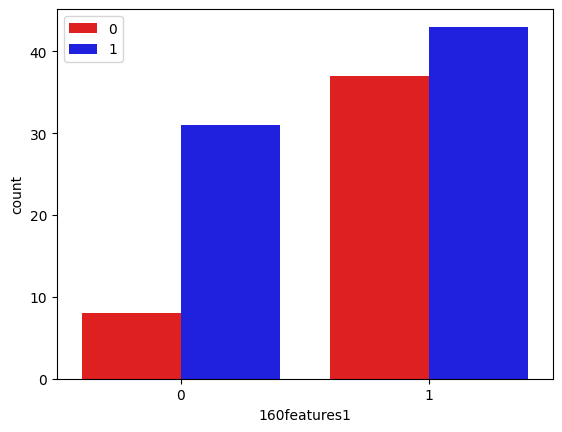

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


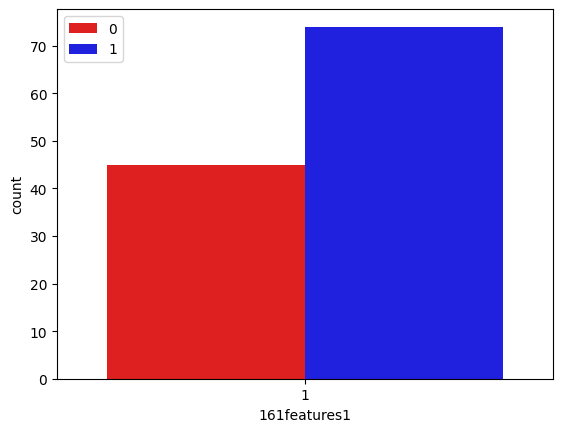

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


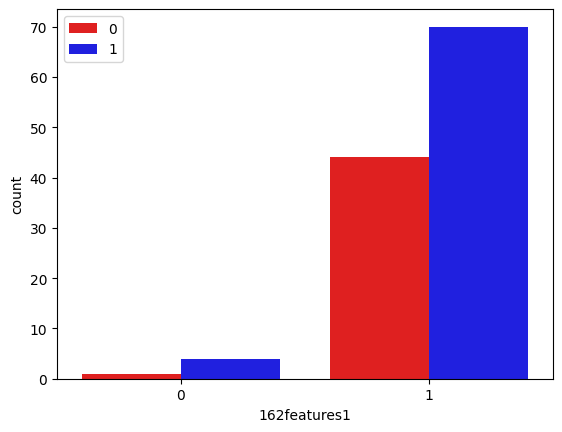

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


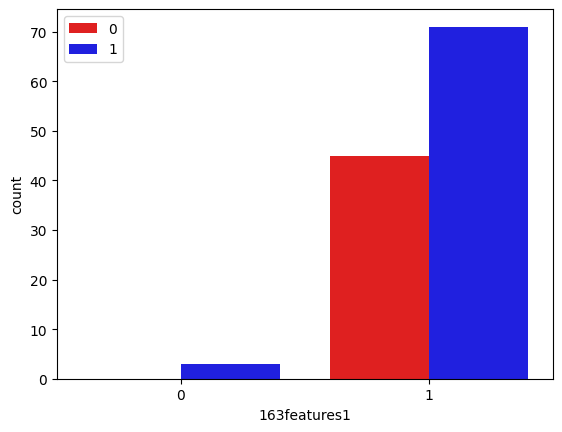

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


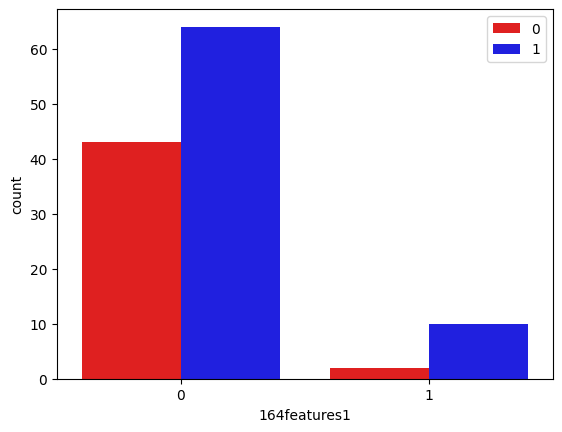

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


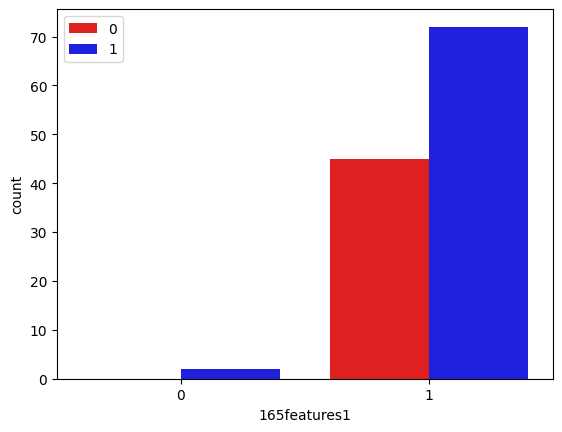

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


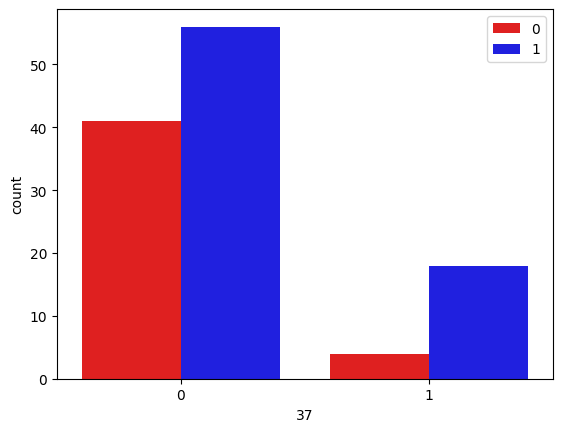

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


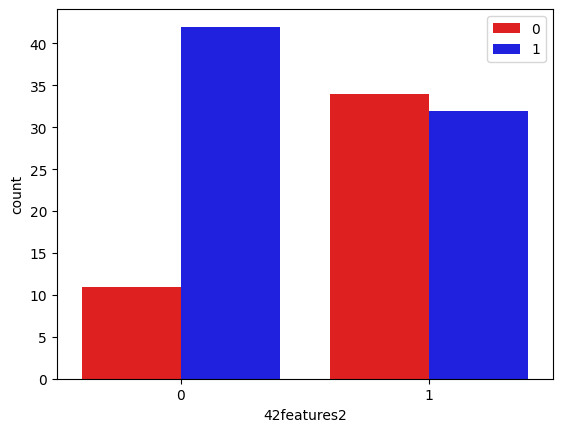

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


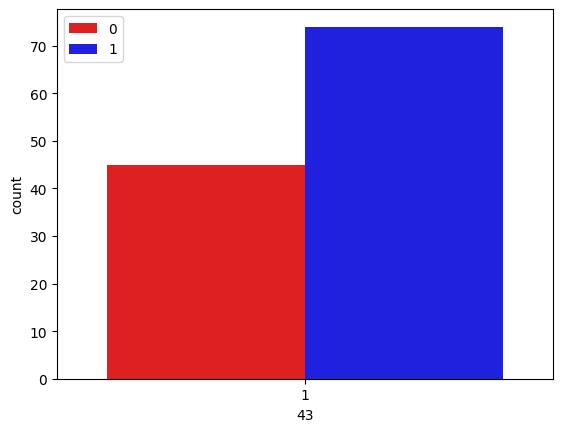

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


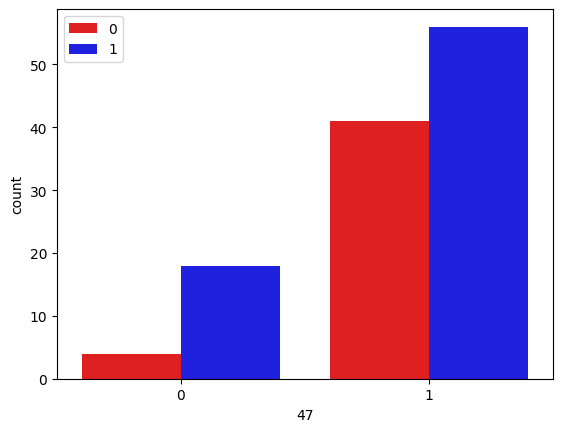

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


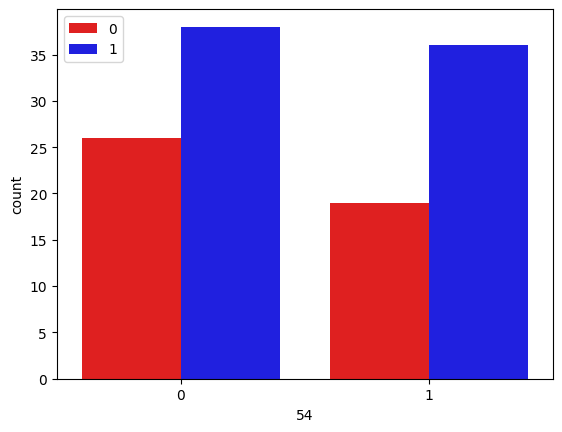

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


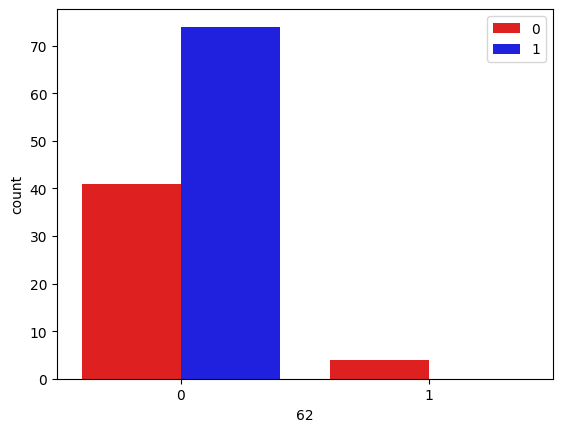

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


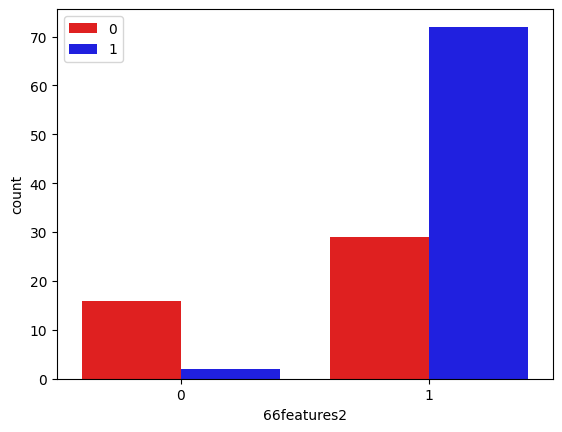

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


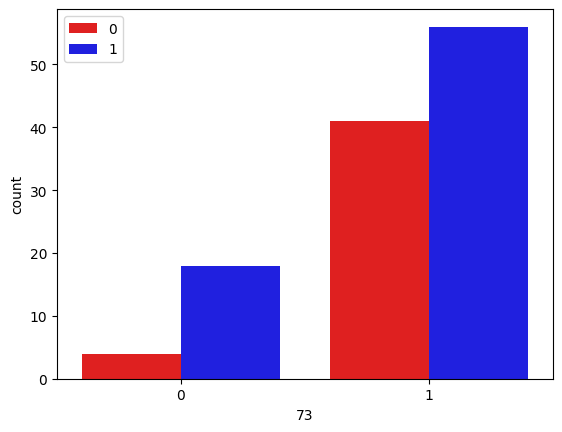

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


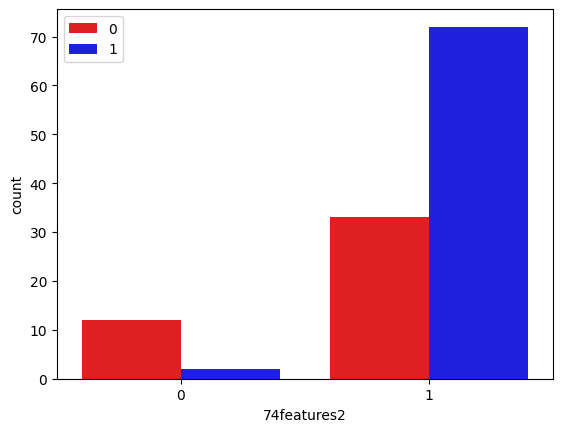

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


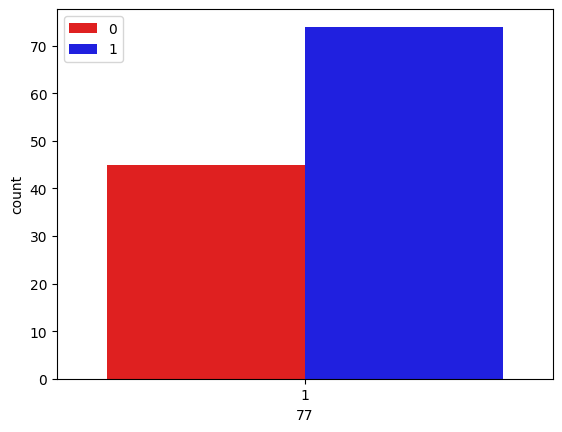

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


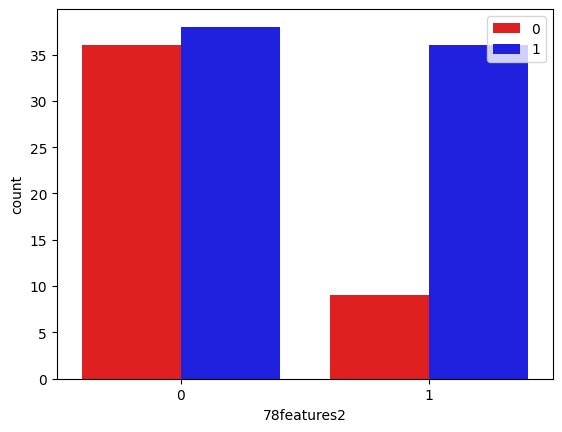

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


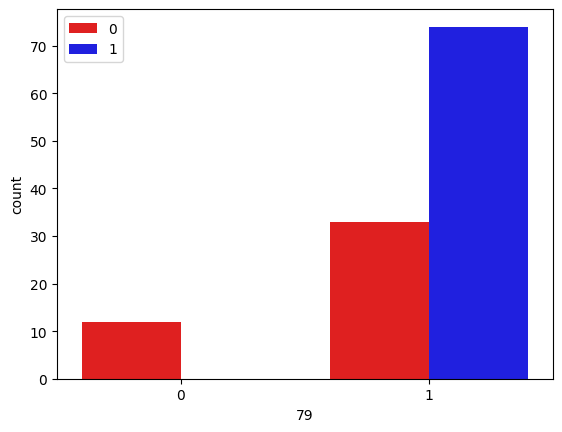

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


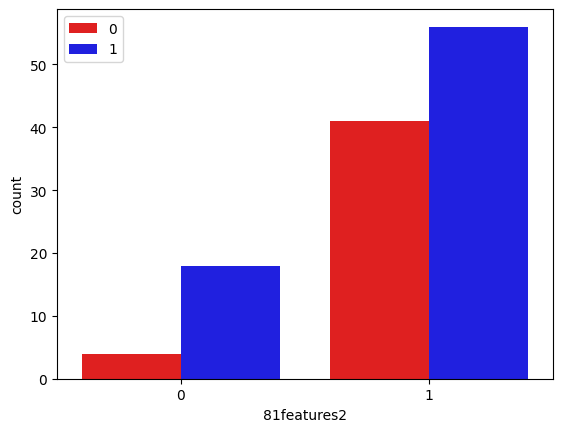

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


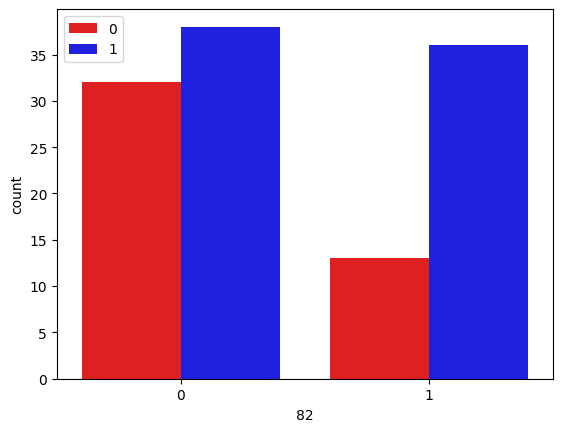

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


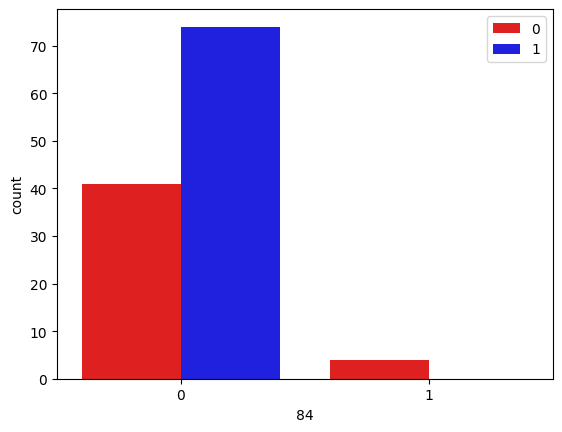

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


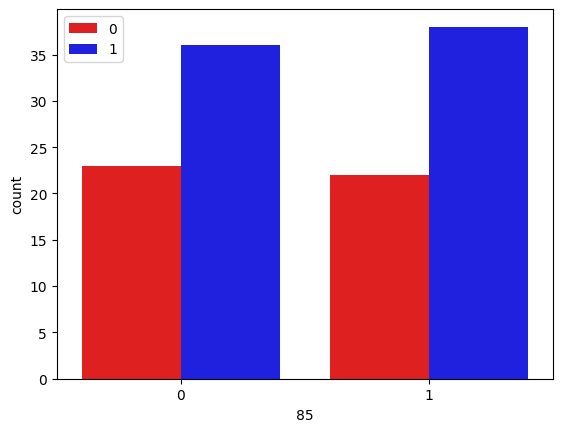

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


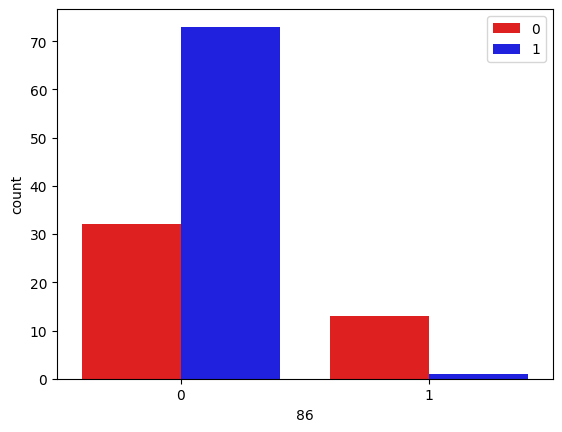

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


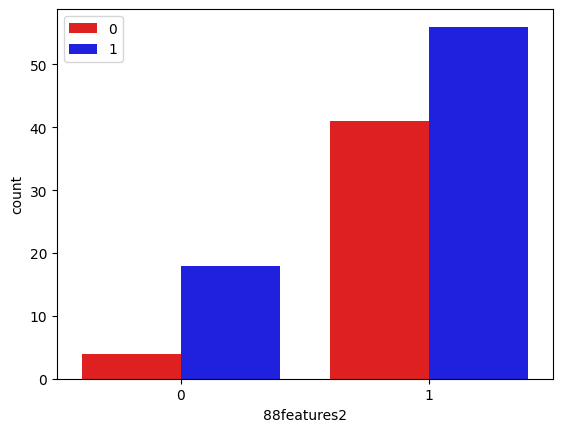

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


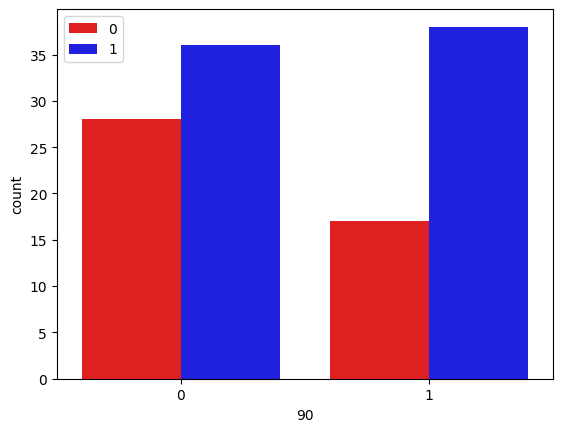

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


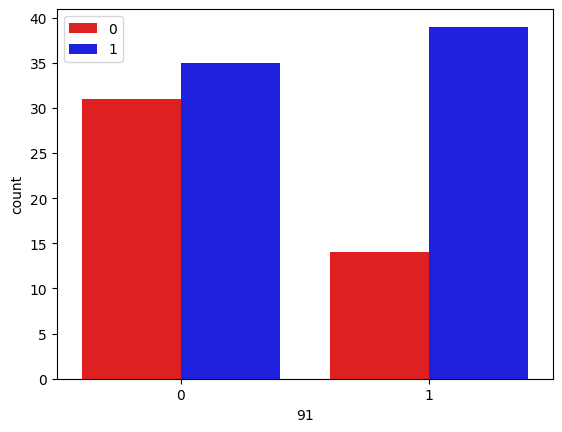

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


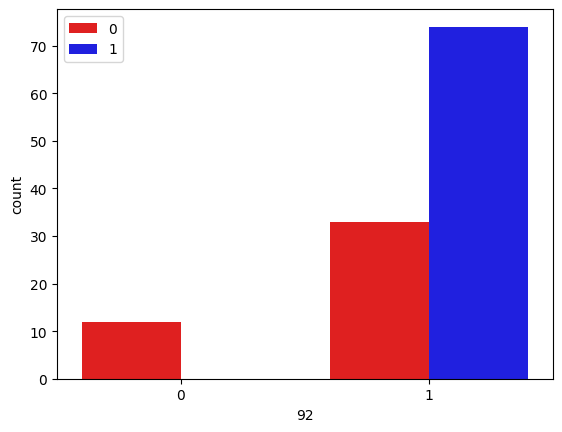

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


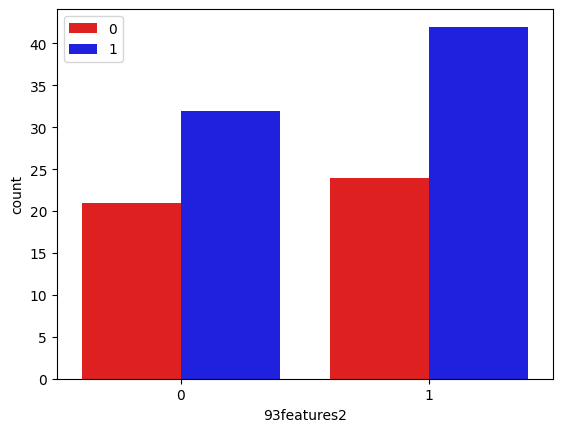

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


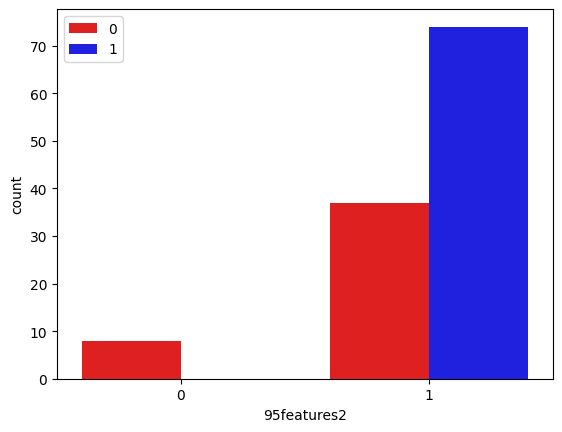

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


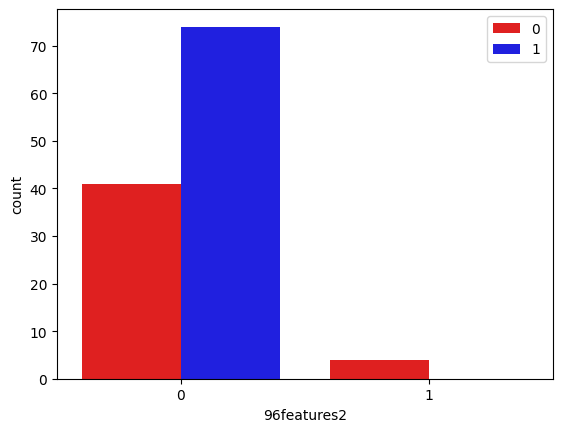

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


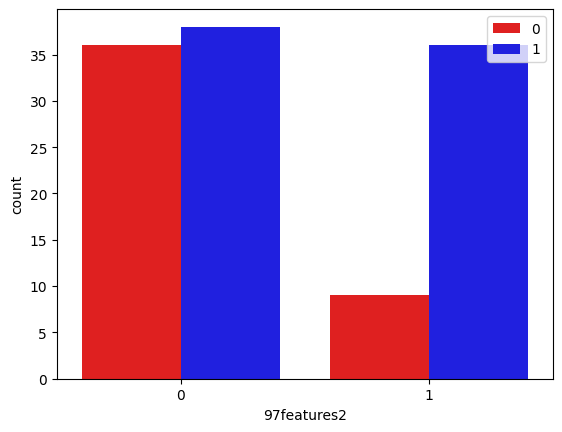

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


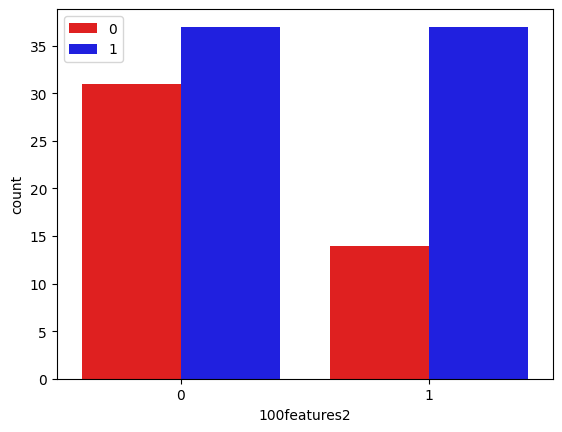

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


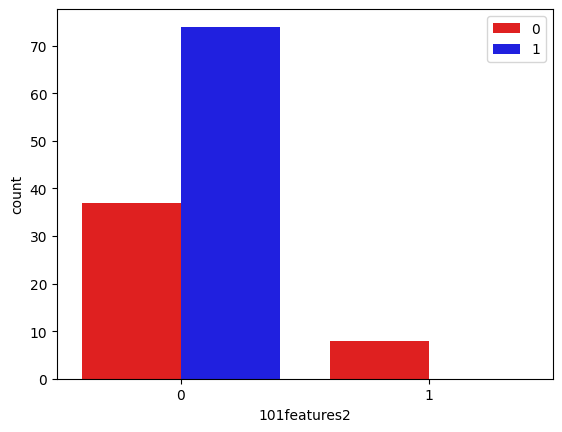

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


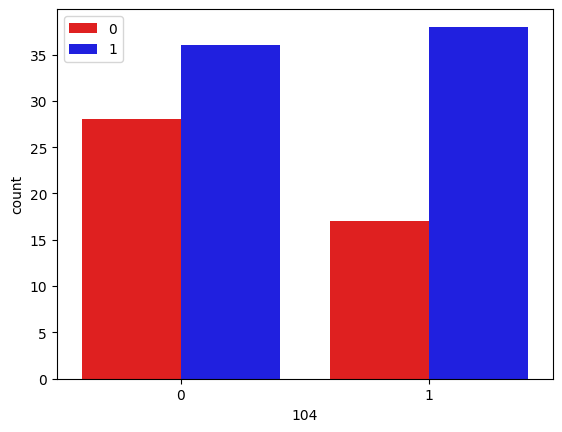

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


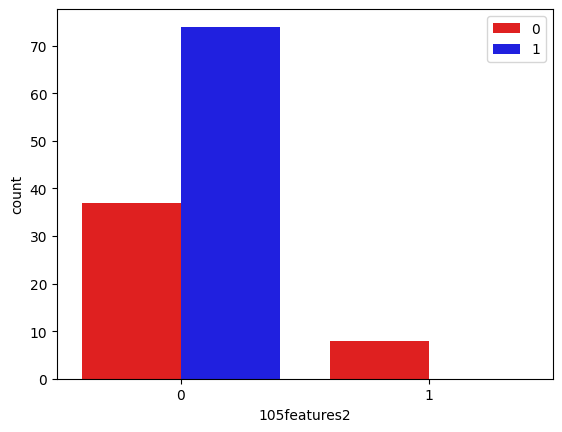

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


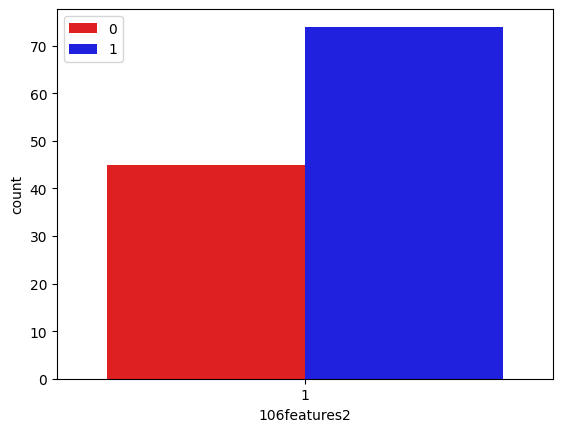

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


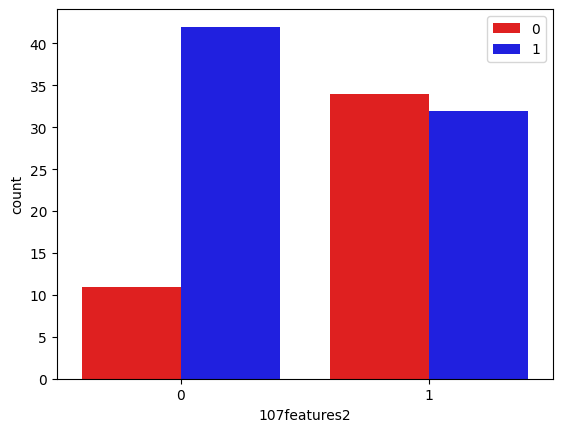

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


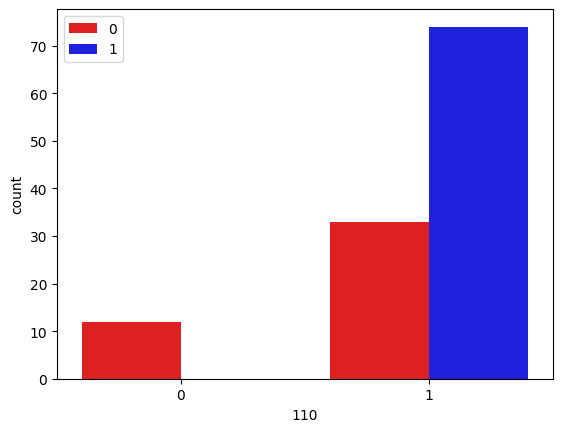

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


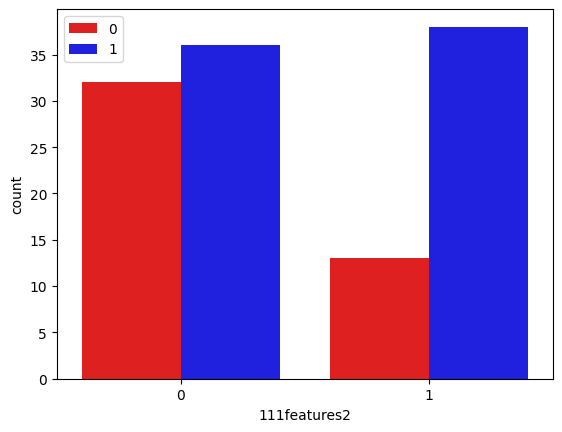

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


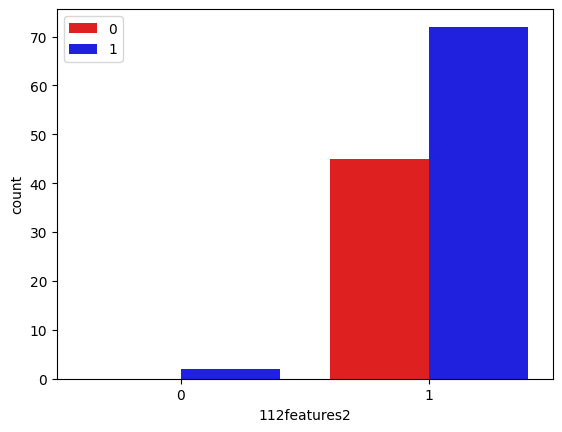

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


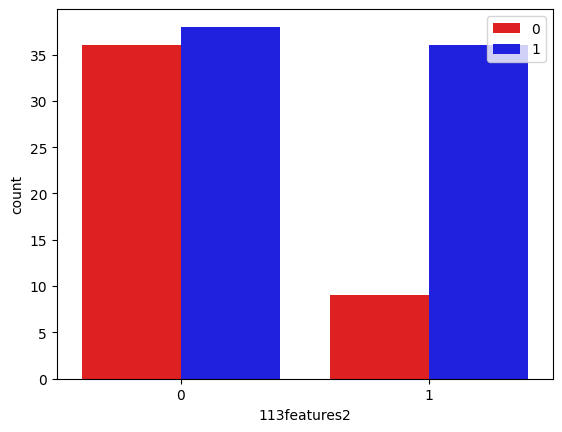

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


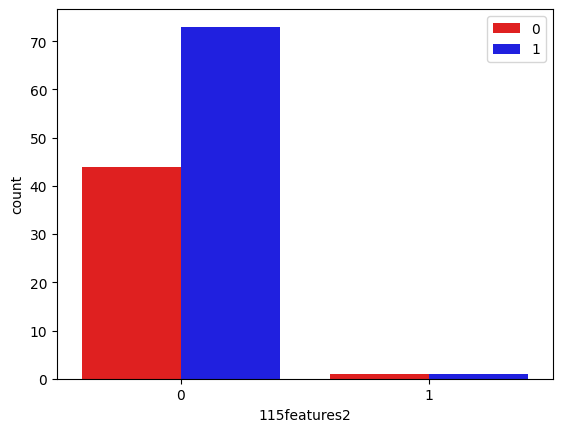

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


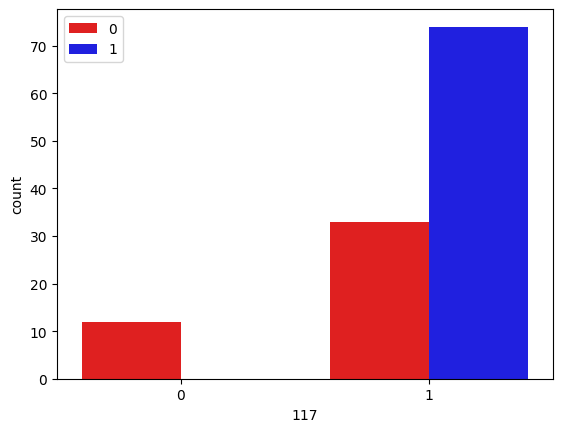

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


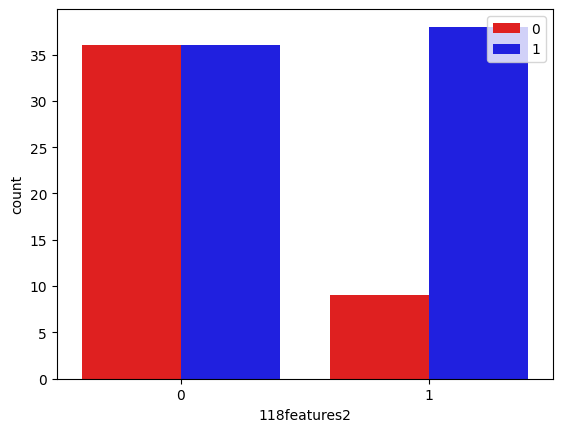

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


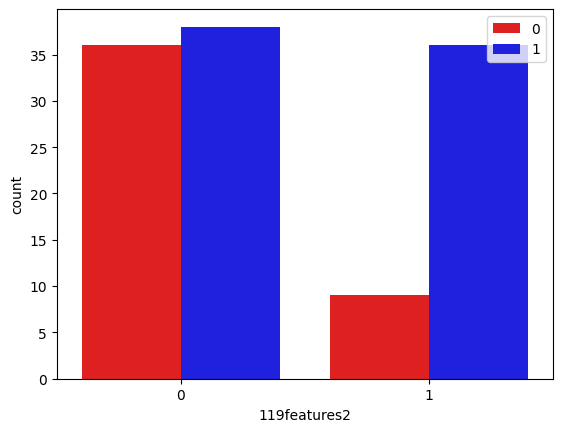

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


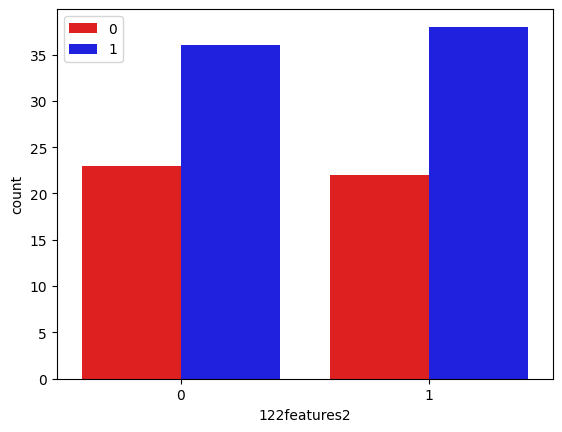

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


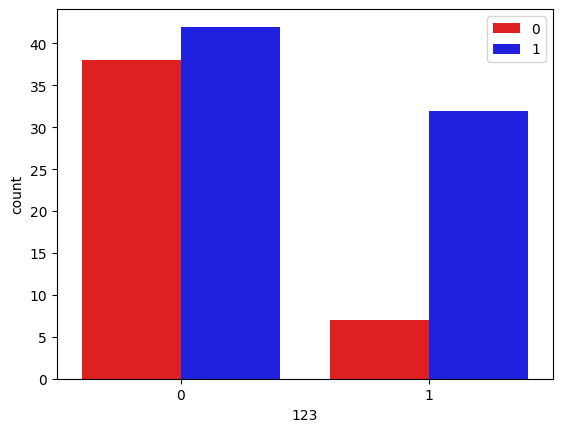

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


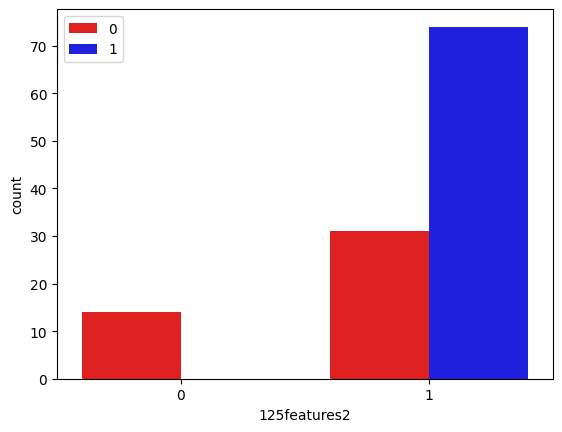

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


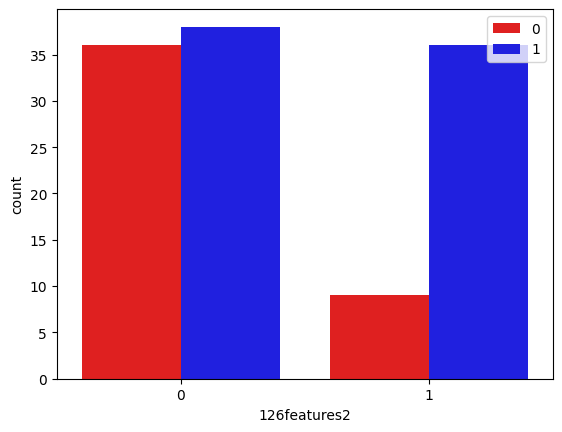

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


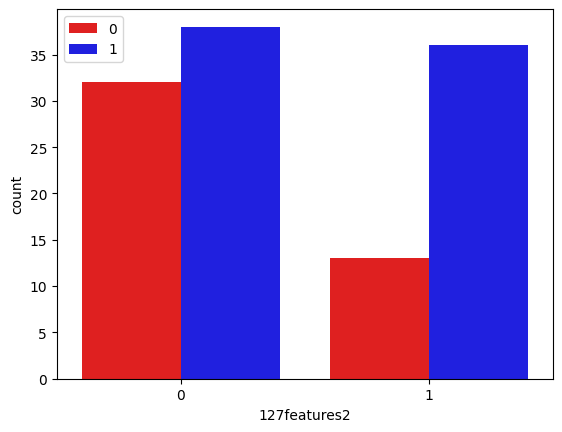

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


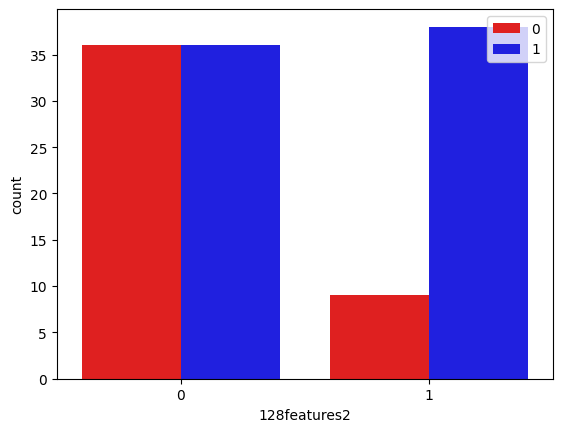

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


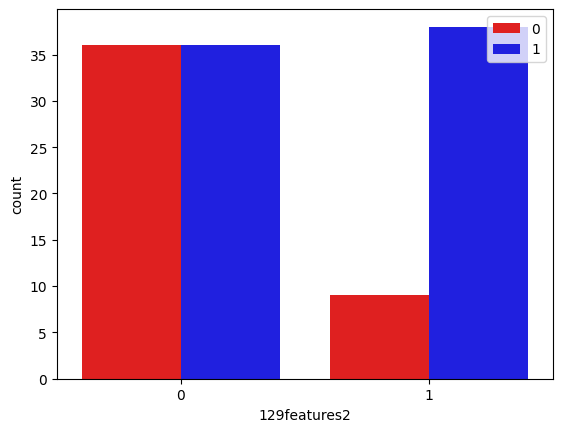

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


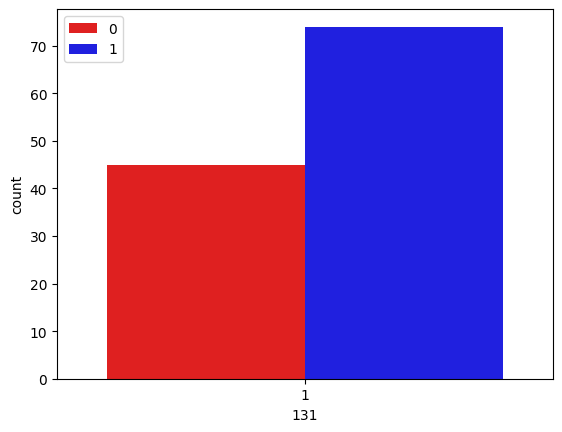

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


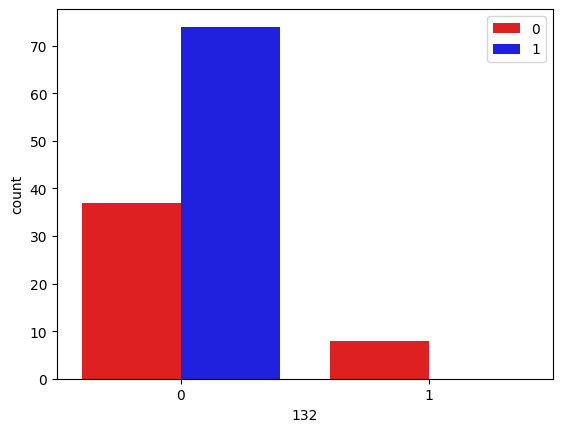

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


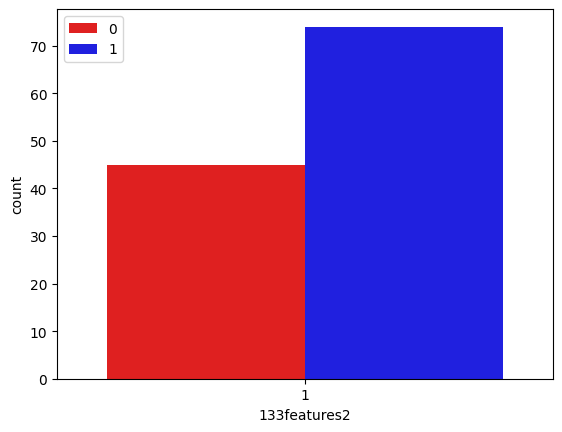

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


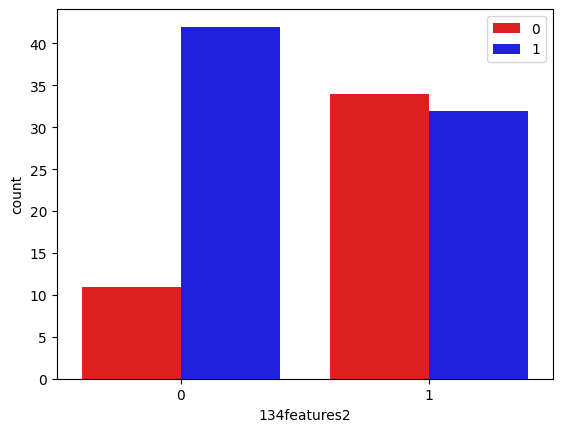

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


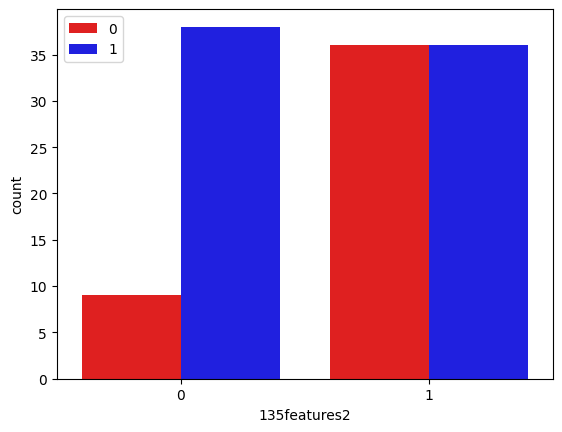

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


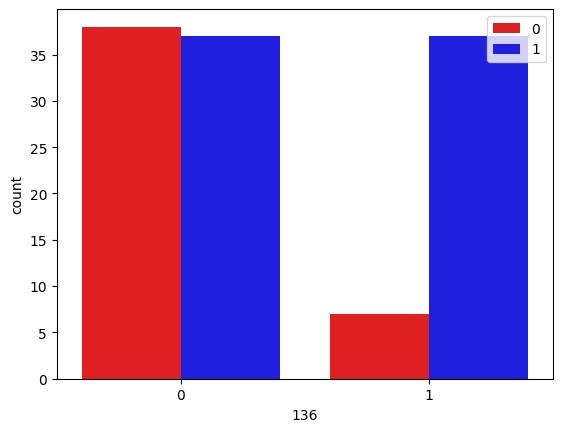

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


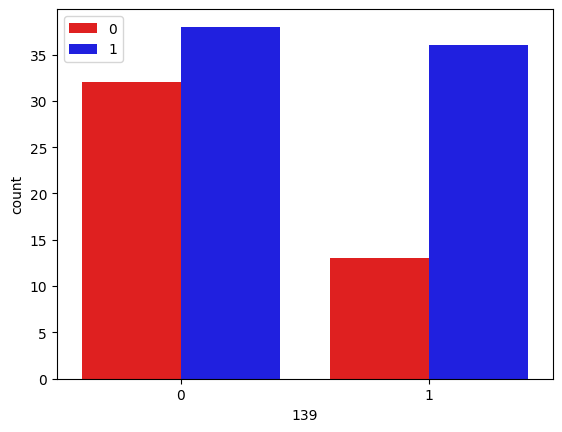

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


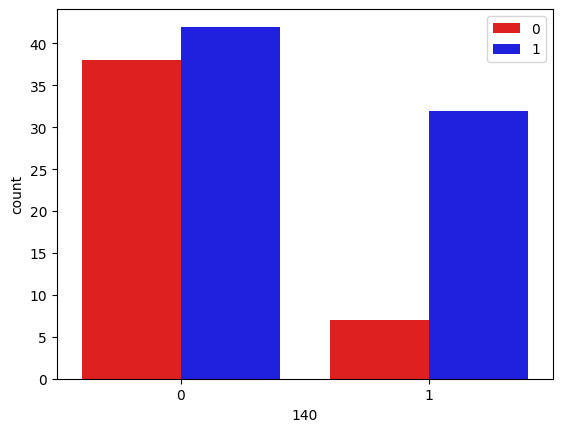

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


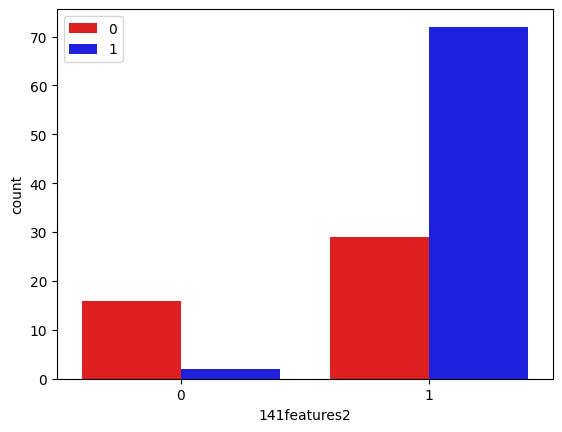

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


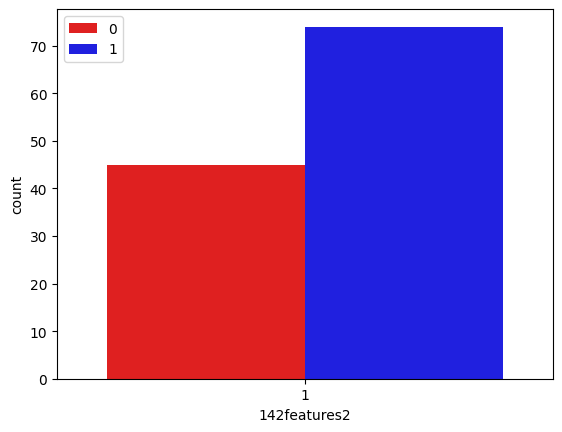

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


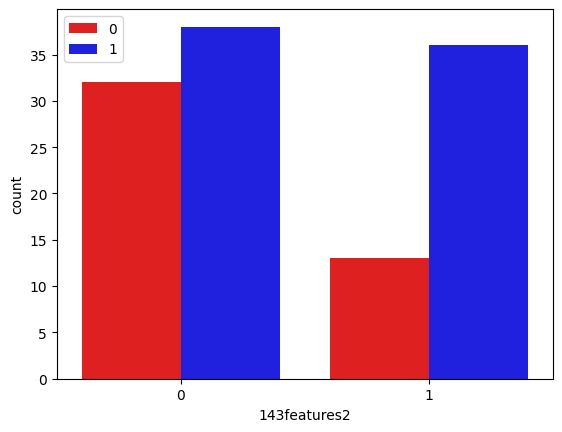

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


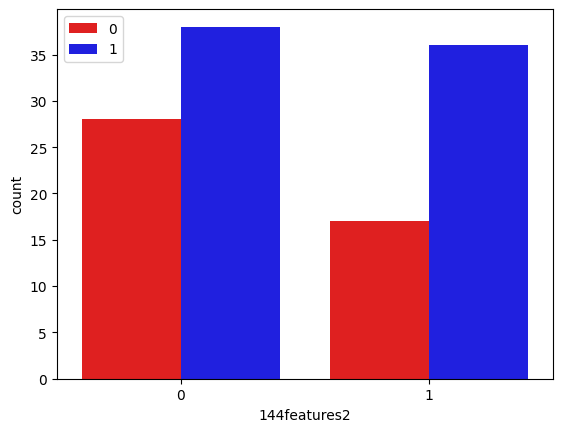

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


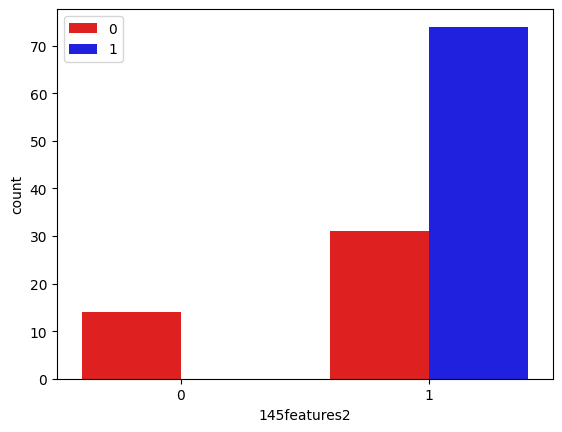

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


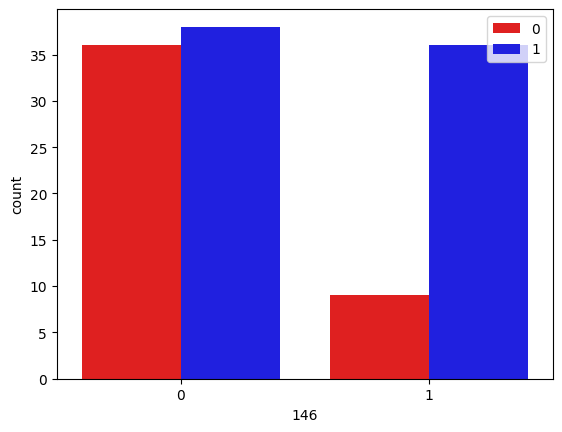

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


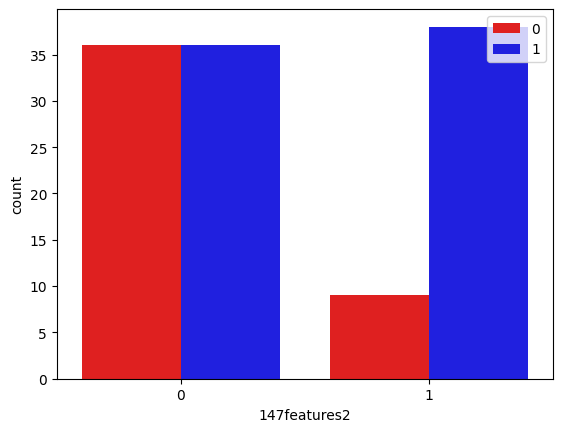

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


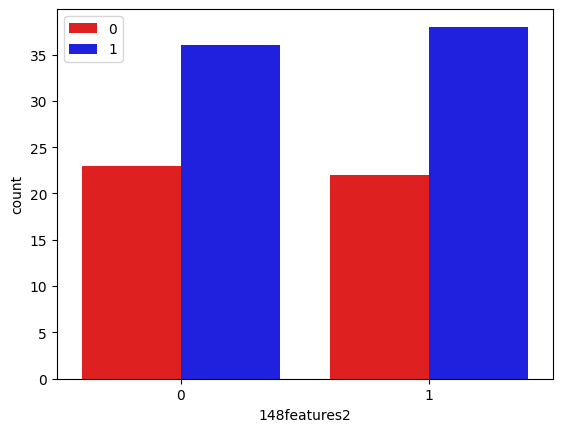

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


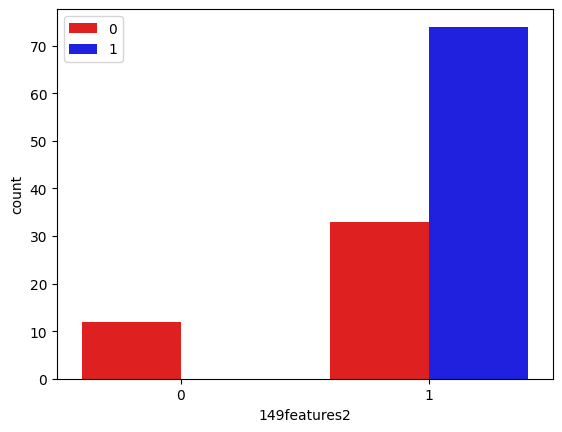

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


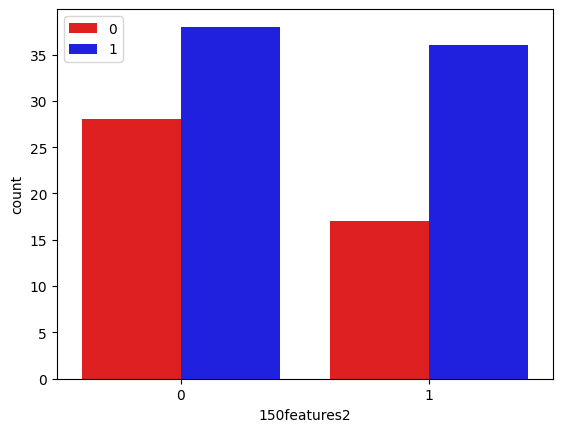

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


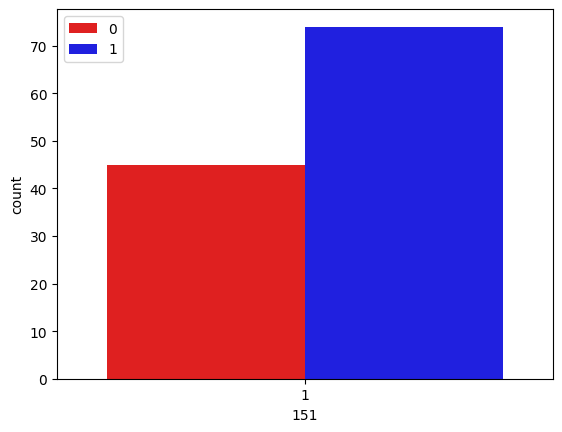

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


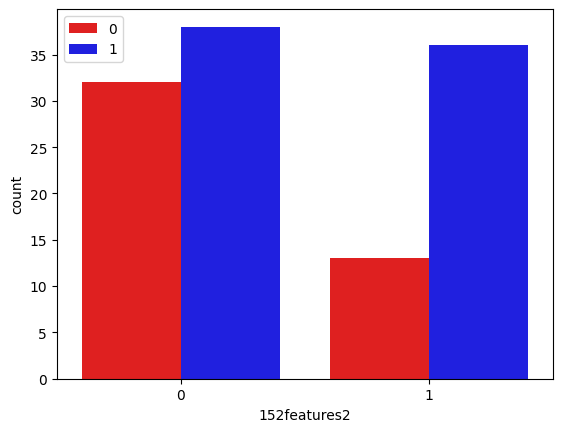

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


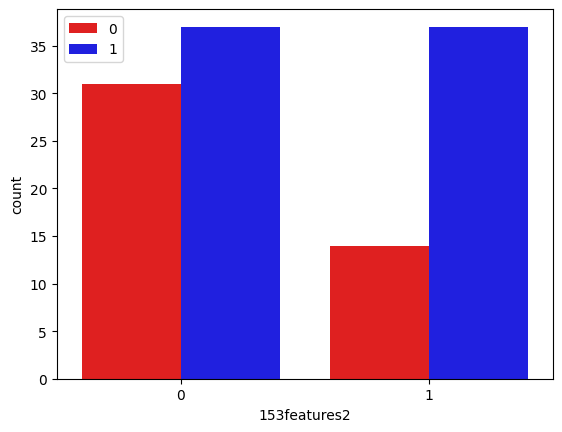

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


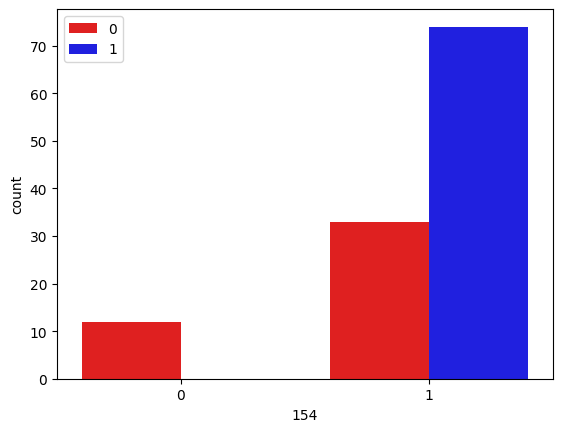

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


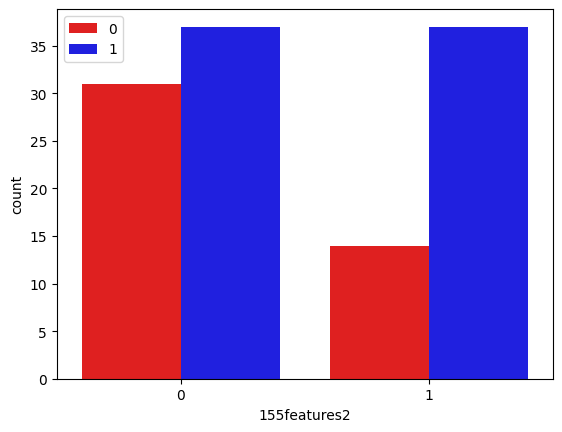

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


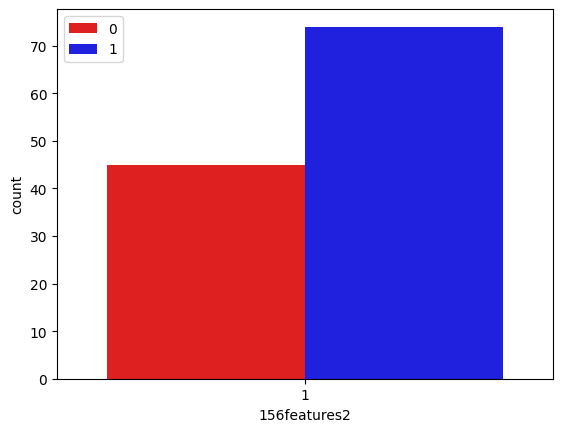

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


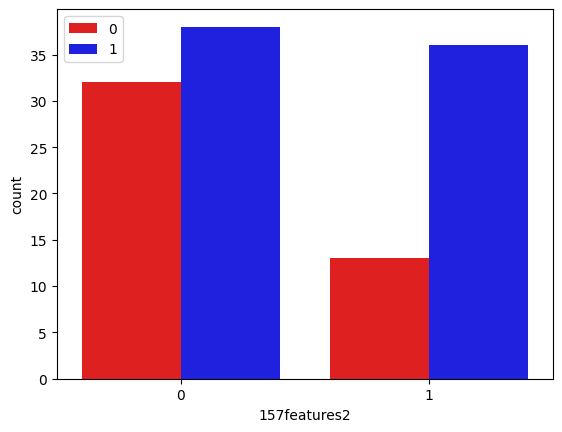

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


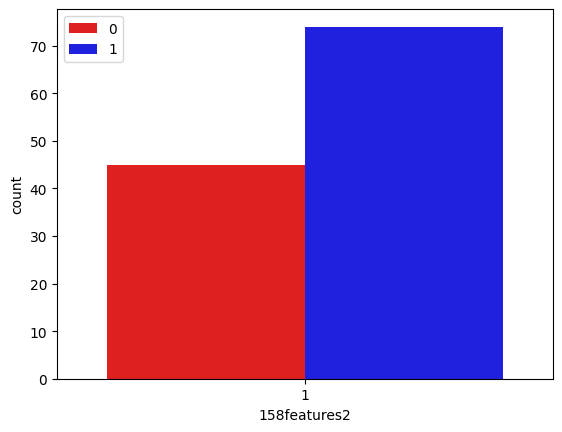

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


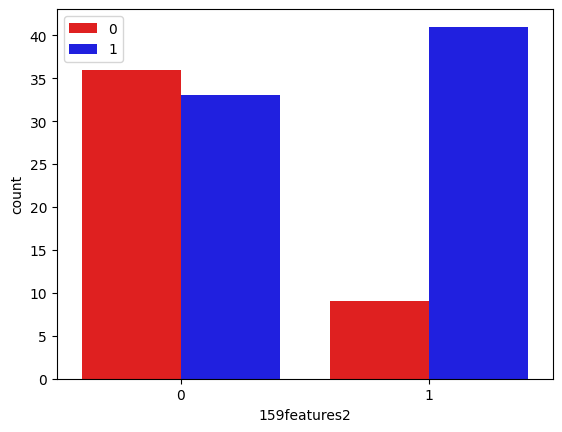

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


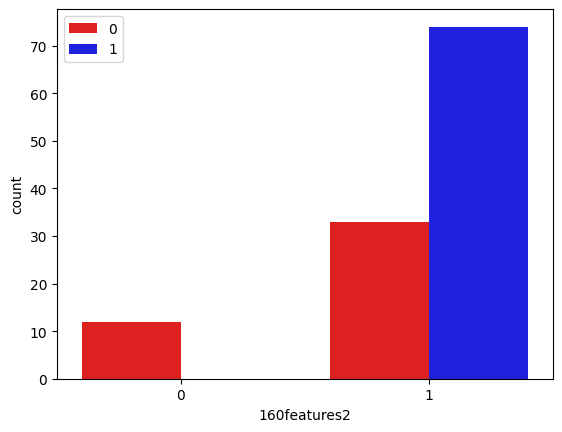

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


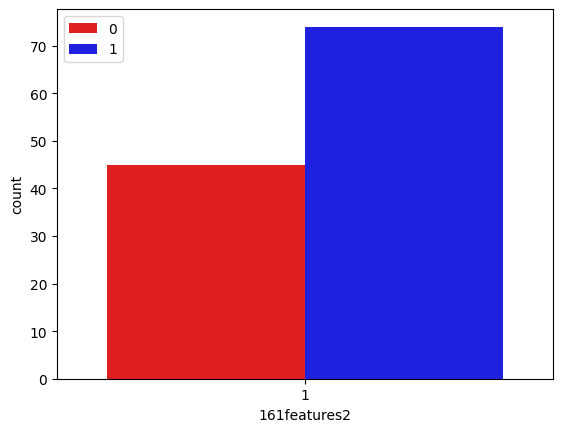

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


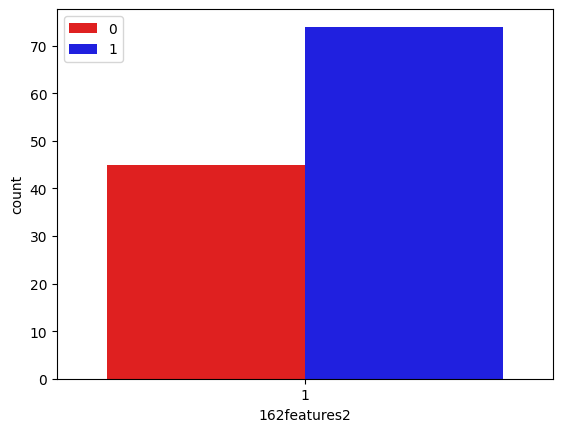

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


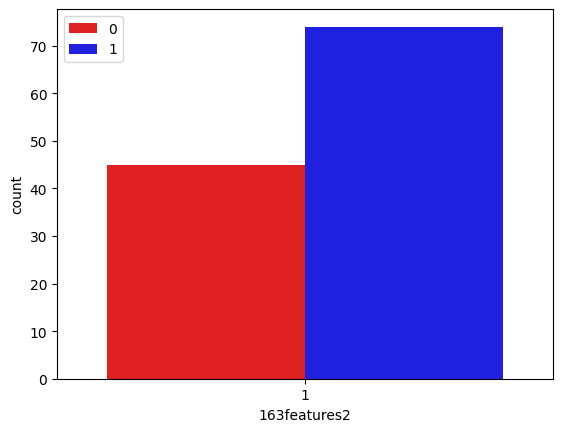

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


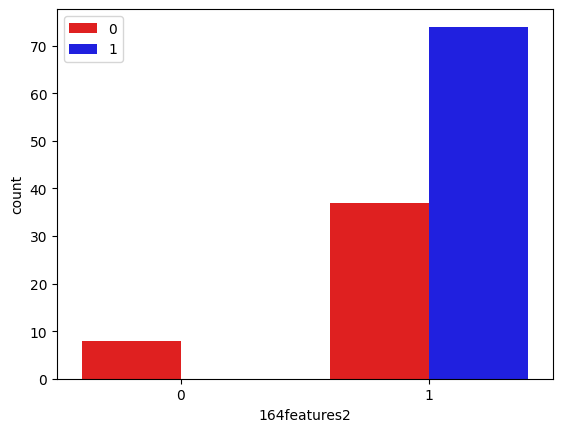

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


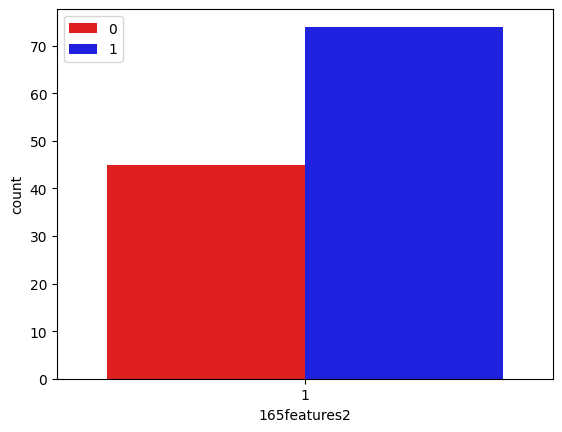

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


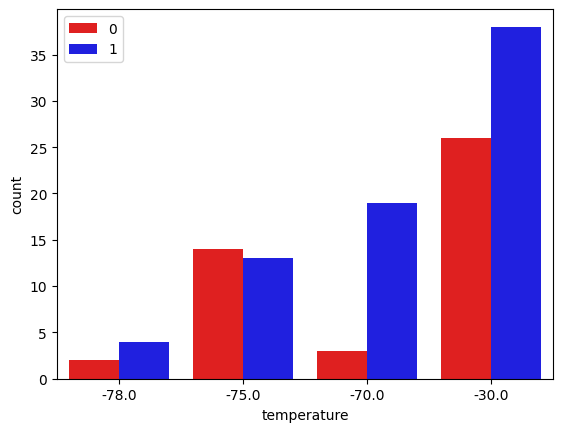

In [29]:
for cat_feat in features_df.columns:
    plt.figure()
    sns.countplot(data=features_df, x=cat_feat, hue=class_targets_df["classes"].values, palette = ['red', "blue"])
    plt.savefig("{}.png".format(cat_feat))
    plt.show()

In the following cell we use Chi-squared test. If you are not familiar with this statistical analysis test please read here https://en.wikipedia.org/wiki/Chi-squared_test

In [30]:
from scipy.stats import chi2_contingency
chi2_values = {}
p_values={}
for cat_feat in features_df.columns:
    contingency_table = pd.crosstab(features_df[cat_feat], class_targets_df["classes"])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_values[cat_feat] = chi2
    p_values[cat_feat]=p
    print("{}: chi2={}, p={}".format(cat_feat, chi2, p))


22: chi2=0.0, p=1.0
24: chi2=0.0, p=1.0
34: chi2=0.04217432950191573, p=0.8372878264302387
36: chi2=0.0, p=1.0
41: chi2=0.0, p=1.0
42features1: chi2=1.1280256887322104, p=0.2881968551288711
46: chi2=3.0132399444899454, p=0.08258706344063454
49: chi2=0.0, p=1.0
50: chi2=0.5853523782403092, p=0.44422197376823547
56: chi2=0.0, p=1.0
57: chi2=0.14206482123148786, p=0.7062368684079676
63: chi2=0.0, p=1.0
66features1: chi2=1.420179818655428, p=0.23337380807836436
70: chi2=0.0, p=1.0
71: chi2=0.0, p=1.0
74features1: chi2=3.662801238738739, p=0.05564001197583772
76: chi2=0.5853523782403092, p=0.44422197376823547
78features1: chi2=0.0, p=1.0
81features1: chi2=0.0, p=1.0
83: chi2=0.5853523782403092, p=0.44422197376823547
87: chi2=3.63709217394965, p=0.056505542777800455
88features1: chi2=0.0, p=1.0
93features1: chi2=0.41714252130918794, p=0.5183663252454338
94: chi2=0.0, p=1.0
95features1: chi2=0.0, p=1.0
96features1: chi2=0.5853523782403092, p=0.44422197376823547
97features1: chi2=0.0, p=1.0
98

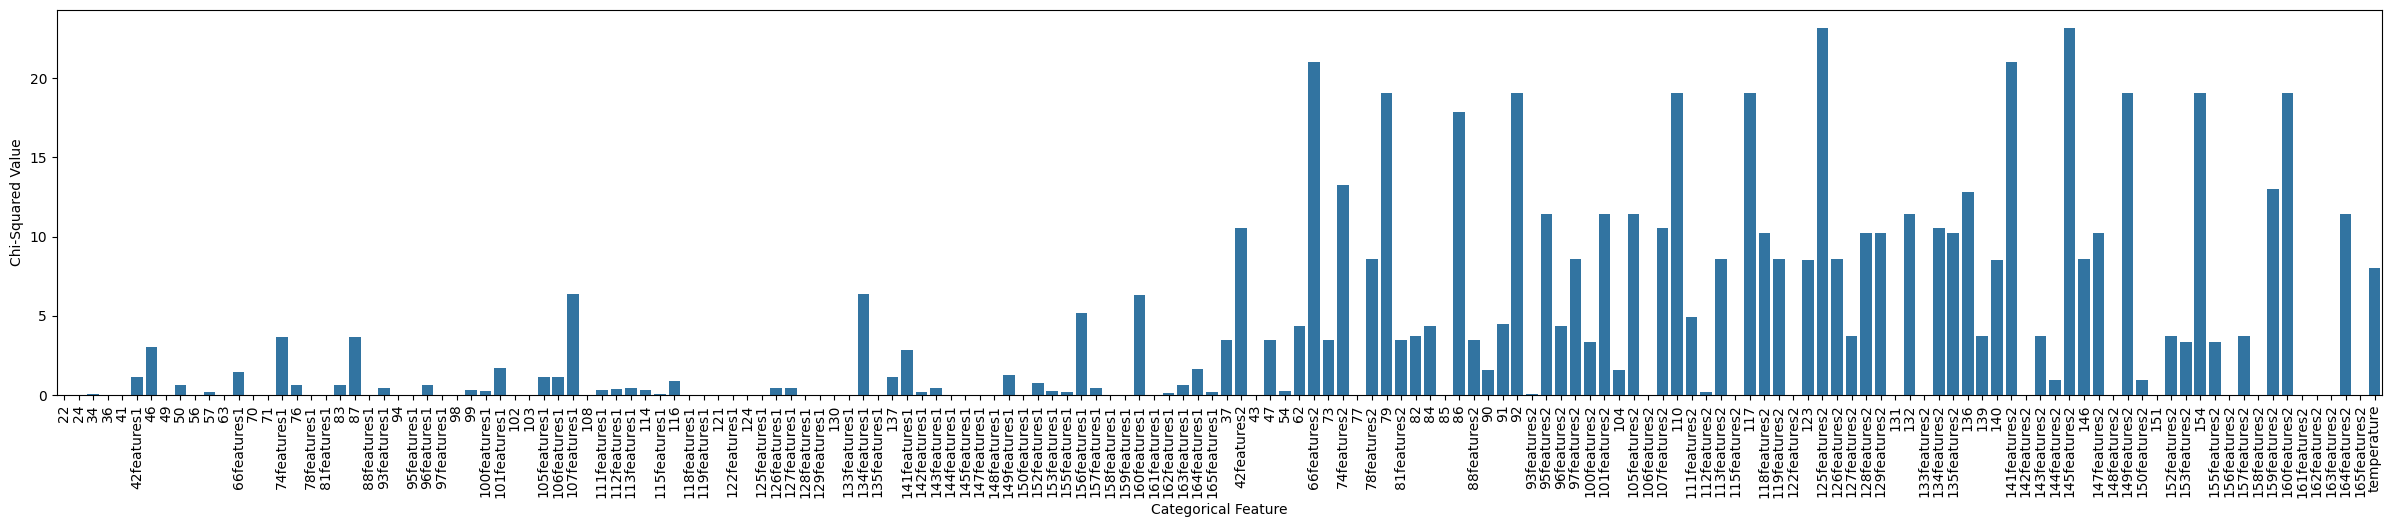

In [31]:
plt.figure(figsize=(30, 5))
sns.barplot(x=list(chi2_values.keys()), y=list(chi2_values.values()))
plt.xticks(rotation=90)
plt.xlabel("Categorical Feature")
plt.ylabel("Chi-Squared Value")
plt.show()


In [32]:
significant_features = []
for feature in p_values.keys():
    if chi2_values[feature]>10 and p_values[feature] < 0.05:
        significant_features.append(feature)
# significant_df = df[significant_features]

In [33]:
significant_features

['42features2',
 '66features2',
 '74features2',
 '79',
 '86',
 '92',
 '95features2',
 '101features2',
 '105features2',
 '107features2',
 '110',
 '117',
 '118features2',
 '125features2',
 '128features2',
 '129features2',
 '132',
 '134features2',
 '135features2',
 '136',
 '141features2',
 '145features2',
 '147features2',
 '149features2',
 '154',
 '159features2',
 '160features2',
 '164features2']

We dont need to keep features that are not significant for our model

In [34]:
features_df = features_df.drop([col for col in features_df.columns if col not in significant_features], axis=1)

# Classification
In this section we test out a range of classification models.

## Using synthetic data sampling

In this section I investigate the use of synthetic sampling methods, i.e. generate additional sampling points for the minority class or undersample the majority class. Both of these techniques look to provide a better balance between the classes and hence improve the learning of a decision boundary. SMOTE https://arxiv.org/pdf/1106.1813.pdf.


In [36]:
nneighbours = min(5, len(class_targets_df[class_targets_df["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No categorical
if feature_types == "no_categorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some categorical - Need to provide the indexes
elif feature_types == "some_categorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=categorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All categorical
elif feature_types == "categorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


Check that there are only features in the feature dataframe and classes in the classes dataframe.

In [37]:
log.info("Feature decriptions:\n{}".format(features_df.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df.columns.values))

Feature decriptions:
['42features2' '66features2' '74features2' '79' '86' '92' '95features2'
 '101features2' '105features2' '107features2' '110' '117' '118features2'
 '125features2' '128features2' '129features2' '132' '134features2'
 '135features2' '136' '141features2' '145features2' '147features2'
 '149features2' '154' '159features2' '160features2' '164features2']
Classes/Targets descriptions:
['classes']


Sample using smote to balance the dataset using synthetic samples for the under represented class.

In [38]:
features_smote, classes_smote = sm.fit_resample(features_df.to_numpy(), class_targets_df.to_numpy())
n_sythetic_points = features_smote.shape[0] - len(features_df.index)
log.info("SMOTE has added {} sythetic features to balance the classes".format(n_sythetic_points))

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:950: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
SMOTE has added 29 sythetic features to balance the classes


In [39]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote, features_smote.shape, classes_smote, classes_smote.shape))

Resampled X
[[1 1 1 ... 0 1 1]
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 0 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 0 1 1]]
(148, 28)
Resampled y:
[0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(148,)


In [40]:
features_smote_df = pd.DataFrame(data=features_smote, columns=features_df.columns.values)
classes_smote_df = pd.DataFrame(data=classes_smote, columns=["classes"])

comb_df_res = features_smote_df.copy()
comb_df_res["classes"] = classes_smote
comb_df_res.to_csv("resampled_synthetic_data_set.csv")
comb_df_res

42features2  66features2  74features2  79  86  92  95features2  \
0              1            1            1   1   1   1            1   
1              1            1            1   1   1   1            1   
2              1            1            1   1   1   1            1   
3              1            1            1   1   1   1            1   
4              1            1            1   1   0   1            1   
5              1            1            1   1   0   1            1   
6              1            1            1   1   0   1            1   
7              1            1            1   1   0   1            1   
8              1            1            1   1   0   1            1   
9              1            1            1   1   0   1            1   
10             1            1            1   1   0   1            1   
11             1            1            1   1   0   1            1   
12             1            1            1   1   0   1            1   
13             1            1            1   1   0   1            1   
14             1            1            1   1   0   1            1   
15             1            1            1   1   0   1            1   
16             1            1            1   1   0   1            1   
17             1            1            1   1   0   1            1   
18             1            1            1   1   0   1            1   
19             1            1            1   1   0   1            1   
20             1            1            1   1   0   1            1   
21             1            1            1   1   0   1            1   
22             1            1            1   1   0   1            1   
23             1            1            1   1   0   1            1   
24             1            1            1   1   0   1            1   
25             1            1            1   1   0   1            1   
26             1            1            1   1   0   1            1   
27             1            1            1   1   0   1            1   
28             1            1            1   1   0   1            1   
29             1            1            1   1   0   1            1   
30             1            1            1   1   0   1            1   
31             0            1            1   1   0   1            1   
32             0            1            1   1   0   1            1   
33             0            1            1   1   0   1            1   
34             0            1            1   1   0   1            1   
35             0            1            1   1   0   1            1   
36             0            1            1   1   0   1            1   
37             0            1            1   1   0   1            1   
38             0            1            1   1   0   1            1   
39             0            1            1   1   0   1            1   
40             0            1            1   1   0   1            1   
41             0            1            1   1   0   1            1   
42             0            1            1   1   0   1            1   
43             0            1            1   1   0   1            1   
44             0            1            1   1   0   1            1   
45             0            1            1   1   0   1            1   
46             0            1            1   1   0   1            1   
47             0            1            1   1   0   1            1   
48             1            1            1   1   0   1            1   
49             1            1            1   1   0   1            1   
50             1            1            1   1   0   1            1   
51             1            1            1   1   0   1            1   
52             1            1            1   1   0   1            1   
53             1            1            1   1   0   1            1   
54             1            1            1   1   0   1            1   
55             1            1

In [41]:
features_smote_df = features_smote_df.astype(float)
features_smote_df

42features2  66features2  74features2   79   86   92  95features2  \
0            1.0          1.0          1.0  1.0  1.0  1.0          1.0   
1            1.0          1.0          1.0  1.0  1.0  1.0          1.0   
2            1.0          1.0          1.0  1.0  1.0  1.0          1.0   
3            1.0          1.0          1.0  1.0  1.0  1.0          1.0   
4            1.0          1.0          1.0  1.0  0.0  1.0          1.0   
5            1.0          1.0          1.0  1.0  0.0  1.0          1.0   
6            1.0          1.0          1.0  1.0  0.0  1.0          1.0   
7            1.0          1.0          1.0  1.0  0.0  1.0          1.0   
8            1.0          1.0          1.0  1.0  0.0  1.0          1.0   
9            1.0          1.0          1.0  1.0  0.0  1.0          1.0   
10           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
11           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
12           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
13           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
14           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
15           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
16           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
17           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
18           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
19           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
20           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
21           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
22           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
23           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
24           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
25           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
26           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
27           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
28           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
29           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
30           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
31           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
32           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
33           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
34           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
35           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
36           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
37           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
38           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
39           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
40           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
41           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
42           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
43           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
44           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
45           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
46           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
47           0.0          1.0          1.0  1.0  0.0  1.0          1.0   
48           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
49           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
50           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
51           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
52           1.0          1.0          1.0  1.0  0.0  1.0          1.0   
53       

## Using balanced classes Kfold
This section tests the relience of the model on the training set

In [42]:
kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier", "AdaBoost",
         "LogisticRegression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "NearestNeighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "GaussianProcess": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "DecisionTree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "LogisticRegression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

In [43]:
%%capture
wf.kfold_test_classifiers_with_optimization(features_smote_df, classes_smote_df, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, scale=False, cv=5, n_repeats=10, smiles=None, names=None,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

Features: Index(['42features2', '66features2', '74features2', '79', '86', '92',
       '95features2', '101features2', '105features2', '107features2', '110',
       '117', '118features2', '125features2', '128features2', '129features2',
       '132', '134features2', '135features2', '136', '141features2',
       '145features2', '147features2', '149features2', '154', '159features2',
       '160features2', '164features2'],
      dtype='object')
Features:      42features2  66features2  74features2   79   86   92  95features2  \
0            1.0          1.0          1.0  1.0  1.0  1.0          1.0   
1            1.0          1.0          1.0  1.0  1.0  1.0          1.0   
2            1.0          1.0          1.0  1.0  1.0  1.0          1.0   
3            1.0          1.0          1.0  1.0  1.0  1.0          1.0   
4            1.0          1.0          1.0  1.0  0.0  1.0          1.0   
5            1.0          1.0          1.0  1.0  0.0  1.0          1.0   
6            1.0          1.

Using unscaled features
Starting classification: NOTE on confusion matrix - In binary classification, true negatives is element 0,0, false negatives is element 1,0, true positives is element 1,1 and false positives is element 0,1

-----
Begin NearestNeighbors
-----

----- NearestNeighbors: Fold 0 -----
[9, 16, 37, 42, 46, 48, 53, 57, 60, 88, 109, 126, 129, 134, 136]
	Train indx [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38
  39  40  41  43  44  45  47  49  50  51  52  54  55  56  58  59  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 127 128 130 131 132 133 135 137 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [  9  16  37  42  46  48  53  57  60  88 109 126 129 134 136]
	Bes

----- NearestNeighbors: Fold 4 -----
[8, 24, 27, 33, 43, 54, 58, 90, 91, 106, 114, 117, 130, 131, 142]
	Train indx [  0   1   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  26  28  29  30  31  32  34  35  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  55  56  57  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 107 108 109 110 111 112 113 115 116 118 119
 120 121 122 123 124 125 126 127 128 129 132 133 134 135 136 137 138 139
 140 141 143 144 145 146 147]
	Test indx: [  8  24  27  33  43  54  58  90  91 106 114 117 130 131 142]
	Best parameters; {'n_neighbors': 9}
	0.6885 (+/-0.2148) for {'n_neighbors': 2}
	0.6765 (+/-0.2053) for {'n_neighbors': 3}
	0.7006 (+/-0.1831) for {'n_neighbors': 4}
	0.6989 (+/-0.1858) for {'n_neighbors': 5}
	0.6989 (+/-0.1858) for {'n_neighbors': 6}
	0.7087 (+/-0.1869

----- NearestNeighbors: Fold 8 -----
[2, 12, 29, 62, 65, 85, 95, 101, 102, 104, 115, 118, 121, 147]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  63  64  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  86  87  88  89  90  91  92  93  94  96
  97  98  99 100 103 105 106 107 108 109 110 111 112 113 114 116 117 119
 120 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146]
	Test indx: [  2  12  29  62  65  85  95 101 102 104 115 118 121 147]
	Best parameters; {'n_neighbors': 9}
	0.6738 (+/-0.1943) for {'n_neighbors': 2}
	0.7029 (+/-0.1872) for {'n_neighbors': 3}
	0.7043 (+/-0.1316) for {'n_neighbors': 4}
	0.6922 (+/-0.1444) for {'n_neighbors': 5}
	0.6922 (+/-0.1444) for {'n_neighbors': 6}
	0.6922 (+/-0.1444) f

----- GaussianProcess: Fold 2 -----
[10, 14, 18, 51, 56, 68, 71, 73, 74, 78, 86, 111, 116, 123, 127]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  13  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  57  58
  59  60  61  62  63  64  65  66  67  69  70  72  75  76  77  79  80  81
  82  83  84  85  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 112 113 114 115 117 118 119 120
 121 122 124 125 126 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [ 10  14  18  51  56  68  71  73  74  78  86 111 116 123 127]
	Best parameters; {'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.5)}
	0.6989 (+/-0.1841) for {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.7145 (+/-0.1704) for {'kernel': 1**2 * Matern(length_scale=1, nu=2.5)}
	0.7145 (+/-0.1704) for {'kernel': 1

----- GaussianProcess: Fold 6 -----
[11, 17, 19, 23, 26, 36, 40, 45, 75, 96, 107, 113, 133, 135, 144]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  18  20
  21  22  24  25  27  28  29  30  31  32  33  34  35  37  38  39  41  42
  43  44  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  97  98  99
 100 101 102 103 104 105 106 108 109 110 111 112 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 134 136 137 138 139
 140 141 142 143 145 146 147]
	Test indx: [ 11  17  19  23  26  36  40  45  75  96 107 113 133 135 144]
	Best parameters; {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.7277 (+/-0.1944) for {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.7277 (+/-0.1944) for {'kernel': 1**2 * Matern(length_scale=1, nu=2.5)}
	0.7079 (+/-0.2162) for {'kernel': 1**2 * RBF(length_sc

[[0.93809524 0.69117521]
 [0.56354978 0.96142857]
 [0.68902625 0.79709681]
 [7.4        7.4       ]] [[0.12426656 0.11552263]
 [0.16337206 0.08760999]
 [0.14524994 0.09827525]
 [1.9078784  2.00997512]] 0.7888414502164502 0.12240871992110382

-----
Begin DecisionTree
-----

----- DecisionTree: Fold 0 -----
[9, 16, 37, 42, 46, 48, 53, 57, 60, 88, 109, 126, 129, 134, 136]
	Train indx [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38
  39  40  41  43  44  45  47  49  50  51  52  54  55  56  58  59  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 127 128 130 131 132 133 135 137 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [  9  16  37  42  46  48  53  57  60  88 109 126 129 134 136]
	

	Best parameters; {'max_depth': 3}
	0.6956 (+/-0.2126) for {'max_depth': 2}
	0.7112 (+/-0.1884) for {'max_depth': 3}
	0.6846 (+/-0.2011) for {'max_depth': 4}
	0.6473 (+/-0.1985) for {'max_depth': 5}
	0.6473 (+/-0.1985) for {'max_depth': 7}
	0.6473 (+/-0.1985) for {'max_depth': 10}

	----- Predicting using: DecisionTree -----
	ROC analysis area under the curve: 0.8839285714285714
	Confusion matrix (DecisionTree):
[[6 2]
 [0 7]]


	score (DecisionTree): 0.8666666666666667
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.75      1.00      0.86      0.87      0.73         8
          1       0.78      1.00      0.75      0.88      0.87      0.77         7

avg / total       0.90      0.87      0.88      0.87      0.87      0.75        15

	 Index | Predicted | Label
	------------------
	8   |   1   |   1
	24   |   1   |   1
	27   |   1   |   1
	33   |   1   |   1
	43   |  

	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.80      1.00      0.89      0.89      0.78        10
          1       0.67      1.00      0.80      0.80      0.89      0.82         4

avg / total       0.90      0.86      0.94      0.86      0.89      0.79        14

	 Index | Predicted | Label
	------------------
	2   |   1   |   0
	12   |   1   |   1
	29   |   1   |   1
	62   |   0   |   0
	65   |   1   |   1
	85   |   1   |   1
	95   |   1   |   0
	101   |   0   |   0
	102   |   0   |   0
	104   |   0   |   0
	115   |   0   |   0
	118   |   0   |   0
	121   |   0   |   0
	147   |   0   |   0
-----

----- DecisionTree: Fold 9 -----
[1, 21, 44, 55, 69, 77, 82, 87, 92, 93, 132, 140, 143, 146]
	Train indx [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  4

	0.6354 (+/-0.2079) for {'max_depth': 10, 'n_estimators': 10}
	0.6354 (+/-0.2079) for {'max_depth': 10, 'n_estimators': 20}
	0.6354 (+/-0.2079) for {'max_depth': 10, 'n_estimators': 50}
	0.6354 (+/-0.2079) for {'max_depth': 10, 'n_estimators': 100}

	----- Predicting using: ExtraTreesClassifier -----
	ROC analysis area under the curve: 0.9642857142857143
	Confusion matrix (ExtraTreesClassifier):
[[5 2]
 [0 8]]


	score (ExtraTreesClassifier): 0.8666666666666667
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.71      1.00      0.83      0.85      0.69         7
          1       0.80      1.00      0.71      0.89      0.85      0.73         8

avg / total       0.89      0.87      0.85      0.86      0.85      0.72        15

	 Index | Predicted | Label
	------------------
	0   |   0   |   0
	6   |   1   |   1
	25   |   1   |   1
	30   |   1   |   0
	49   |   1   |   1

	Best parameters; {'max_depth': 2, 'n_estimators': 100}
	0.7634 (+/-0.1910) for {'max_depth': 2, 'n_estimators': 10}
	0.7634 (+/-0.1910) for {'max_depth': 2, 'n_estimators': 20}
	0.7575 (+/-0.1920) for {'max_depth': 2, 'n_estimators': 50}
	0.7693 (+/-0.1909) for {'max_depth': 2, 'n_estimators': 100}
	0.7169 (+/-0.2169) for {'max_depth': 3, 'n_estimators': 10}
	0.7169 (+/-0.2169) for {'max_depth': 3, 'n_estimators': 20}
	0.7169 (+/-0.2169) for {'max_depth': 3, 'n_estimators': 50}
	0.7169 (+/-0.2169) for {'max_depth': 3, 'n_estimators': 100}
	0.6648 (+/-0.1853) for {'max_depth': 4, 'n_estimators': 10}
	0.6708 (+/-0.1816) for {'max_depth': 4, 'n_estimators': 20}
	0.6708 (+/-0.1816) for {'max_depth': 4, 'n_estimators': 50}
	0.6743 (+/-0.1797) for {'max_depth': 4, 'n_estimators': 100}
	0.7205 (+/-0.2145) for {'max_depth': 5, 'n_estimators': 10}
	0.6743 (+/-0.1797) for {'max_depth': 5, 'n_estimators': 20}
	0.6743 (+/-0.1797) for {'max_depth': 5, 'n_estimators': 50}
	0.6743 (+/-0.1797) for {'

	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.33      1.00      0.50      0.58      0.31         6
          1       0.69      1.00      0.33      0.82      0.58      0.36         9

avg / total       0.82      0.73      0.60      0.69      0.58      0.34        15

	 Index | Predicted | Label
	------------------
	11   |   1   |   1
	17   |   1   |   1
	19   |   1   |   1
	23   |   1   |   1
	26   |   1   |   1
	36   |   1   |   1
	40   |   1   |   1
	45   |   1   |   1
	75   |   1   |   0
	96   |   1   |   1
	107   |   0   |   0
	113   |   0   |   0
	133   |   1   |   0
	135   |   1   |   0
	144   |   1   |   0
-----

----- ExtraTreesClassifier: Fold 7 -----
[3, 4, 7, 20, 34, 38, 41, 67, 76, 94, 108, 110, 112, 138, 139]
	Train indx [  0   1   2   5   6   8   9  10  11  12  13  14  15  16  17  18  19  21
  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  39  40  42
  43  44 

	0.6978 (+/-0.1882) for {'max_depth': 3, 'n_estimators': 20}
	0.6978 (+/-0.1882) for {'max_depth': 3, 'n_estimators': 50}
	0.6978 (+/-0.1882) for {'max_depth': 3, 'n_estimators': 100}
	0.6934 (+/-0.1921) for {'max_depth': 4, 'n_estimators': 10}
	0.6934 (+/-0.1921) for {'max_depth': 4, 'n_estimators': 20}
	0.6934 (+/-0.1921) for {'max_depth': 4, 'n_estimators': 50}
	0.6934 (+/-0.1921) for {'max_depth': 4, 'n_estimators': 100}
	0.6857 (+/-0.1940) for {'max_depth': 5, 'n_estimators': 10}
	0.6934 (+/-0.1921) for {'max_depth': 5, 'n_estimators': 20}
	0.6934 (+/-0.1921) for {'max_depth': 5, 'n_estimators': 50}
	0.6934 (+/-0.1921) for {'max_depth': 5, 'n_estimators': 100}
	0.6588 (+/-0.2095) for {'max_depth': 7, 'n_estimators': 10}
	0.6588 (+/-0.2095) for {'max_depth': 7, 'n_estimators': 20}
	0.6588 (+/-0.2095) for {'max_depth': 7, 'n_estimators': 50}
	0.6588 (+/-0.2095) for {'max_depth': 7, 'n_estimators': 100}
	0.6588 (+/-0.2095) for {'max_depth': 10, 'n_estimators': 10}
	0.6588 (+/-0.2095)

	Best parameters; {'n_estimators': 10}
	0.6617 (+/-0.1504) for {'n_estimators': 10}
	0.6595 (+/-0.1532) for {'n_estimators': 20}
	0.6595 (+/-0.1532) for {'n_estimators': 50}
	0.6595 (+/-0.1532) for {'n_estimators': 100}

	----- Predicting using: AdaBoost -----
	ROC analysis area under the curve: 0.8200000000000001
	Confusion matrix (AdaBoost):
[[ 3  2]
 [ 0 10]]


	score (AdaBoost): 0.8666666666666667
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.60      1.00      0.75      0.77      0.58         5
          1       0.83      1.00      0.60      0.91      0.77      0.62        10

avg / total       0.89      0.87      0.73      0.86      0.77      0.61        15

	 Index | Predicted | Label
	------------------
	5   |   1   |   1
	15   |   1   |   1
	22   |   1   |   1
	31   |   1   |   1
	35   |   1   |   1
	39   |   1   |   1
	47   |   1   |   1
	52   |   1   |   1

	 Index | Predicted | Label
	------------------
	3   |   0   |   1
	4   |   1   |   0
	7   |   1   |   1
	20   |   1   |   1
	34   |   1   |   0
	38   |   1   |   1
	41   |   1   |   1
	67   |   0   |   1
	76   |   1   |   1
	94   |   1   |   0
	108   |   0   |   0
	110   |   0   |   0
	112   |   0   |   0
	138   |   0   |   0
	139   |   0   |   0
-----

----- AdaBoost: Fold 8 -----
[2, 12, 29, 62, 65, 85, 95, 101, 102, 104, 115, 118, 121, 147]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  63  64  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  86  87  88  89  90  91  92  93  94  96
  97  98  99 100 103 105 106 107 108 109 110 111 112 113 114 116 117 119
 120 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145

----- LogisticRegression: Fold 2 -----
[10, 14, 18, 51, 56, 68, 71, 73, 74, 78, 86, 111, 116, 123, 127]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  13  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  57  58
  59  60  61  62  63  64  65  66  67  69  70  72  75  76  77  79  80  81
  82  83  84  85  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 112 113 114 115 117 118 119 120
 121 122 124 125 126 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [ 10  14  18  51  56  68  71  73  74  78  86 111 116 123 127]
	Best parameters; {'C': 0.1, 'penalty': 'l2'}
	0.7685 (+/-0.2207) for {'C': 0.05, 'penalty': 'l2'}
	0.7722 (+/-0.1981) for {'C': 0.1, 'penalty': 'l2'}
	0.7722 (+/-0.1981) for {'C': 0.25, 'penalty': 'l2'}
	0.7650 (+/-0.1977) for {'C': 0.5, 'penalty': 'l2'}
	0.7650 (+/-0

[11, 17, 19, 23, 26, 36, 40, 45, 75, 96, 107, 113, 133, 135, 144]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  18  20
  21  22  24  25  27  28  29  30  31  32  33  34  35  37  38  39  41  42
  43  44  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  97  98  99
 100 101 102 103 104 105 106 108 109 110 111 112 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 134 136 137 138 139
 140 141 142 143 145 146 147]
	Test indx: [ 11  17  19  23  26  36  40  45  75  96 107 113 133 135 144]
	Best parameters; {'C': 0.05, 'penalty': 'l2'}
	0.8046 (+/-0.2042) for {'C': 0.05, 'penalty': 'l2'}
	0.7848 (+/-0.2400) for {'C': 0.1, 'penalty': 'l2'}
	0.7770 (+/-0.1647) for {'C': 0.25, 'penalty': 'l2'}
	0.7375 (+/-0.2282) for {'C': 0.5, 'penalty': 'l2'}
	0.7375 (+/-0.2027) for {'C': 1.0, 'penalty': 'l2'

In [44]:
directory_names = wf.directory_names(kfold_clf_names)

## Analyses the output over all folds and predictions therefore for all molecules
The next cell reads in the predictions from each fold (n_repeats max_folds should = n_repeats).


NearestNeighbors
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Confusion matrix for NearestNeighbors
[[47 27]
 [ 6 68]]
Saving plot to ddg_nearestneighbors_fingerprints.png
['ddg_nearestneighbors_fingerprints.png']
Attempting to calculate confusion based metrics
{'tn': 47, 'fp': 27, 'fn': 6, 'tp': 68}
[[47 27]
 [ 6 68]]
(0, 1)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

GaussianProcess
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Confusion matrix for GaussianProcess
[[43 31]
 [ 3 71]]
Saving plot to ddg_gaussianprocess_fingerprints.png
['ddg_nearestneighbors_fingerprints.png', 'ddg_gaussianprocess_fingerprints.png']
Attempting to calculate confusion based metrics
{'tn': 43, 'fp': 31, 'fn': 3, 'tp': 71}
[[43 31]
 [ 3 71]]
(0, 1)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_33166/3151516386.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))

DecisionTree
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Confusion matrix for DecisionTree
[[43 31]
 [ 0 74]]
Saving plot to ddg_decisiontree_fingerprints.png
['ddg_nearestneighbors_fingerprints.png', 'ddg_gaussianprocess_fingerprints.png', 'ddg_decisiontree_fingerprints.png']
Attempting to calculate confusion based metrics
{'tn': 43, 'fp': 31, 'fn': 0, 'tp': 74}
[[43 31]
 [ 0 74]]
(0, 1)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_33166/3151516386.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))

ExtraTreesClassifier
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Confusion matrix for ExtraTreesClassifier
[[43 31]
 [ 2 72]]
Saving plot to ddg_extratreesclassifier_fingerprints.png
['ddg_nearestneighbors_fingerprints.png', 'ddg_gaussianprocess_fingerprints.png', 'ddg_decisiontree_fingerprints.png', 'ddg_extratreesclassifier_fingerprints.png']
Attempting to calculate confusion based metrics
{'tn': 43, 'fp': 31, 'fn': 2, 'tp': 72}
[[43 31]
 [ 2 72]]
(0, 1)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_33166/3151516386.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))

AdaBoost
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Confusion matrix for AdaBoost
[[43 31]
 [ 8 66]]
Saving plot to ddg_adaboost_fingerprints.png
['ddg_nearestneighbors_fingerprints.png', 'ddg_gaussianprocess_fingerprints.png', 'ddg_decisiontree_fingerprints.png', 'ddg_extratreesclassifier_fingerprints.png', 'ddg_adaboost_fingerprints.png']
Attempting to calculate confusion based metrics
{'tn': 43, 'fp': 31, 'fn': 8, 'tp': 66}
[[43 31]
 [ 8 66]]
(0, 1)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_33166/3151516386.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))

LogisticRegression
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Confusion matrix for LogisticRegression
[[48 26]
 [13 61]]
Saving plot to ddg_logisticregression_fingerprints.png
['ddg_nearestneighbors_fingerprints.png', 'ddg_gaussianprocess_fingerprints.png', 'ddg_decisiontree_fingerprints.png', 'ddg_extratreesclassifier_fingerprints.png', 'ddg_adaboost_fingerprints.png', 'ddg_logisticregression_fingerprints.png']
Attempting to calculate confusion based metrics
{'tn': 48, 'fp': 26, 'fn': 13, 'tp'

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_33166/3151516386.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_33166/3151516386.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:fingerprint_features")
/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_33166/3151516386.py:44: FutureWarni

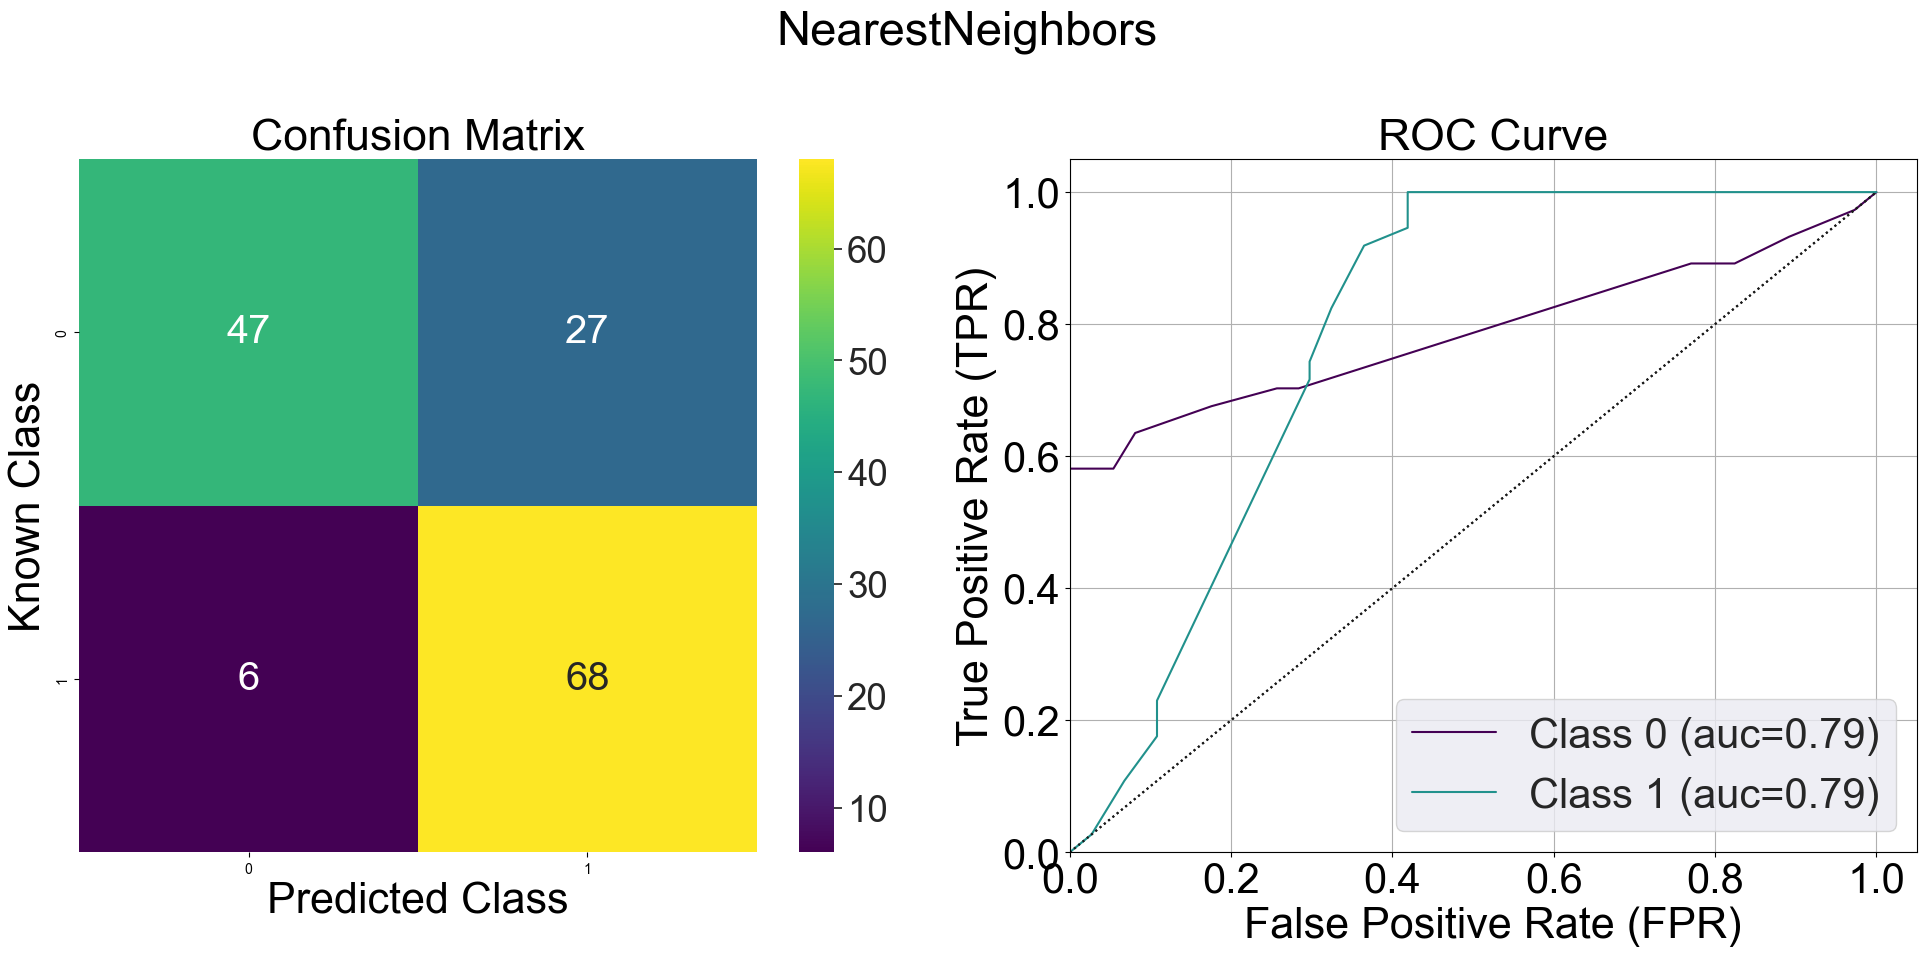

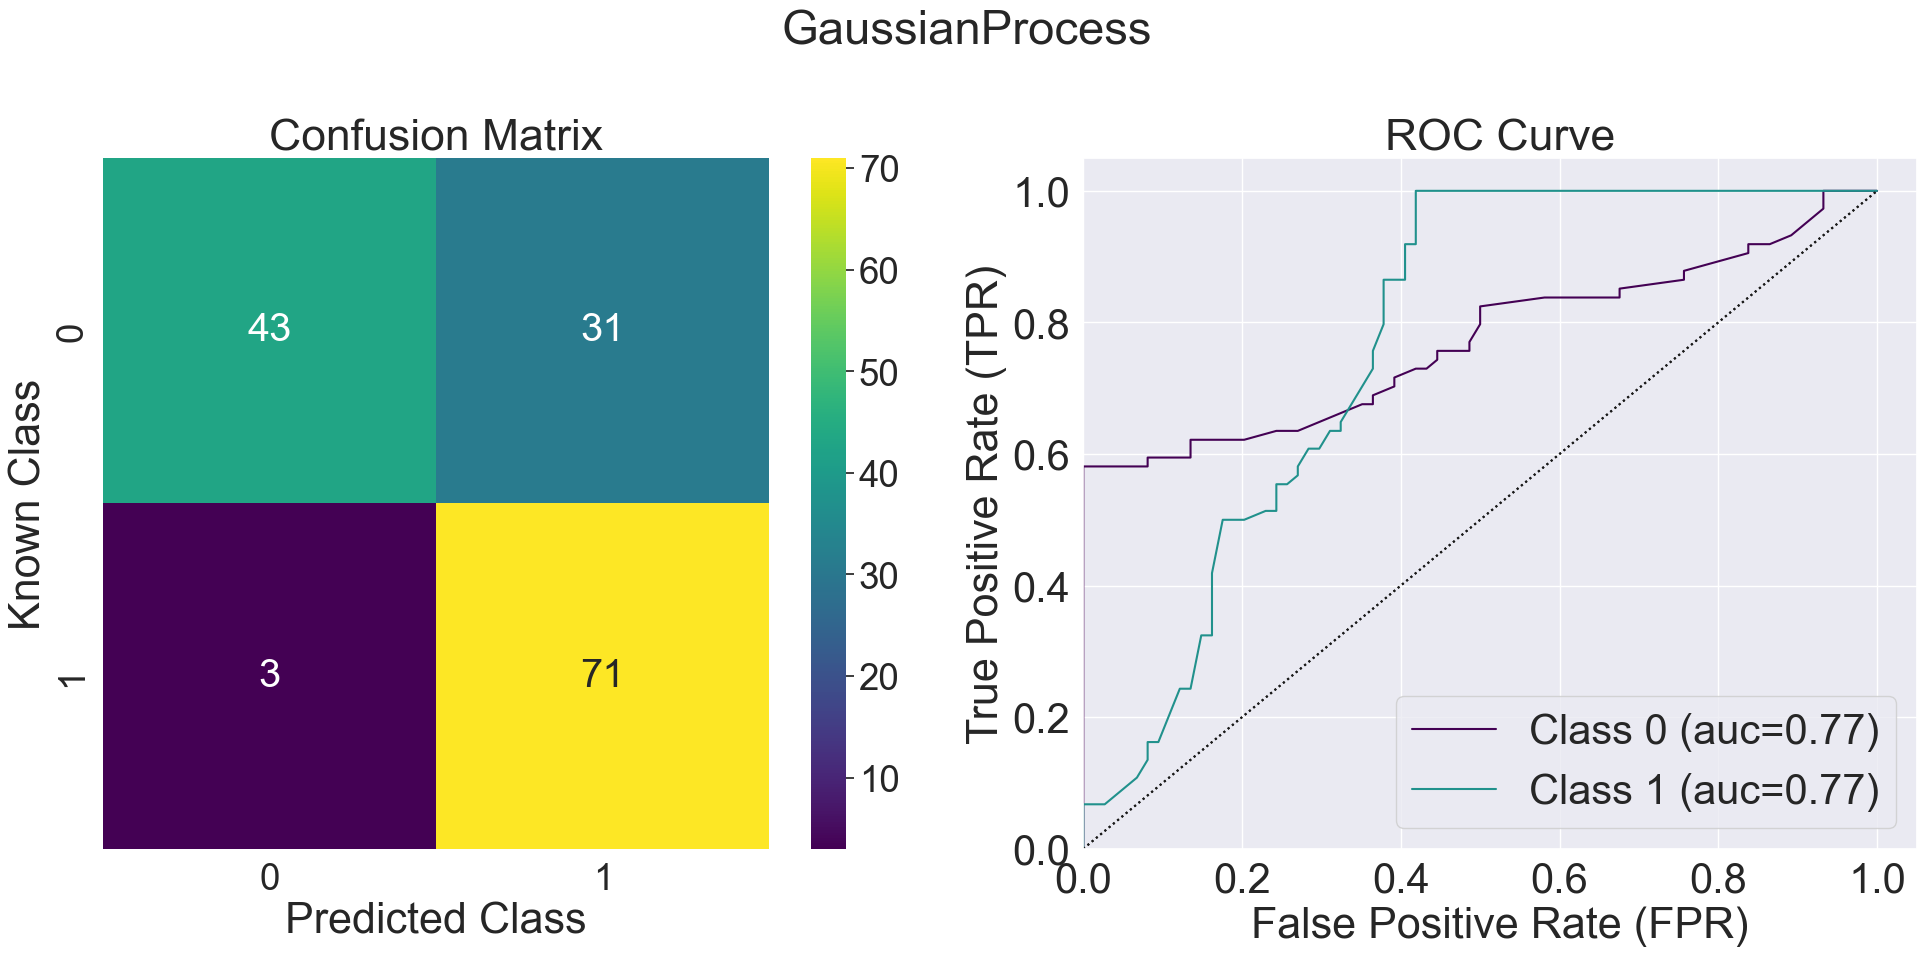

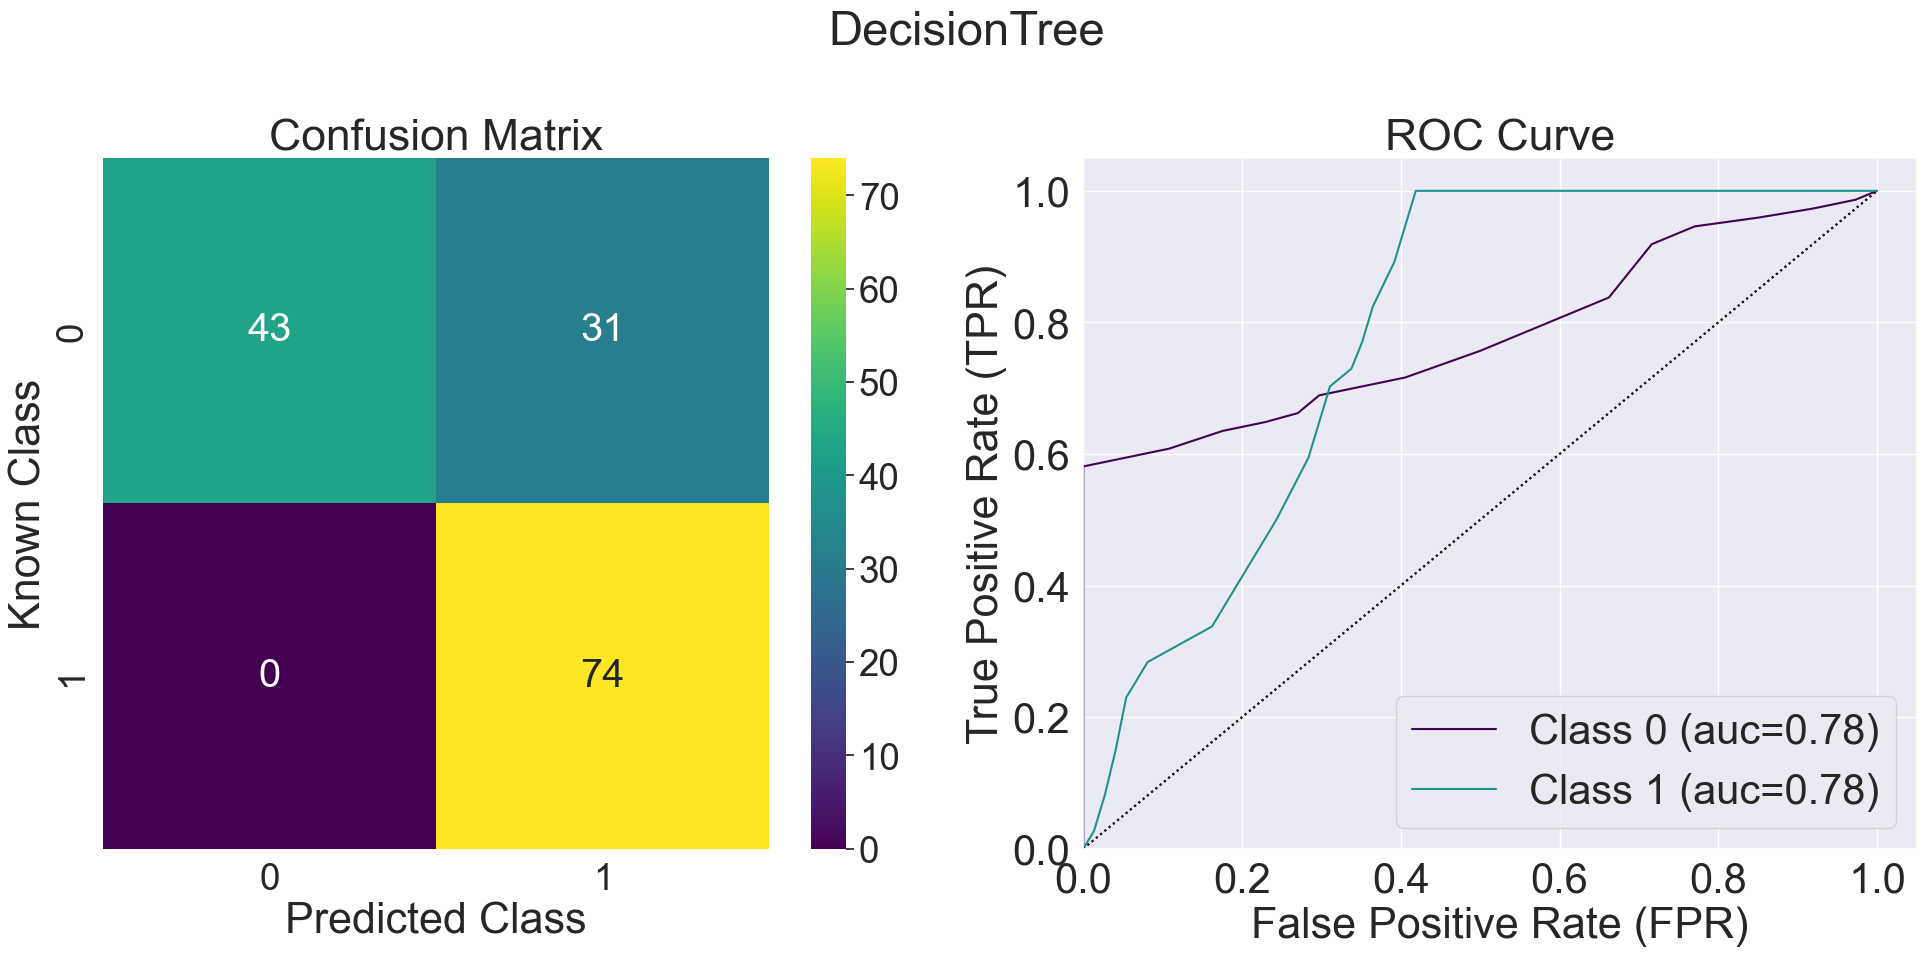

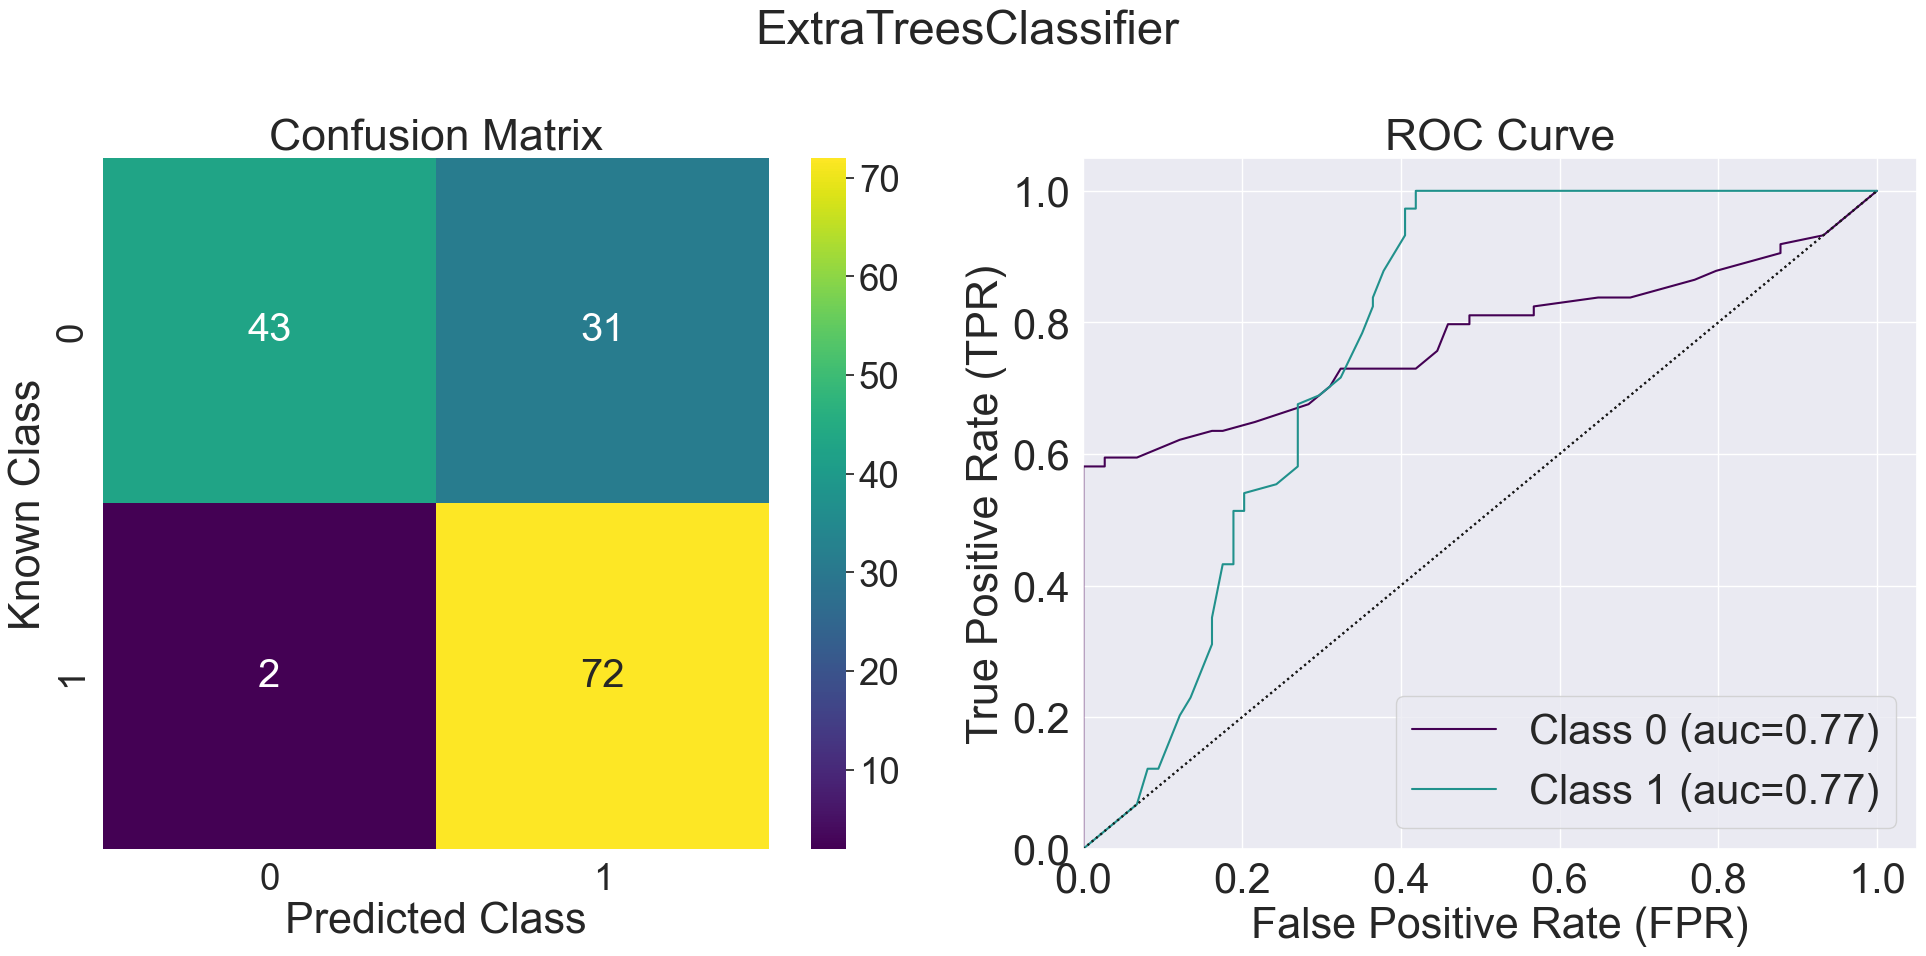

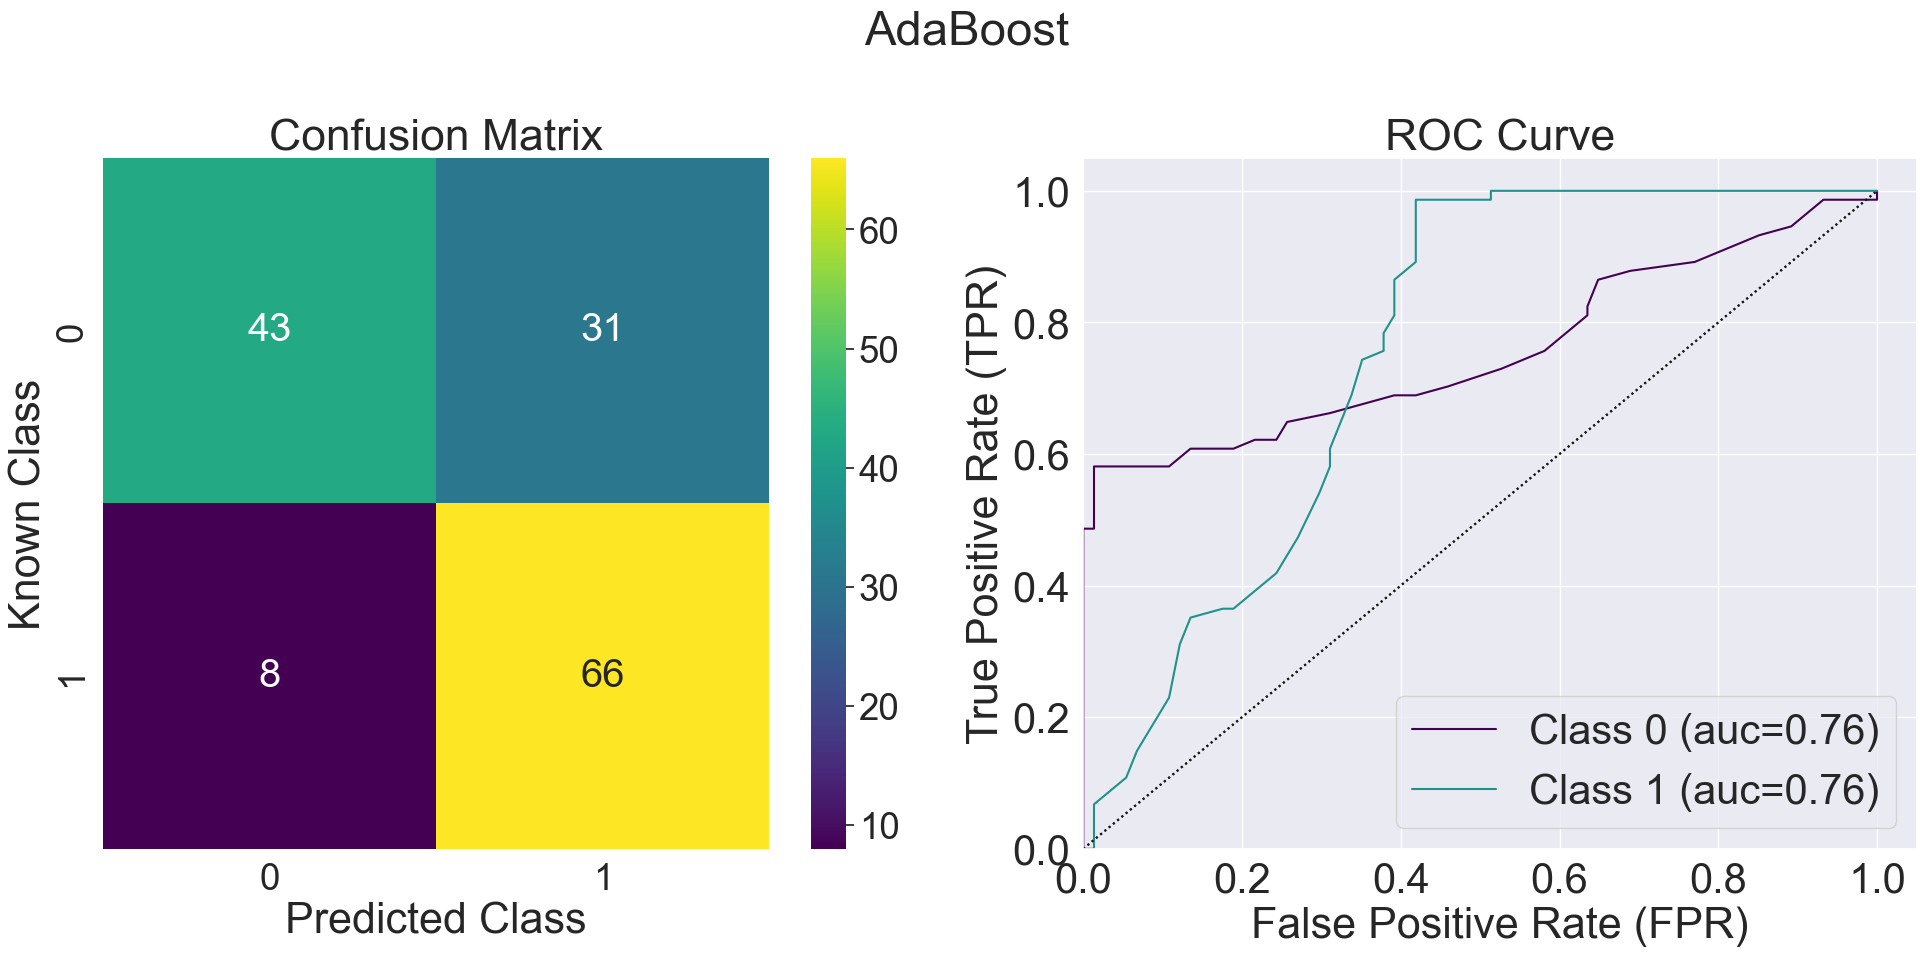

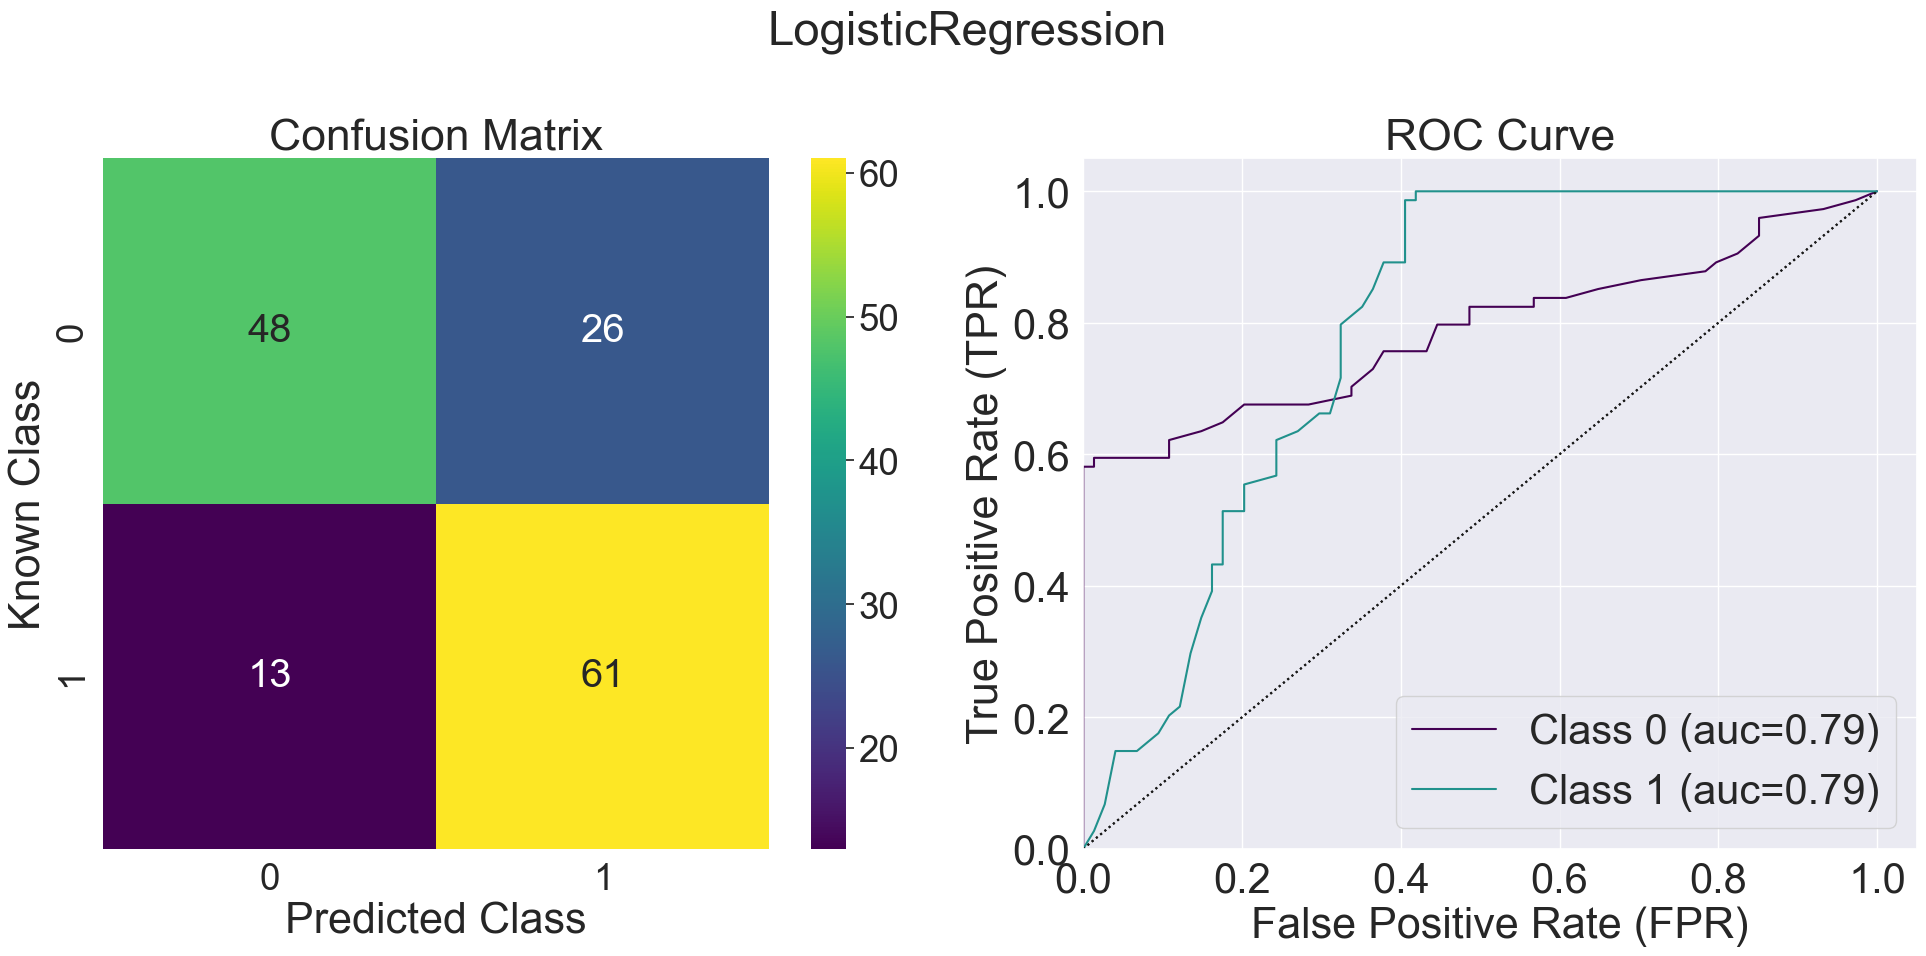

In [45]:
files_plt = []

kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier", "AdaBoost",
         "LogisticRegression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = wf.build_data_from_directory(dirname, max_folds=10)
    
    
    probs = data[["prob0", "prob1"]].to_numpy()
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.info("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_fingerprints.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))

    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_fingerprints.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from fingerprint features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:fingerprint_features")
log.info(df_metrics_for_paper.to_latex())

In [46]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_fingerprints.png")

Combining 6 images
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
New image will be W:6000 H:18000
Image 0 added at offset height 0
Image 1 added at offset height 3000
Image 2 added at offset height 6000
Image 3 added at offset height 9000
Image 4 added at offset height 12000
Image 5 added at offset height 15000


# Now first we split 90%-10% (train-test)

We need to evaluate the performace of our model on an external test set. If you are not familiar with the process please read the paper section where this is explained.

In [47]:
data = pd.read_csv("../First_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

We know which data points we are using for test set, for consistency reasons. 
However if you have much more data and you dont know which ones you want to use as a training set, or you don't want to write them manually you could do something like this:

import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.DataFrame(data)

X = df.drop('target', axis=1)
y = df['target']

test_size = 0.2 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print("X_test:")
print(X_test)

print("y_test:")
print(y_test)



In [48]:
test_reactions = [21, 81, 11, 104, 44, 106, 54, 95, 115, 25, 57, 52]

In [49]:
reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64


we romove from the data the test reactions

In [50]:
train_data = data.drop(labels =test_reactions, axis=0,inplace = False)

and we generate the test dataframe

In [51]:
test_data = pd.DataFrame()
test_data = data.iloc[test_reactions]

In [52]:
substratesmiles_train = train_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_train.head()))

catalystsmiles_train = train_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_train.head()))

temp_train = train_data["temperature"]
log.info("DGG: {}".format(temp_train.head()))

ddg_train = train_data["ddg"]
log.info("DGG: {}".format(ddg_train.head()))

Substrate SMILES: 0         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
1    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
2         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
3    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
4         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
1    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
Name: catalyst, dtype: object
DGG: 0   -30.0
1   -30.0
2   -30.0
3   -30.0
4   -30.0
Name: temperature, dtype: float64
DGG: 0    0.569810
1    1.761325
2    1.251493
3    5.229434
4    2.678563
Name: ddg, dtype: float64


In [53]:
target_train = ddg_train

In [54]:
substratesmiles_test = test_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_test.head()))

catalystsmiles_test = test_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_test.head()))

temp_test = test_data["temperature"]
log.info("DGG: {}".format(temp_test.head()))

ddg_test = test_data["ddg"]
log.info("DGG: {}".format(ddg_test.head()))

Substrate SMILES: 21     COC(C=CC=C1)=C1/C=N/C(C2=CC=CC=C2)C3=CC=CC=C3
81                          C=CC/N=C/C1=C(OC)C=CC=C1
11         CC1(CCCCC1)/C=N/C(C2=CC=CC=C2)C3=CC=CC=C3
104      C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
44               C/C(C1=CC=CC=C1)=N\CC2=CC=C(OC)C=C2
Name: substrate, dtype: object
Catalyst SMILES: 21     CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
81     O=C([C@H](C(C)(C)C)NC(N[C@@H]1[C@@H](/N=C/C2=C...
11     CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
104    S=C(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)N[C@H]2[C...
44     O=C([C@@H](C(C)(C)C)NC(N[C@@H]1[C@@H](/N=C/C2=...
Name: catalyst, dtype: object
DGG: 21    -30.0
81    -70.0
11    -30.0
104   -30.0
44    -75.0
Name: temperature, dtype: float64
DGG: 21     5.562698
81     3.446852
11     7.406515
104    0.000000
44     5.464455
Name: ddg, dtype: float64


In [55]:
target_test = ddg_test

Generating Fingerprints for the training set

First for the substrates

In [56]:
features1_train,features_df1_train = fp.maccskeys_fingerprints(substratesmiles_train)

In [57]:
feats1 = features_df1_train.loc[:, (features_df1_train != 0).any(axis=0)]

In [58]:
feats1

22   24   34   36   41   42   46   49   50   56   ...  156  157  158  \
0      0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
1      0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
2      0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
3      0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
4      0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
5      0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
6      0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
7      0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
8      0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
9      0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
10     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
11     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
12     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
13     0    0    0    0    0    0    0    0    0    0  ...    1    1    1   
14     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
15     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
16     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
17     0    0    0    0    0    1    0    0    0    0  ...    1    0    1   
18     0    0    0    0    1    0    0    0    0    0  ...    1    0    1   
19     0    0    0    0    0    0    1    0    0    0  ...    1    0    1   
20     0    0    0    0    0    0    1    0    0    0  ...    1    0    1   
21     0    0    0    0    0    0    1    0    0    0  ...    1    0    1   
22     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
23     0    0    0    1    0    0    0    0    0    0  ...    1    0    1   
24     0    0    0    0    0    0    0    0    1    0  ...    1    0    1   
25     0    0    0    0    0    0    0    0    1    0  ...    1    0    1   
26     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
27     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
28     0    0    1    0    0    0    0    0    0    0  ...    1    0    1   
29     0    0    1    0    0    0    0    0    0    0  ...    1    0    1   
30     0    0    1    0    0    0    0    0    0    0  ...    1    0    1   
31     0    0    1    0    0    0    0    0    0    0  ...    1    0    1   
32     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
33     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
34     0    0    0    0    0    0    1    0    0    0  ...    1    0    1   
35     0    1    0    0    0    0    0    1    0    1  ...    1    0    1   
36     0    0    0    0    0    0    0    0    0    0  ...    1    1    1   
37     0    0    0    0    0    1    0    0    0    0  ...    1    0    1   
38     0    0    0    0    0    0    1    0    0    0  ...    1    0    1   
39     0    0    0    0    0    0    1    0    0    0  ...    1    0    1   
40     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
41     0    0    0    0    0    1    0    0    0    0  ...    1    0    1   
42     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
43     0    0    0    0    0    0    1    0    0    0  ...    1    0    1   
44     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
45     0    0    0    0    0    0    0    0    0    0  ...    1    1    1   
46     0    0    0    0    0    1    0    0    0    0  ...    1    0    1   
47     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
48     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
49     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
50     0    0    0    0    0    0    0    0    0    0  ...    1    0    1   
5

FPfor catalysts

In [59]:
features2_train,features_df2_train = fp.maccskeys_fingerprints(catalystsmiles_train)

In [60]:
feats2 = features_df2_train.loc[:, (features_df2_train != 0).any(axis=0)]

In [61]:
features_df_train = feats1.join(feats2, lsuffix="features1", rsuffix="features2")

In [62]:
features_df_train = features_df_train.join(temp_train.reset_index(drop=True))
features_df_train.columns = features_df_train.columns.astype(str)

# Classify the training set

In [63]:
classes_train=[]
for index, value in ddg_train.items():
    if value < 4:
        classes_train.append(0)
    else:
        classes_train.append(1)

In [64]:
classes_train
class_targets_df_train = pd.DataFrame(np.array([classes_train]).T, columns=["classes"])
features_and_classes_df_train = features_df_train.copy()
features_and_classes_df_train["classes"] = classes_train

In [65]:
class_targets_df_train["classes"].values

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [66]:
features_df_train.to_csv("features_train.csv")

# Synthetic Sampling for the training

In [67]:
feature_types = "categorical"

In [68]:
nneighbours = min(5, len(class_targets_df_train[class_targets_df_train["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No categorical
if feature_types == "no_categorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some categorical - Need to provide the indexes
elif feature_types == "some_categorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=categorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All categorical
elif feature_types == "categorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


In [69]:
log.info("Feature decriptions:\n{}".format(features_df_train.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df_train.columns.values))

Feature decriptions:
['22' '24' '34' '36' '41' '42features1' '46' '49' '50' '56' '57' '63'
 '66features1' '70' '71' '74features1' '76' '78features1' '81features1'
 '83' '87' '88features1' '93features1' '94' '95features1' '96features1'
 '98' '99' '100features1' '101features1' '102' '103' '105features1'
 '106features1' '107features1' '108' '111features1' '112features1'
 '113features1' '114' '115features1' '116' '118features1' '119features1'
 '121' '122features1' '124' '125features1' '126features1' '127features1'
 '128features1' '129features1' '130' '133features1' '134features1'
 '135features1' '137' '141features1' '142features1' '143features1'
 '144features1' '145features1' '147features1' '148features1'
 '149features1' '150features1' '152features1' '153features1'
 '155features1' '156features1' '157features1' '158features1'
 '159features1' '160features1' '161features1' '162features1'
 '163features1' '164features1' '165features1' '37' '42features2' '43' '47'
 '54' '62' '66features2' '73' '

In [70]:
features_smote_train, classes_smote_train = sm.fit_resample(features_df_train.to_numpy(), class_targets_df_train.to_numpy())
n_sythetic_points = features_smote_train.shape[0] - len(features_df_train.index)
log.info("SMOTE has added {} sythetic features to balance the classes".format(n_sythetic_points))

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:950: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
SMOTE has added 29 sythetic features to balance the classes


In [71]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote_train, features_smote_train.shape, classes_smote_train, classes_smote_train.shape))

Resampled X
[[  0.   0.   0. ...   1.   1. -30.]
 [  0.   0.   0. ...   1.   1. -30.]
 [  0.   0.   0. ...   1.   1. -30.]
 ...
 [  0.   0.   1. ...   1.   1. -75.]
 [  0.   0.   0. ...   0.   1. -75.]
 [  0.   0.   0. ...   0.   1. -75.]]
(136, 159)
Resampled y:
[0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(136,)


In [72]:
features_smote_df_train = pd.DataFrame(data=features_smote_train, columns=features_df_train.columns.values)
classes_smote_df_train = pd.DataFrame(data=classes_smote_train, columns=["classes"])

comb_df_res = features_smote_df_train.copy()
comb_df_res["classes"] = classes_smote_train
comb_df_res.to_csv("resampled_synthetic_data_set_train.csv")
comb_df_res

22   24   34   36   41  42features1   46   49   50   56  ...  \
0    0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
1    0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
2    0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
3    0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
4    0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
5    0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
6    0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
7    0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
8    0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
9    0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
10   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
11   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
12   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
13   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
14   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
15   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
16   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
17   0.0  0.0  0.0  0.0  0.0          1.0  0.0  0.0  0.0  0.0  ...   
18   0.0  0.0  0.0  0.0  1.0          0.0  0.0  0.0  0.0  0.0  ...   
19   0.0  0.0  0.0  0.0  0.0          0.0  1.0  0.0  0.0  0.0  ...   
20   0.0  0.0  0.0  0.0  0.0          0.0  1.0  0.0  0.0  0.0  ...   
21   0.0  0.0  0.0  0.0  0.0          0.0  1.0  0.0  0.0  0.0  ...   
22   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
23   0.0  0.0  0.0  1.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
24   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  1.0  0.0  ...   
25   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  1.0  0.0  ...   
26   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
27   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
28   0.0  0.0  1.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
29   0.0  0.0  1.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
30   0.0  0.0  1.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
31   0.0  0.0  1.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
32   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
33   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
34   0.0  0.0  0.0  0.0  0.0          0.0  1.0  0.0  0.0  0.0  ...   
35   0.0  1.0  0.0  0.0  0.0          0.0  0.0  1.0  0.0  1.0  ...   
36   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
37   0.0  0.0  0.0  0.0  0.0          1.0  0.0  0.0  0.0  0.0  ...   
38   0.0  0.0  0.0  0.0  0.0          0.0  1.0  0.0  0.0  0.0  ...   
39   0.0  0.0  0.0  0.0  0.0          0.0  1.0  0.0  0.0  0.0  ...   
40   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
41   0.0  0.0  0.0  0.0  0.0          1.0  0.0  0.0  0.0  0.0  ...   
42   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
43   0.0  0.0  0.0  0.0  0.0          0.0  1.0  0.0  0.0  0.0  ...   
44   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
45   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
46   0.0  0.0  0.0  0.0  0.0          1.0  0.0  0.0  0.0  0.0  ...   
47   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
48   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
49   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
50   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
51   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
52   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
53   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
54   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
55   0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  ...   
56   0.0  0.0  0

# Handling the Test Set

First we generate Fingerprints for the substrates and catalysts of the test set and then we use 
the descriptors that the training set is using

In [73]:
features1_test,features_df1_test = fp.morgan_fingerprints(substratesmiles_test)

In [74]:
a = features_df1_test.columns.intersection(feats1.columns)

In [75]:
feat1_test = features_df1_test.drop(columns=[col for col in features_df1_test if col not in a])

In [77]:
features2_test,features_df2_test = fp.morgan_fingerprints(catalystsmiles_test)

In [78]:
b = features_df2_test.columns.intersection(feats2.columns)

In [79]:
feat2_test = features_df2_test.drop(columns=[col for col in features_df2_test if col not in b])

In [80]:
features_df_test = feat1_test.join(feat2_test, lsuffix="features1", rsuffix="features2")

In [92]:
features_df_test = features_df_test.join(temp_test.reset_index(drop=True))

In [93]:
features_df_test.columns = features_df_test.columns.astype(str)

In [94]:
features_df_test 

22  24  34  36  41  42features1  46  49  50  56  ...  157features2  \
0    0   0   0   0   0            0   0   0   0   0  ...             0   
1    0   0   0   0   0            0   0   0   0   0  ...             0   
2    0   0   0   0   0            0   0   0   0   0  ...             0   
3    0   0   0   0   0            0   0   0   0   0  ...             0   
4    0   0   0   0   0            0   0   0   0   0  ...             0   
5    0   0   0   0   0            0   0   0   0   0  ...             0   
6    0   0   0   0   0            0   0   0   0   0  ...             0   
7    0   0   0   0   0            0   0   0   0   0  ...             0   
8    0   0   0   0   0            0   0   0   0   0  ...             0   
9    0   0   0   0   0            0   0   0   0   0  ...             0   
10   0   0   0   0   0            0   0   0   0   0  ...             0   
11   0   0   0   0   0            0   0   0   0   0  ...             0   

    158features2  159features2  160features2  161features2  162features2  \
0              0             0             0             0             0   
1              0             0             0             0             0   
2              0             0             0             0             0   
3              0             0             0             0             0   
4              0             0             0             0             0   
5              0             0             0             0             0   
6              0             0             0             0             0   
7              0             0             0             0             0   
8              0             0             0             0             0   
9              0             0             0             0             0   
10             0             0             0             0             0   
11             0             0             0             0             0   

    163features2  164features2  165features2  temperature  
0              0             0             0        -30.0  
1              0             0             0        -70.0  
2              0             0             0        -30.0  
3              0             0             0        -30.0  
4              0             0             0        -75.0  
5              0             0             0        -75.0  
6              0             0             0        -30.0  
7              0             0             0        -70.0  
8              0             0             0        -30.0  
9              0             0             0        -30.0  
10             0             0             0        -30.0  
11             0             0             0        -30.0  

[12 rows x 159 columns]

In [95]:
classes_test=[]
for index, value in ddg_test.items():
    if value < 4:
        classes_test.append(0)
    else:
        classes_test.append(1)

# Define Xtrain, Xtest, Ytrain, Ytest

In [96]:
Xtrain = features_smote_df_train.astype(float)
Xtest = features_df_test.astype(float)
Ytrain = classes_smote_df_train
Ytest = classes_test

# Time for ML

In [97]:
kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier", "AdaBoost",
         "LogisticRegression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "NearestNeighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "GaussianProcess": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "DecisionTree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "LogisticRegression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

In [98]:
%%capture
wf.test_classifiers_with_optimization(Xtrain,Xtest, Ytrain , Ytest, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, scale = False, cv=5, n_repeats=10,no_train_output=False,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

Features: Index(['22', '24', '34', '36', '41', '42features1', '46', '49', '50', '56',
       ...
       '157features2', '158features2', '159features2', '160features2',
       '161features2', '162features2', '163features2', '164features2',
       '165features2', 'temperature'],
      dtype='object', length=159)
Using unscaled features
data:
     index   22   24   34   36   41  42features1   46   49   50  ...  \
0        0  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  ...   
1        1  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  ...   
2        2  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  ...   
3        3  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  ...   
4        4  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  ...   
5        5  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  ...   
6        6  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  ...   
7        7  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  ...   
8        8


-----
Begin NearestNeighbors
-----

Directory NearestNeighbors already exists will be overwritten
	Best parameters; {'n_neighbors': 5}
	0.7939 (+/-0.1601) for {'n_neighbors': 2}
	0.8106 (+/-0.1194) for {'n_neighbors': 3}
	0.8105 (+/-0.1111) for {'n_neighbors': 4}
	0.8274 (+/-0.1264) for {'n_neighbors': 5}
	0.8202 (+/-0.1478) for {'n_neighbors': 6}
	0.8170 (+/-0.1480) for {'n_neighbors': 7}
	0.7989 (+/-0.1565) for {'n_neighbors': 8}
	0.8047 (+/-0.1636) for {'n_neighbors': 9}

	----- Predicting using: NearestNeighbors -----
	ROC analysis area under the curve: 0.6666666666666667
	Confusion matrix (NearestNeighbors):
[[6 0]
 [6 0]]


	score (NearestNeighbors): 0.5
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      1.00      0.00      0.67      0.00      0.00         6
          1       0.00      0.00      1.00      0.00      0.00      0.00         6

avg / total       0.25   

[[0.         0.5       ]
 [0.         1.        ]
 [0.         0.66666667]
 [6.         6.        ]] [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]] 0.8472222222222223 0.0

-----
Begin LogisticRegression
-----

Directory LogisticRegression already exists will be overwritten
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REA

In [99]:
directory_names = wf.directory_names(kfold_clf_names)


NearestNeighbors
-------------

Reading 0.csv
Probablities for a few examples [[0.8 0.2]
 [1.  0. ]
 [0.8 0.2]]
Confusion matrix for NearestNeighbors
[[6 0]
 [6 0]]
Saving plot to ddg_nearestneighbors_fingerprints_test.png
['ddg_nearestneighbors_fingerprints_test.png']
Attempting to calculate confusion based metrics
{'tn': 6, 'fp': 0, 'fn': 6, 'tp': 0}
[[6 0]
 [6 0]]
(0, 1)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/PythiaChem/pythia/classification_metrics.py:190: RuntimeWarning: invalid value encountered in long_scalars
  return cm_d["tp"] / (cm_d["tp"] + cm_d["fp"])
/Users/matina/Desktop/PythiaChem/pythia/classification_metrics.py:226: RuntimeWarning: invalid value encountered in double_scalars
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defin

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/PythiaChem/pythia/classification_metrics.py:190: RuntimeWarning: invalid value encountered in long_scalars
  return cm_d["tp"] / (cm_d["tp"] + cm_d["fp"])
/Users/matina/Desktop/PythiaChem/pythia/classification_metrics.py:226: RuntimeWarning: invalid value encountered in double_scalars
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defin

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/PythiaChem/pythia/classification_metrics.py:190: RuntimeWarning: invalid value encountered in long_scalars
  return cm_d["tp"] / (cm_d["tp"] + cm_d["fp"])
/Users/matina/Desktop/PythiaChem/pythia/classification_metrics.py:226: RuntimeWarning: invalid value encountered in double_scalars
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defin

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/PythiaChem/pythia/classification_metrics.py:190: RuntimeWarning: invalid value encountered in long_scalars
  return cm_d["tp"] / (cm_d["tp"] + cm_d["fp"])
/Users/matina/Desktop/PythiaChem/pythia/classification_metrics.py:226: RuntimeWarning: invalid value encountered in double_scalars
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defin

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/PythiaChem/pythia/classification_metrics.py:226: RuntimeWarning: invalid value encountered in double_scalars
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/PythiaChem/pythia/classification_metrics.py:190: RuntimeWarning: invalid value encountered in long_scalars
  return cm_d["tp"] / (cm_d["tp"] + cm_d["fp"])
/Users/matina/Desktop/PythiaChem/pythia/classification_metrics.py:226: RuntimeWarning: invalid value encountered in double_scalars
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defin

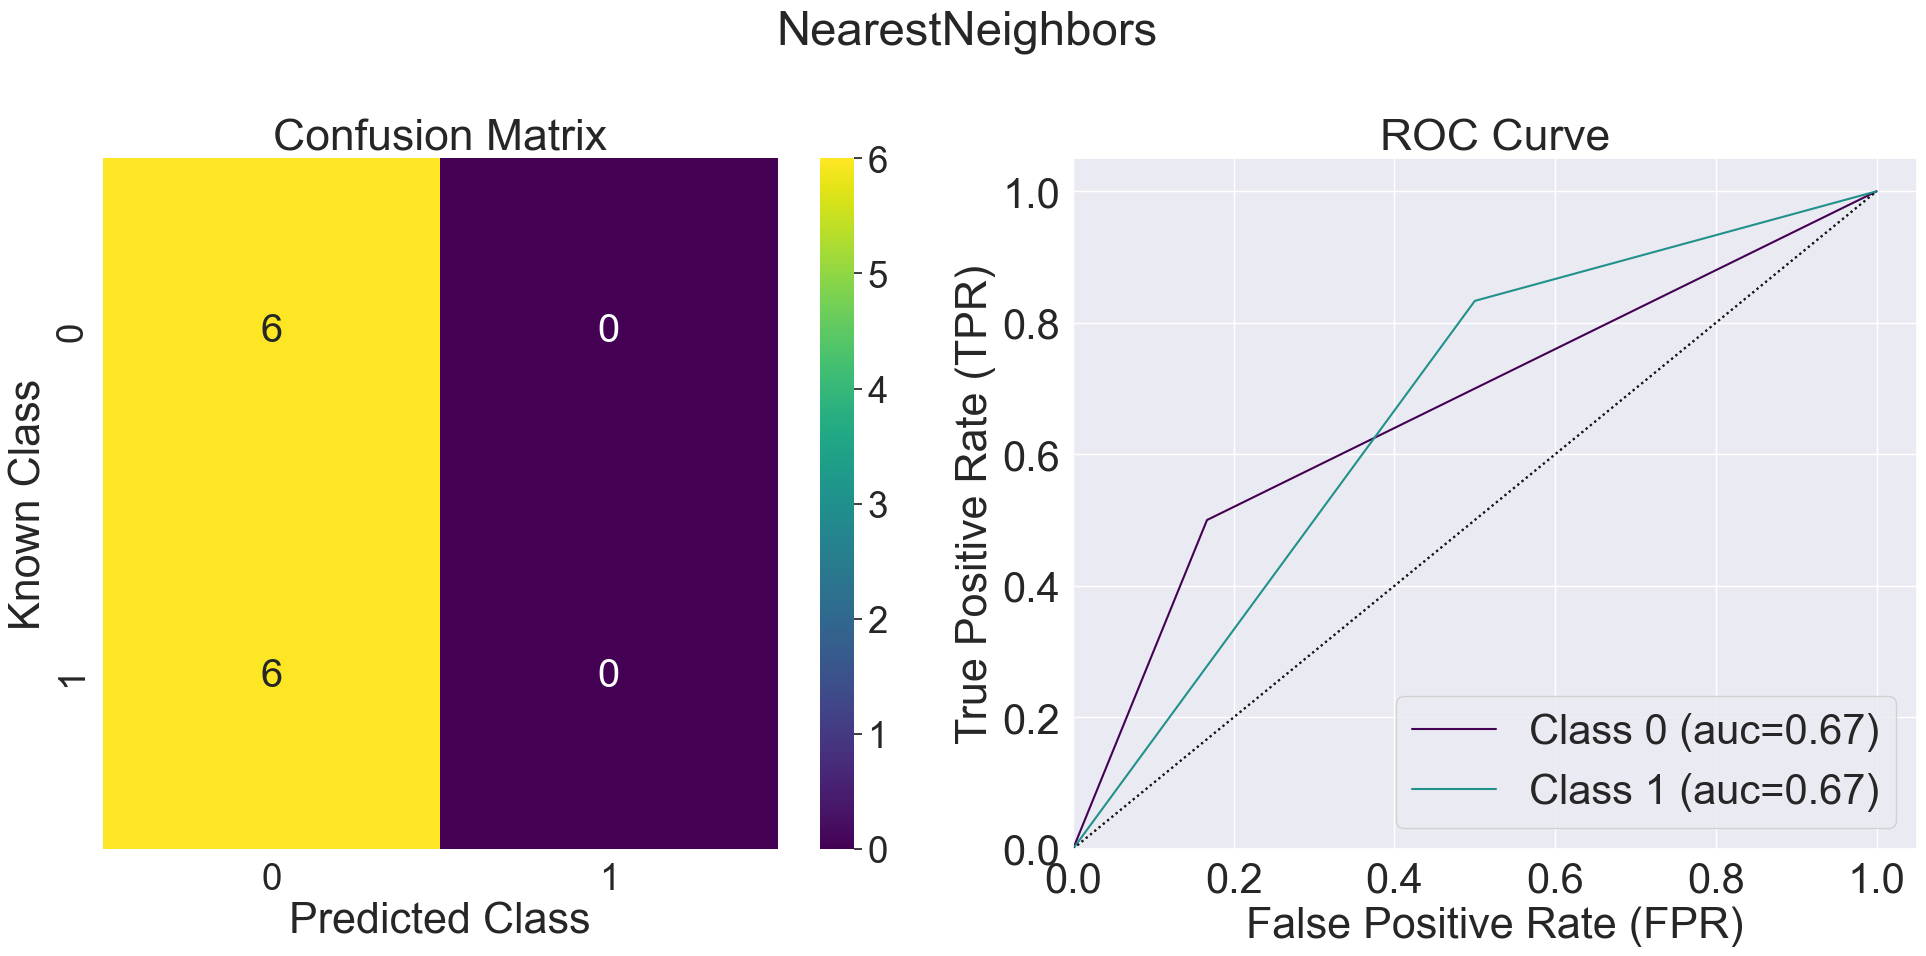

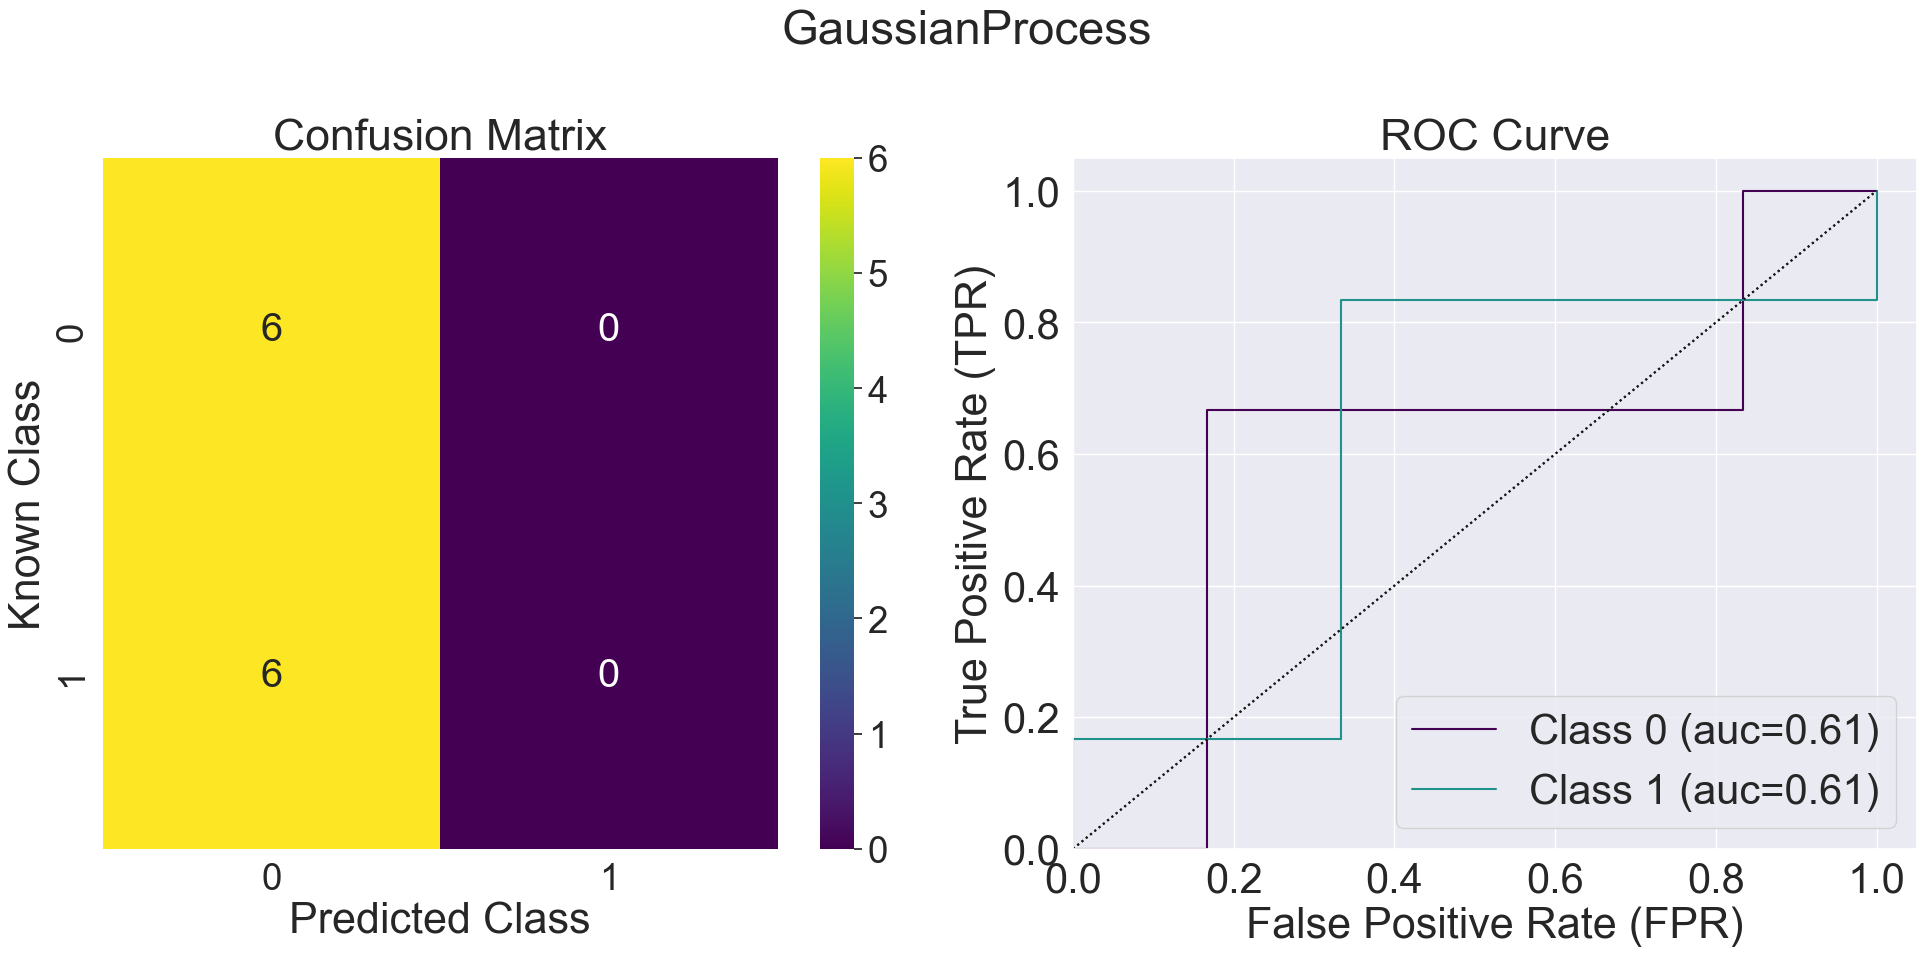

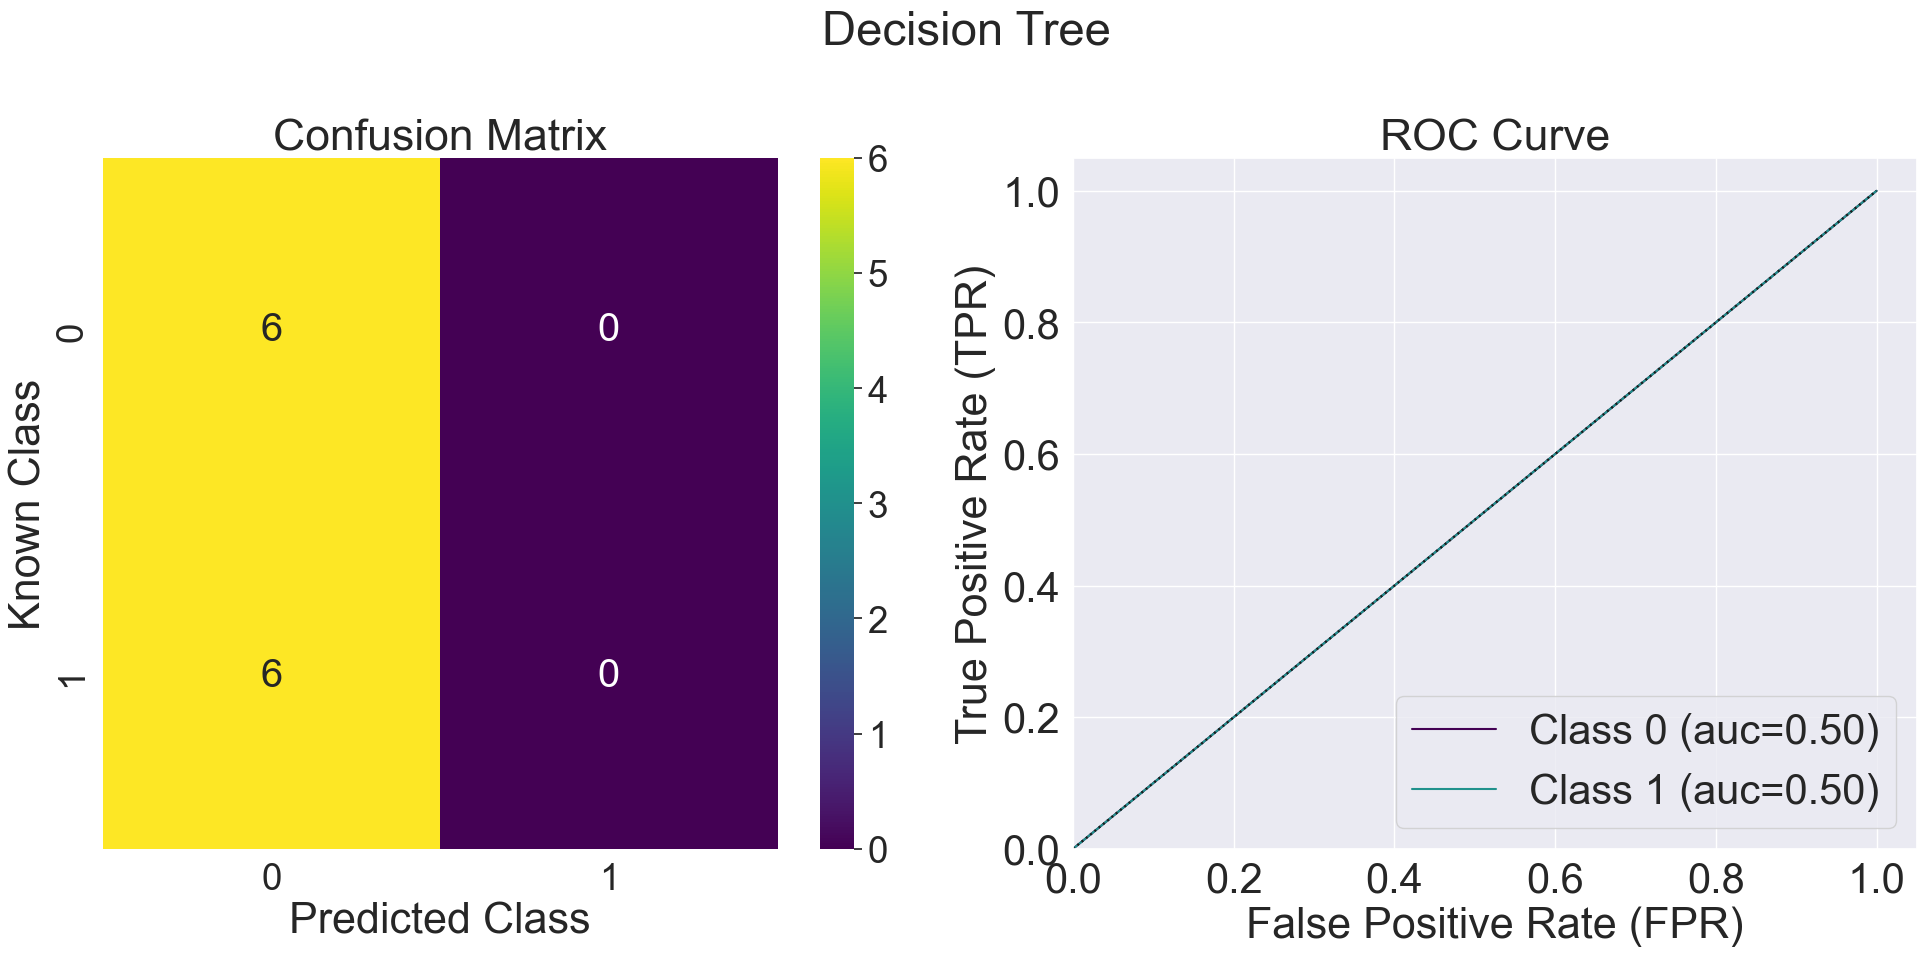

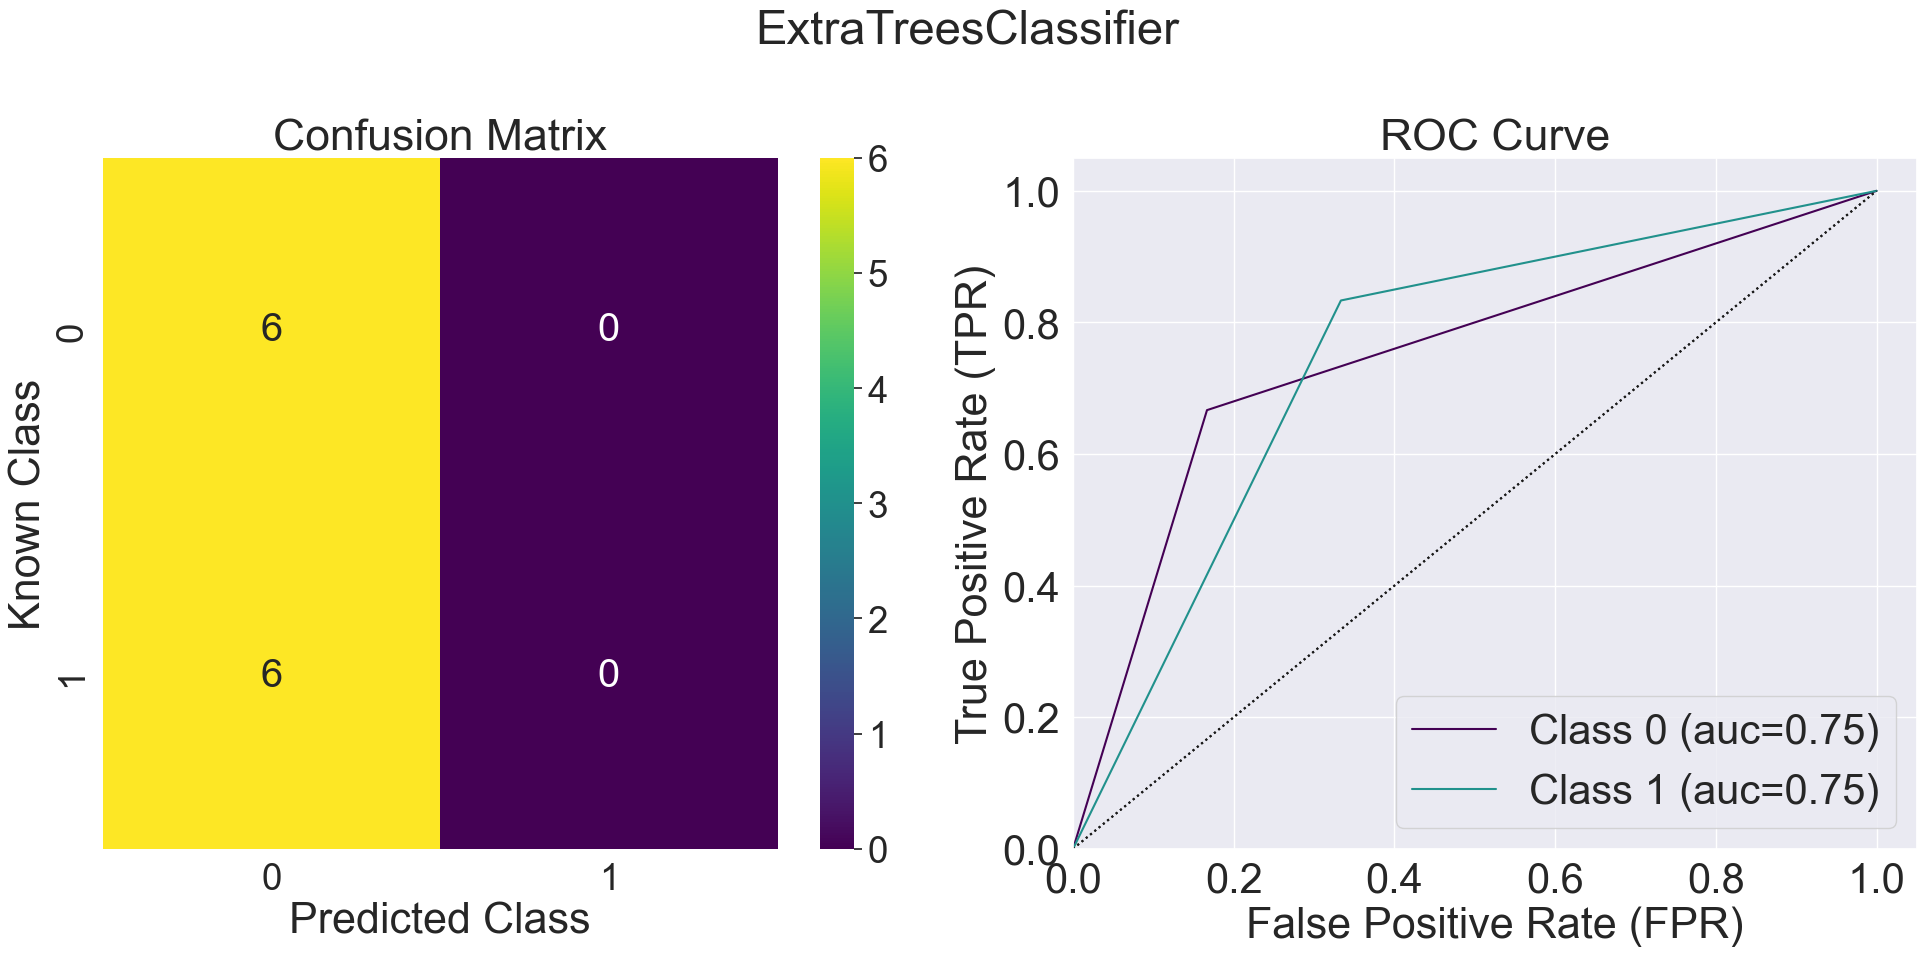

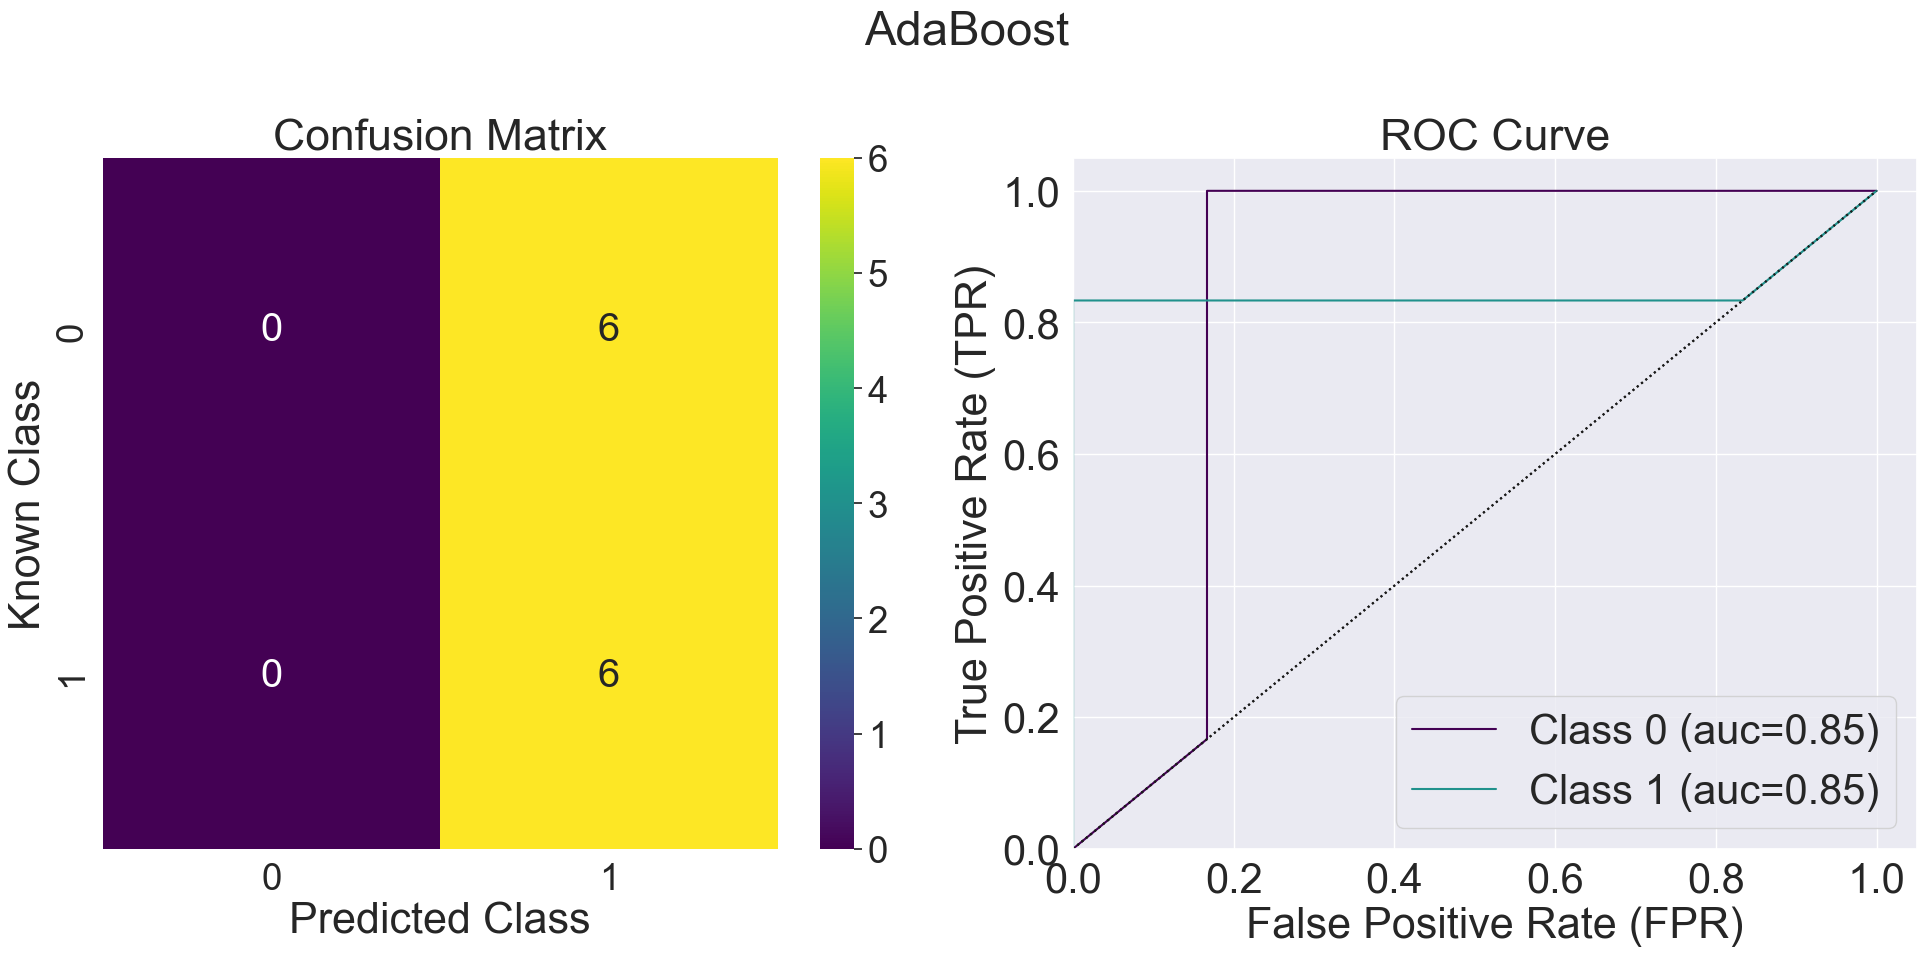

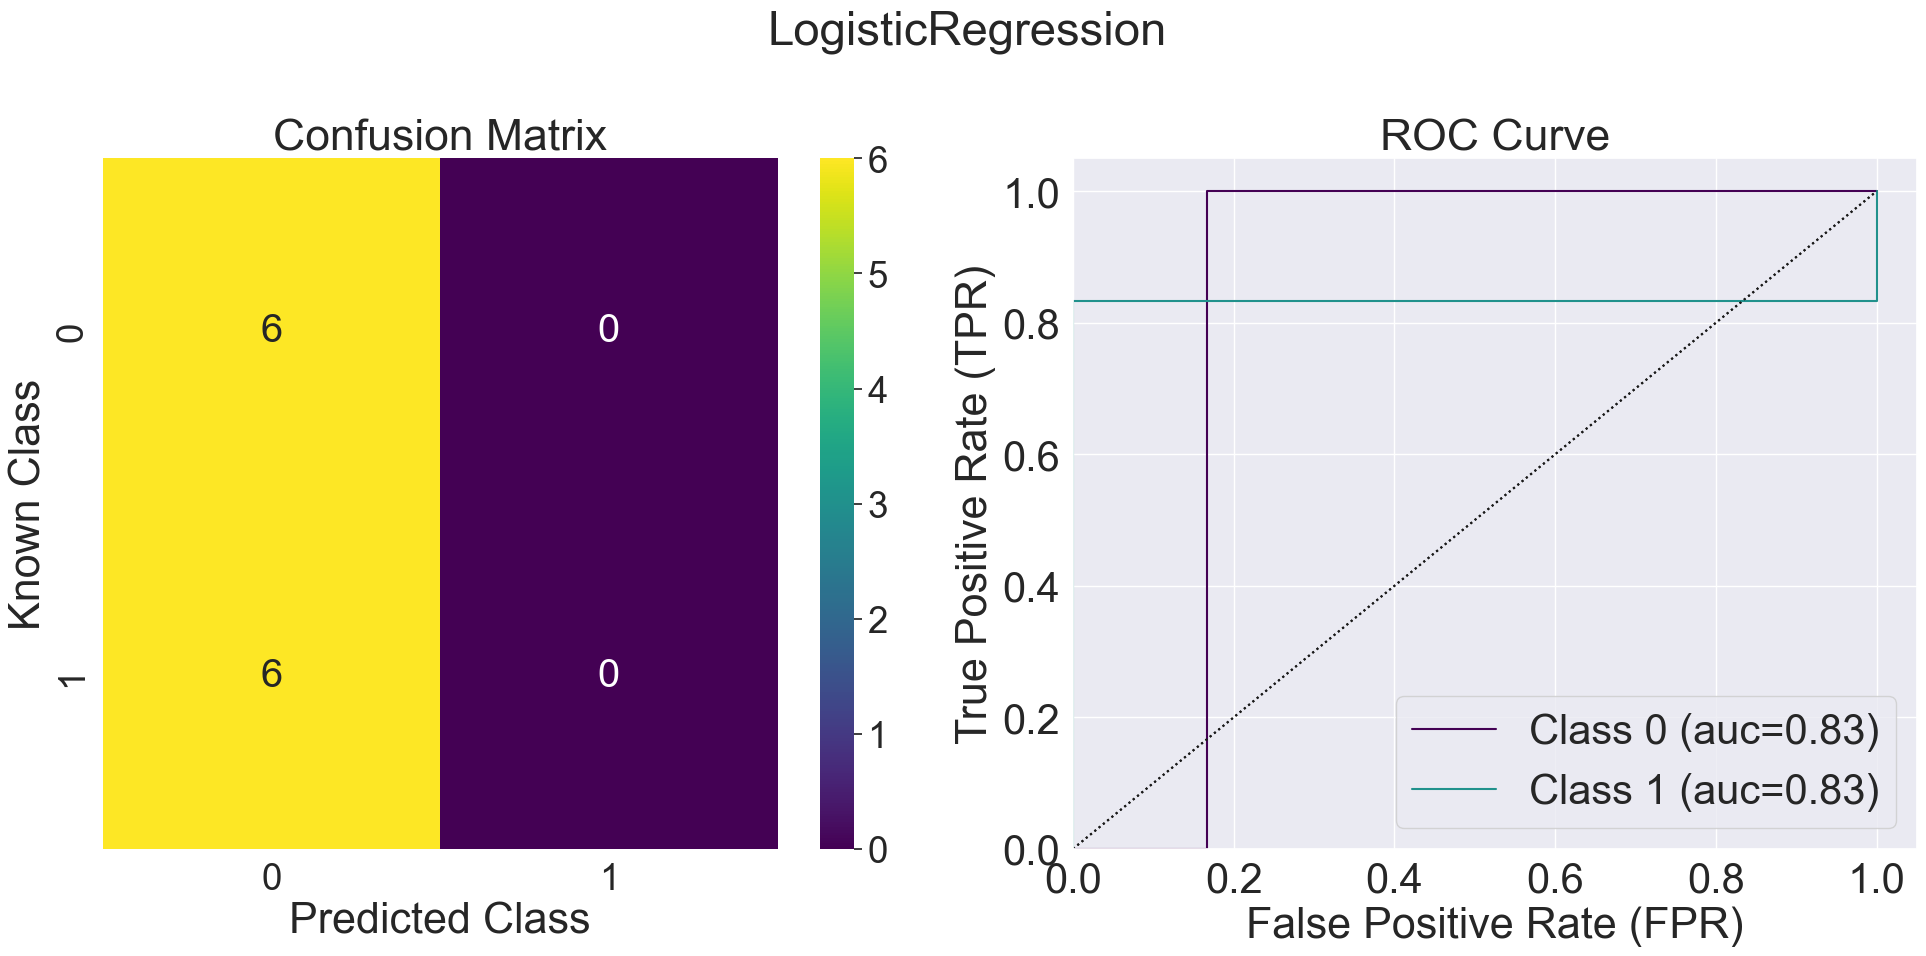

In [100]:
files_plt = []

kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "Decision Tree", "ExtraTreesClassifier", "AdaBoost",
         "LogisticRegression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = wf.build_data_from_directory(dirname, max_folds=1)
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.info("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.info("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_fingerprints_test.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))

    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_fingerprints_test.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from fingerprints features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:fingerprint_features")
log.info(df_metrics_for_paper.to_latex())

In [101]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_fingerprint_test.png")

Combining 6 images
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
New image will be W:6000 H:18000
Image 0 added at offset height 0
Image 1 added at offset height 3000
Image 2 added at offset height 6000
Image 3 added at offset height 9000
Image 4 added at offset height 12000
Image 5 added at offset height 15000


In [102]:
for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = wf.build_data_from_directory(dirname, max_folds=1)
    wf.which_are_misclassified(data, known_column_label="known", predicted_column_label="prediction", return_indx=False)


NearestNeighbors
-------------

Reading 0.csv
         known  prediction  prob0  prob1
m_index                                 
0          1.0         0.0    0.8    0.2
1          0.0         0.0    1.0    0.0
2          1.0         0.0    0.8    0.2
3          0.0         0.0    0.8    0.2
4          1.0         0.0    1.0    0.0
5          0.0         0.0    1.0    0.0
6          1.0         0.0    0.8    0.2
7          0.0         0.0    1.0    0.0
8          0.0         0.0    0.8    0.2
9          1.0         0.0    0.8    0.2
10         0.0         0.0    0.8    0.2
11         1.0         0.0    0.8    0.2

GaussianProcess
-------------

Reading 0.csv
         known  prediction     prob0     prob1
m_index                                       
0          1.0         0.0  0.536886  0.463114
1          0.0         0.0  0.526808  0.473192
2          1.0         0.0  0.521452  0.478548
3          0.0         0.0  0.539846  0.460154
4          1.0         0.0  0.615614  0.384386
5   